Notes:
       1. The data columns in the data file was compared to the columns described in the descriptions spreadsheet. 
          Found that the following columns described in the spreadsheet are not present in the data
          (is_inc_v, fico_range_high, fico_range_low, last_fico_range_high, last_fico_range_low)
          Possibly: total_rev_hi_lim \xa0 (dictionary) and total_rev_hi_lim ( loanbook) refer to the same variable
          verified_status_joint (dicitonary) and verification_status_joint (loanbook) are the same variables. 
       2. From looking at number of  null values concluded that only 511 accounts were JOINT. Therefore columns 
          applicable to   Joint loans had NAN for INDIVIDUAL accounts
       3. Need to determine how to handle  the columns that have missing values. 

In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from datetime import datetime as dt, timedelta as td
sns.set(color_codes=True)
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer 
from sklearn.metrics import roc_auc_score
from astropy.stats import median_absolute_deviation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder

In [41]:
loanbook=pd.read_csv('../rawdata/loan.csv')


C:\Users\Judith\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
loanbook.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [43]:
loanbook.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ###  Compare variable names in the  "loan.csv"  with  the variables listed in the data dictionary "LCDATADictionary.xlsx"as the number listed in the data dictionary is different.



In [44]:
file = '../rawdata/LCDATADictionary.xlsx'
exceldata =pd.ExcelFile(file)
data_dictionary =exceldata.parse('LoanStats')
dd_names=set(data_dictionary['LoanStatNew'])
loanbook_names = set(loanbook.columns.values)
names_indd_only = dd_names.difference(loanbook_names)
names_indd_only   # names in data dictionary only

{nan,
 'is_inc_v',
 'verified_status_joint',
 'total_rev_hi_lim \xa0',
 'fico_range_high',
 'fico_range_low',
 'last_fico_range_low',
 'last_fico_range_high'}

In [45]:
names_inlb_only=loanbook_names.difference(dd_names)
names_inlb_only # names in loans.csv only

{'total_rev_hi_lim', 'verification_status', 'verification_status_joint'}


It is very possible that total_rev_hi_lim \xa0  (dictionary) and total_rev_hi_lim (loans.csv) refer to the same variables and verified_status_joint  (dicitonary)  and verification_status_joint (loanbook) are the same variables. 
             
Variables only in data dictionary are: is_inc_v, fico_range_high, fico_range_low, last_fico_range_high, last_fico_range_low

Output from loanbook.info() gives total no. of loans as 887379.


##  Loan Amounts 

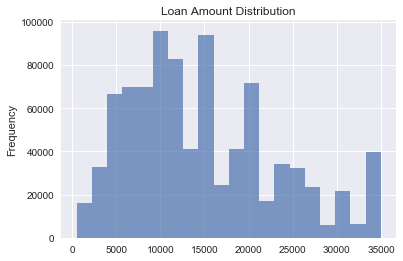

In [46]:
y= loanbook['loan_amnt']
pd.Series(y).plot(kind='hist',alpha=.7, bins=20, title='Loan Amount Distribution')

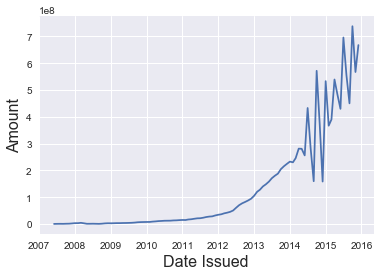

In [47]:
loanbook['issue_d'] =  pd.to_datetime(loanbook['issue_d'], format='%b-%Y')

Amount=loanbook.groupby(by=['issue_d'])['loan_amnt'].sum()

plt.plot(Amount)
plt.xlabel('Date Issued', fontsize=16)
plt.ylabel('Amount', fontsize=16)
plt.show()


## Creation of the binary variable "outcome"  for Default vs. Fully Paid.
The column 'loan_status' gives the current status of the loan. This column could be used to classify the loans into a default group and those loans that have been repaid. Also those loans that are current or did not meet the credit policy would also be separated out and removed from the analysis.  

In [48]:
# look at the distribution of the loans by status.
loan_status_freq =loanbook['loan_status'].value_counts().to_frame()
loan_status_freq

,loan_status
Current,601779
Fully Paid,207723
Charged Off,45248
Late (31-120 days),11591
Issued,8460
In Grace Period,6253
Late (16-30 days),2357
Does not meet the credit policy. Status:Fully Paid,1988
Default,1219
Does not meet the credit policy. Status:Charged Off,761


#### Group loan status into a default group and nodefault group as follows:
1. Default Group:  Charged off, Late(31-120 days), In Grace Period, Late(16-30 days), Default.
2. No Default Group : Fully Paid
3. Not included:
    1. Current, Does not meet the credit policy. Issued
    2. Does not meet the credit policy.Status:Charged off

In [49]:

loan_status_dict ={"Fully Paid" : 0 , 
                   "Charged Off": 1 , "Late (31-120 days)": 1,  "In Grace Period":1, "Late (16-30 days)":1,
                   "Default":1,
                   "Current" : 2 ,"Issued": 2,
                   "Does not meet the credit policy. Status:Fully Paid": 3,
                   "Does not meet the credit policy. Status:Charged Off": 3}

loanbook['outcome']= loanbook.loan_status.map(loan_status_dict)

loanbook.outcome.value_counts()

2    610239
0    207723
1     66668
3      2749
Name: outcome, dtype: int64

In [50]:
#Keep only the rows where outcome is 0 or 1, excluding the row swith  Current(2) and not qualified loans(3)

loanbook = loanbook[(loanbook['outcome'] < 2) ]

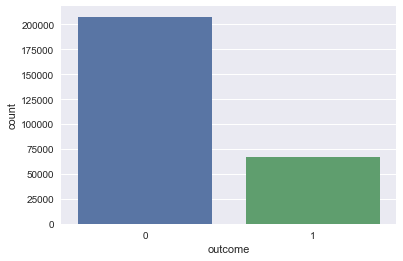

In [51]:
# Take a look at the distribution of the dependent variable outcome: 
sns.countplot(data=loanbook,
                  x ='outcome')

The proportion of defaults is much less than the proportion of no defaults. 

##  Features to retain for further exploration and those to be dropped.


####   Rationale for  dropping the first set of  features
1. As we are only interested in those features that would be available at the time of loan application we will drop
   the features that contain information collected as a result of the loan being approved.
2. Also drop those features that are unique to each loan applicant ( loan id, url, member_id).
3. The features 'desc', 'title', 'zip_code' , 'addr_state' may be useful but they will need to be engineered
   further to be included in this model and taking into consideration the time available for this project would not be used.
4. Grade will be retained for further exploration of the data but will not be included as a predictor variable as the objective    of this exercise is to come up with an independent model to grade the loans.

In [52]:
col_to_drop =['id','member_id','funded_amnt','funded_amnt_inv', 'pymnt_plan', 'url','desc','title','initial_list_status',
               'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
               'total_rec_late_fee','recoveries', 'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
               'last_credit_pull_d','policy_code', 'zip_code' , 'addr_state', 'sub_grade']

loanbook.drop(col_to_drop, axis=1, inplace=True)
loanbook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274391 entries, 0 to 887371
Data columns (total 49 columns):
loan_amnt                      274391 non-null float64
term                           274391 non-null object
int_rate                       274391 non-null float64
installment                    274391 non-null float64
grade                          274391 non-null object
emp_title                      259161 non-null object
emp_length                     274391 non-null object
home_ownership                 274391 non-null object
annual_inc                     274391 non-null float64
verification_status            274391 non-null object
issue_d                        274391 non-null datetime64[ns]
loan_status                    274391 non-null object
purpose                        274391 non-null object
dti                            274391 non-null float64
delinq_2yrs                    274391 non-null float64
earliest_cr_line               274391 non-null object
inq_last_6m

Down to 48 features and one outcome variable. Now look at the features further to see if binning/regrouping is needed.

## Categorical Features:
Do they need to be put into a smaller number of groups?

In [53]:
# look at the number of unique categories for each categorical feature
for col_name in loanbook.columns:
    if loanbook[col_name].dtypes == 'object':
        unique_cat = len(loanbook[col_name].unique())
        print(" '{col_name}' : {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

 'term' : 2 unique categories
 'grade' : 7 unique categories
 'emp_title' : 139903 unique categories
 'emp_length' : 12 unique categories
 'home_ownership' : 6 unique categories
 'verification_status' : 3 unique categories
 'loan_status' : 6 unique categories
 'purpose' : 14 unique categories
 'earliest_cr_line' : 649 unique categories
 'application_type' : 2 unique categories
 'verification_status_joint' : 4 unique categories


In [54]:
#'earliest cr_line' will be used to calculate length of credit history later in the notebook.

In [55]:
# drop emp_title as they are probably very specific titles regrouping into smaller number of categories could not be easily done.
loanbook.drop('emp_title', axis=1,  inplace= True)

In [56]:
#regroup purpose
loanbook['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

#Consolidate purpose into fewer categories debt = 'credit card','debt_consolidation', consumer= 'car', wedding, medical, vacation, major_purchase home= home improvement, house, renewable_energy, moving other= educational, small business

In [57]:
purpose_dict={ 'credit_card':'debt','debt_consolidation': 'debt', 
                'car': 'consumer', 'wedding':'consumer', 'medical': 'consumer', 'vacation':'consumer','major_purchase':'consumer',
               'home_improvement': 'home', 'house': 'home', 'renewable_energy':'home', 'moving': 'home',
               'educational': 'other', 'small_business': 'other', 'other': 'other'}

loanbook['purpose_regrp'] = loanbook.purpose.map(purpose_dict)

loanbook.purpose_regrp.value_counts()

debt        216016
other        20792
home         20393
consumer     17190
Name: purpose_regrp, dtype: int64

In [58]:
#regroup home_ownership
loanbook['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [59]:
#consolidate home ownership into four groups: Mortgage, RENT, OWN and OTHER
home_dict={'RENT':'RENT', 'OWN': 'OWN', 'MORTGAGE': 'MORTGAGE', 'OTHER': 'OTHER', 'NONE':'OTHER', "ANY":"OTHER"}

loanbook['home_regrp']=loanbook.home_ownership.map(home_dict)
loanbook.home_regrp.value_counts()

MORTGAGE    134317
RENT        115685
OWN          24204
OTHER          185
Name: home_regrp, dtype: int64

In [60]:
loanbook['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years', '5 years',
       '1 year', '6 years', '2 years', '7 years', '8 years', 'n/a'], dtype=object)

In [61]:
#44825 with no employment length. included these in a group n/a.
emp_dict={'< 1 year': "0-2",'10+ years': '10 +', '1 year': '0-2', '3 years': '3-10', '8 years': '3-10', '9 years': '3-10',
       '4 years': '3-10', '5 years': '3-10', '6 years': '3-10', '2 years': '0-2', '7 years': '3-10', 'n/a': 'n/a'}
          
loanbook['emp_length_regrp']=loanbook.emp_length.map(emp_dict)
loanbook.emp_length_regrp.value_counts()

3-10    113364
10 +     83448
0-2      66512
n/a      11067
Name: emp_length_regrp, dtype: int64

In [62]:
loanbook['application_type'].unique()

loanbook['application_type'].value_counts()

INDIVIDUAL    274385
JOINT              6
Name: application_type, dtype: int64

In [63]:
#term : The number of payments on the loan. Values are in months and can be either 36 or 60.
loanbook['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [64]:
#verified_status_joint:Indicates if the co-borrowers' joint income was verified by LC,
#                                    not verified, or if the income source was verified
loanbook['verification_status_joint'].unique()

ver_dict ={'Source Verified': 'Verified', 'Verified': 'Verified', 'Not Verified': 'Not Verified'}
loanbook['verified_joint_edt'] =loanbook.verification_status_joint.map(ver_dict)
loanbook['verified_joint_edt'].value_counts()

Verified        4
Not Verified    2
Name: verified_joint_edt, dtype: int64

In [65]:
#verification_status : Indicates if income was verified by LC, not verified, or if the income source was verified

loanbook['verification_status'].unique()

loanbook['verification_status'].value_counts()

#Combine 'Verified' and 'Source Verified'as Verified
ver_dict ={'Source Verified': 'Verified', 'Verified': 'Verified', 'Not Verified': 'Not Verified'}
loanbook['verified_edt'] =loanbook.verification_status.map(ver_dict)
loanbook['verified_edt'].value_counts()

Verified        183652
Not Verified     90739
Name: verified_edt, dtype: int64

In [66]:
#create column 'date_issued' with date of issue as year-month-date.
loanbook['date_issued'] =  pd.to_datetime(loanbook['issue_d'], format='%b-%Y')

#create column 'length_credithist' with no. of days of credit history.

loanbook['earliest_credit_date'] =  pd.to_datetime(loanbook['earliest_cr_line'], format='%b-%Y')
loanbook['td_credithist'] = loanbook['date_issued']-loanbook['earliest_credit_date']
loanbook['length_credithist'] = loanbook['td_credithist'].dt.total_seconds() / (24 * 60 * 60)
loanbook= loanbook.drop('td_credithist', axis=1)

In [67]:
#create year variable
loanbook.loc[:, 'year'] = loanbook.loc[:,'date_issued'].dt.year
loanbook.loc[:,'year'] =loanbook.loc[:,'year'].astype('category')

### Numeric Features. 

In [68]:
loanbook.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,outcome,length_credithist
count,274391.000000,274391.000000,274391.000000,2.743910e+05,274391.000000,274391.000000,274391.000000,123660.000000,35227.000000,274391.000000,...,226.000000,226.000000,226.000000,226.000000,2.104510e+05,226.000000,226.000000,226.000000,274391.000000,274391.000000
mean,13728.555237,13.922626,422.213793,7.249446e+04,16.786753,0.263627,0.850724,34.871098,75.235416,11.002241,...,1.526549,3.318584,5614.641593,60.933628,2.943548e+04,1.274336,2.168142,2.738938,0.242967,5581.872113
std,8188.024448,4.432766,246.006149,6.060255e+04,7.886752,0.769022,1.066661,21.829885,29.507438,4.934560,...,1.503094,2.874456,5053.513241,19.668965,2.945983e+04,1.780126,3.724758,3.883639,0.428876,2571.207469
min,500.000000,5.320000,15.690000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.900000,0.000000e+00,0.000000,0.000000,-4.000000,0.000000,1095.000000
25%,7500.000000,10.990000,243.750000,4.500000e+04,10.920000,0.000000,0.000000,16.000000,54.000000,8.000000,...,0.000000,1.000000,2108.250000,48.625000,1.320000e+04,0.000000,0.000000,1.000000,0.000000,3865.000000
50%,12000.000000,13.670000,368.450000,6.200000e+04,16.440000,0.000000,1.000000,32.000000,77.000000,10.000000,...,1.000000,3.000000,4280.000000,62.900000,2.201000e+04,1.000000,0.000000,2.000000,0.000000,5113.000000
75%,18875.000000,16.990000,551.825000,8.700000e+04,22.290000,0.000000,1.000000,51.000000,101.000000,14.000000,...,2.000000,4.750000,7895.750000,75.575000,3.650000e+04,2.000000,3.000000,4.000000,0.000000,6848.000000
max,35000.000000,28.990000,1424.570000,8.900060e+06,59.260000,29.000000,8.000000,152.000000,129.000000,76.000000,...,8.000000,21.000000,30567.000000,102.800000,2.013133e+06,9.000000,21.000000,19.000000,1.000000,24138.000000


In [69]:
# Which features are  contnious and wide range and can be binned using q cut and which featuresare dicretelow valued and better
# binned using cut and custom bins.
# Obtain the number of uniques values for each feature. Those that have a value greater than 30 can be binned using qcut. 
# those with a value less than 30 will be binned using bins specifically made as appropriate.
float_features =[]
        
float_features=[(x, len(loanbook[x].unique())) for x in loanbook.columns if loanbook[x].dtypes == 'float64'] 

for x,y in sorted(float_features, key=lambda p:p[1]):
    print(" {x}: {y}" .format (x=x, y=y))


 acc_now_delinq: 6
 annual_inc_joint: 7
 dti_joint: 7
 collections_12_mths_ex_med: 8
 open_acc_6m: 8
 open_il_12m: 8
 inq_last_6mths: 9
 open_rv_12m: 9
 inq_fi: 10
 open_il_24m: 13
 pub_rec: 15
 open_rv_24m: 16
 open_il_6m: 18
 total_cu_tl: 19
 inq_last_12m: 19
 delinq_2yrs: 24
 open_acc: 59
 mths_since_rcnt_il: 63
 total_acc: 109
 mths_since_last_record: 124
 mths_since_last_delinq: 128
 mths_since_last_major_derog: 153
 il_util: 174
 all_util: 198
 total_bal_il: 204
 max_bal_bc: 218
 int_rate: 513
 revol_util: 1221
 loan_amnt: 1340
 length_credithist: 2355
 dti: 3996
 tot_coll_amt: 4384
 total_rev_hi_lim: 10001
 annual_inc: 20740
 installment: 47560
 revol_bal: 48515
 tot_cur_bal: 144945


#####  Bin using quantiles

In [70]:
# Bin using quantiles 
numeric_cols= ['length_credithist','annual_inc','dti', 'revol_bal','revol_util', 'total_acc','open_acc', 
               'loan_amnt','mths_since_last_delinq','mths_since_last_major_derog', 'open_il_6m', 'mths_since_rcnt_il',
               'total_bal_il','il_util', 'max_bal_bc',  'all_util',  'total_rev_hi_lim' ]
for i in numeric_cols:
    loanbook[i + "_quant"] =pd.qcut(loanbook[i], 5, labels=False)


##### Custom Bins

In [71]:
#custom bins
small_numeric = ['inq_last_6mths', 'open_acc_6m', 'open_il_12m', 'open_il_24m','open_rv_12m',
                 'open_rv_24m', 'inq_fi', 'total_cu_tl','inq_last_12m', 'acc_now_delinq' ]
bins = [-1, 0.9, 2.1, 4.1, 6.1, 7.1, 100]

group_names = ['None', '1-2', '3-4', '5-6', '6-7', '7+']

for i in small_numeric:
    loanbook[i + "_edit"] =pd.cut(loanbook[i], bins, labels=group_names)


In [72]:
loanbook['delinq_2yrs'].unique()

bins = [-1, 0.9, 5.1, 10.1, 15.1, 20.1, 40]

group_names = ['None', '1-5', '6-10 ', '11 - 15', '16-20', '20+']

loanbook['delinq_2yrs_edit'] = pd.cut(loanbook['delinq_2yrs'], bins, labels=group_names)
loanbook[['delinq_2yrs','delinq_2yrs_edit']].head()

#delinq_2yrs_none_any : make two categories. 0 ='None' 1 or more= 'Past Due'
bins = [-1, 0.9, 40]

group_names = ['None', 'Past Due']

loanbook['delinq_2yrs_none_any'] = pd.cut(loanbook['delinq_2yrs'], bins, labels=group_names)

In [73]:
#tot_coll_amt: Total collection amounts ever owed

bins = [-1, 0.90, 1000, 10000, 500000]

group_names = ['None', '1000', '10000', '50000 +']
loanbook['tot_coll_amt_quant'] = pd.cut(loanbook['tot_coll_amt'], bins, labels=group_names  )



loanbook['tot_coll_amt_quant'].value_counts


bins = [-1, 0.90, 1000, 10000, 500000]

group_names = ['None', '1000', '10000', '50000 +']
loanbook['tot_cur_bal_quant'] = pd.cut(loanbook['tot_cur_bal'], bins, labels=group_names  )

loanbook['tot_cur_bal_quant'].value_counts()

50000 +    191834
10000       12642
1000          428
None           53
Name: tot_cur_bal_quant, dtype: int64

In [74]:
loanbook['collections_12_mths_ex_med'].unique()
bins = [-1, 0.9, 1.1, 100]

group_names = ['None', '1', '2+']

loanbook['collections_12_mths_ex_med_quant'] = pd.cut(loanbook['collections_12_mths_ex_med'], bins, labels=group_names)

loanbook['collections_12_mths_ex_med_quant'].value_counts()

None    272401
1         1805
2+         129
Name: collections_12_mths_ex_med_quant, dtype: int64

In [75]:
#mths_since_last_record	The number of months since the last public record.


bins = [-1,  6, 130]
group_names = ['0-6', '6+']
loanbook['mths_since_last_record_quant'] = pd.cut(loanbook['mths_since_last_record'], bins, labels=group_names)

## Take a look at the data frame after all the changes.


In [76]:
loanbook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274391 entries, 0 to 887371
Data columns (total 90 columns):
loan_amnt                            274391 non-null float64
term                                 274391 non-null object
int_rate                             274391 non-null float64
installment                          274391 non-null float64
grade                                274391 non-null object
emp_length                           274391 non-null object
home_ownership                       274391 non-null object
annual_inc                           274391 non-null float64
verification_status                  274391 non-null object
issue_d                              274391 non-null datetime64[ns]
loan_status                          274391 non-null object
purpose                              274391 non-null object
dti                                  274391 non-null float64
delinq_2yrs                          274391 non-null float64
earliest_cr_line                   

## From the bar charts looking at rate of default vs each feature by year and loan grade decided the following:
1. Use only the data from 2010-1015 as the data from 2007 -2009 seemed inconsistant.
2. Drop the attributes present only in the year 2015. 
3. Drop the attributes only available from 2012( total_rev_hi_lim, tot_cur_bal, tot_coll_amnt, mths_since_last_major_derog,   acc_now_delinq, collections_12mths_ex_med)
4. Drop apllication_type as joint accounts present only for 2015
5. Created delinq_2yrs_none_any ( two categories: no delinquencies vs atleast one) to be used instead of delinq_2yrs
6. acc_now_delinq: up until 2011 no delinquent accounts and in 2012 only one loan grade had some. So deliquent account activity present only for 2013-2015.

## Explore the predictive strength of each feature on default rate:
    Look at how the features that would be available at the time of applying for a loan relate to the percentage of defaults
    in a given year.
    
 #####   This notebook uses loans_outcome_new.pkl where the loan_status "Issued" is not included with the default loans.
  

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set(color_codes=True)
%matplotlib inline

In [2]:
#read in pickled data frame created in  0.2-LC-data exploration notebook
loans_outcome = pd.read_pickle('../data/loans_outcome_new.pkl')

## Grade

In [3]:
#Percent default for each year within grade, output from here corresponds to the bars plotted by factorplot below. Factorplot 
#calculates the percentages directly from the data and does not use the result from here. 

grade_year_pcts = loans_outcome.groupby(['grade', 'year']).agg({'outcome': (lambda x: (x.sum()/x.count())*100)})
                                                                 



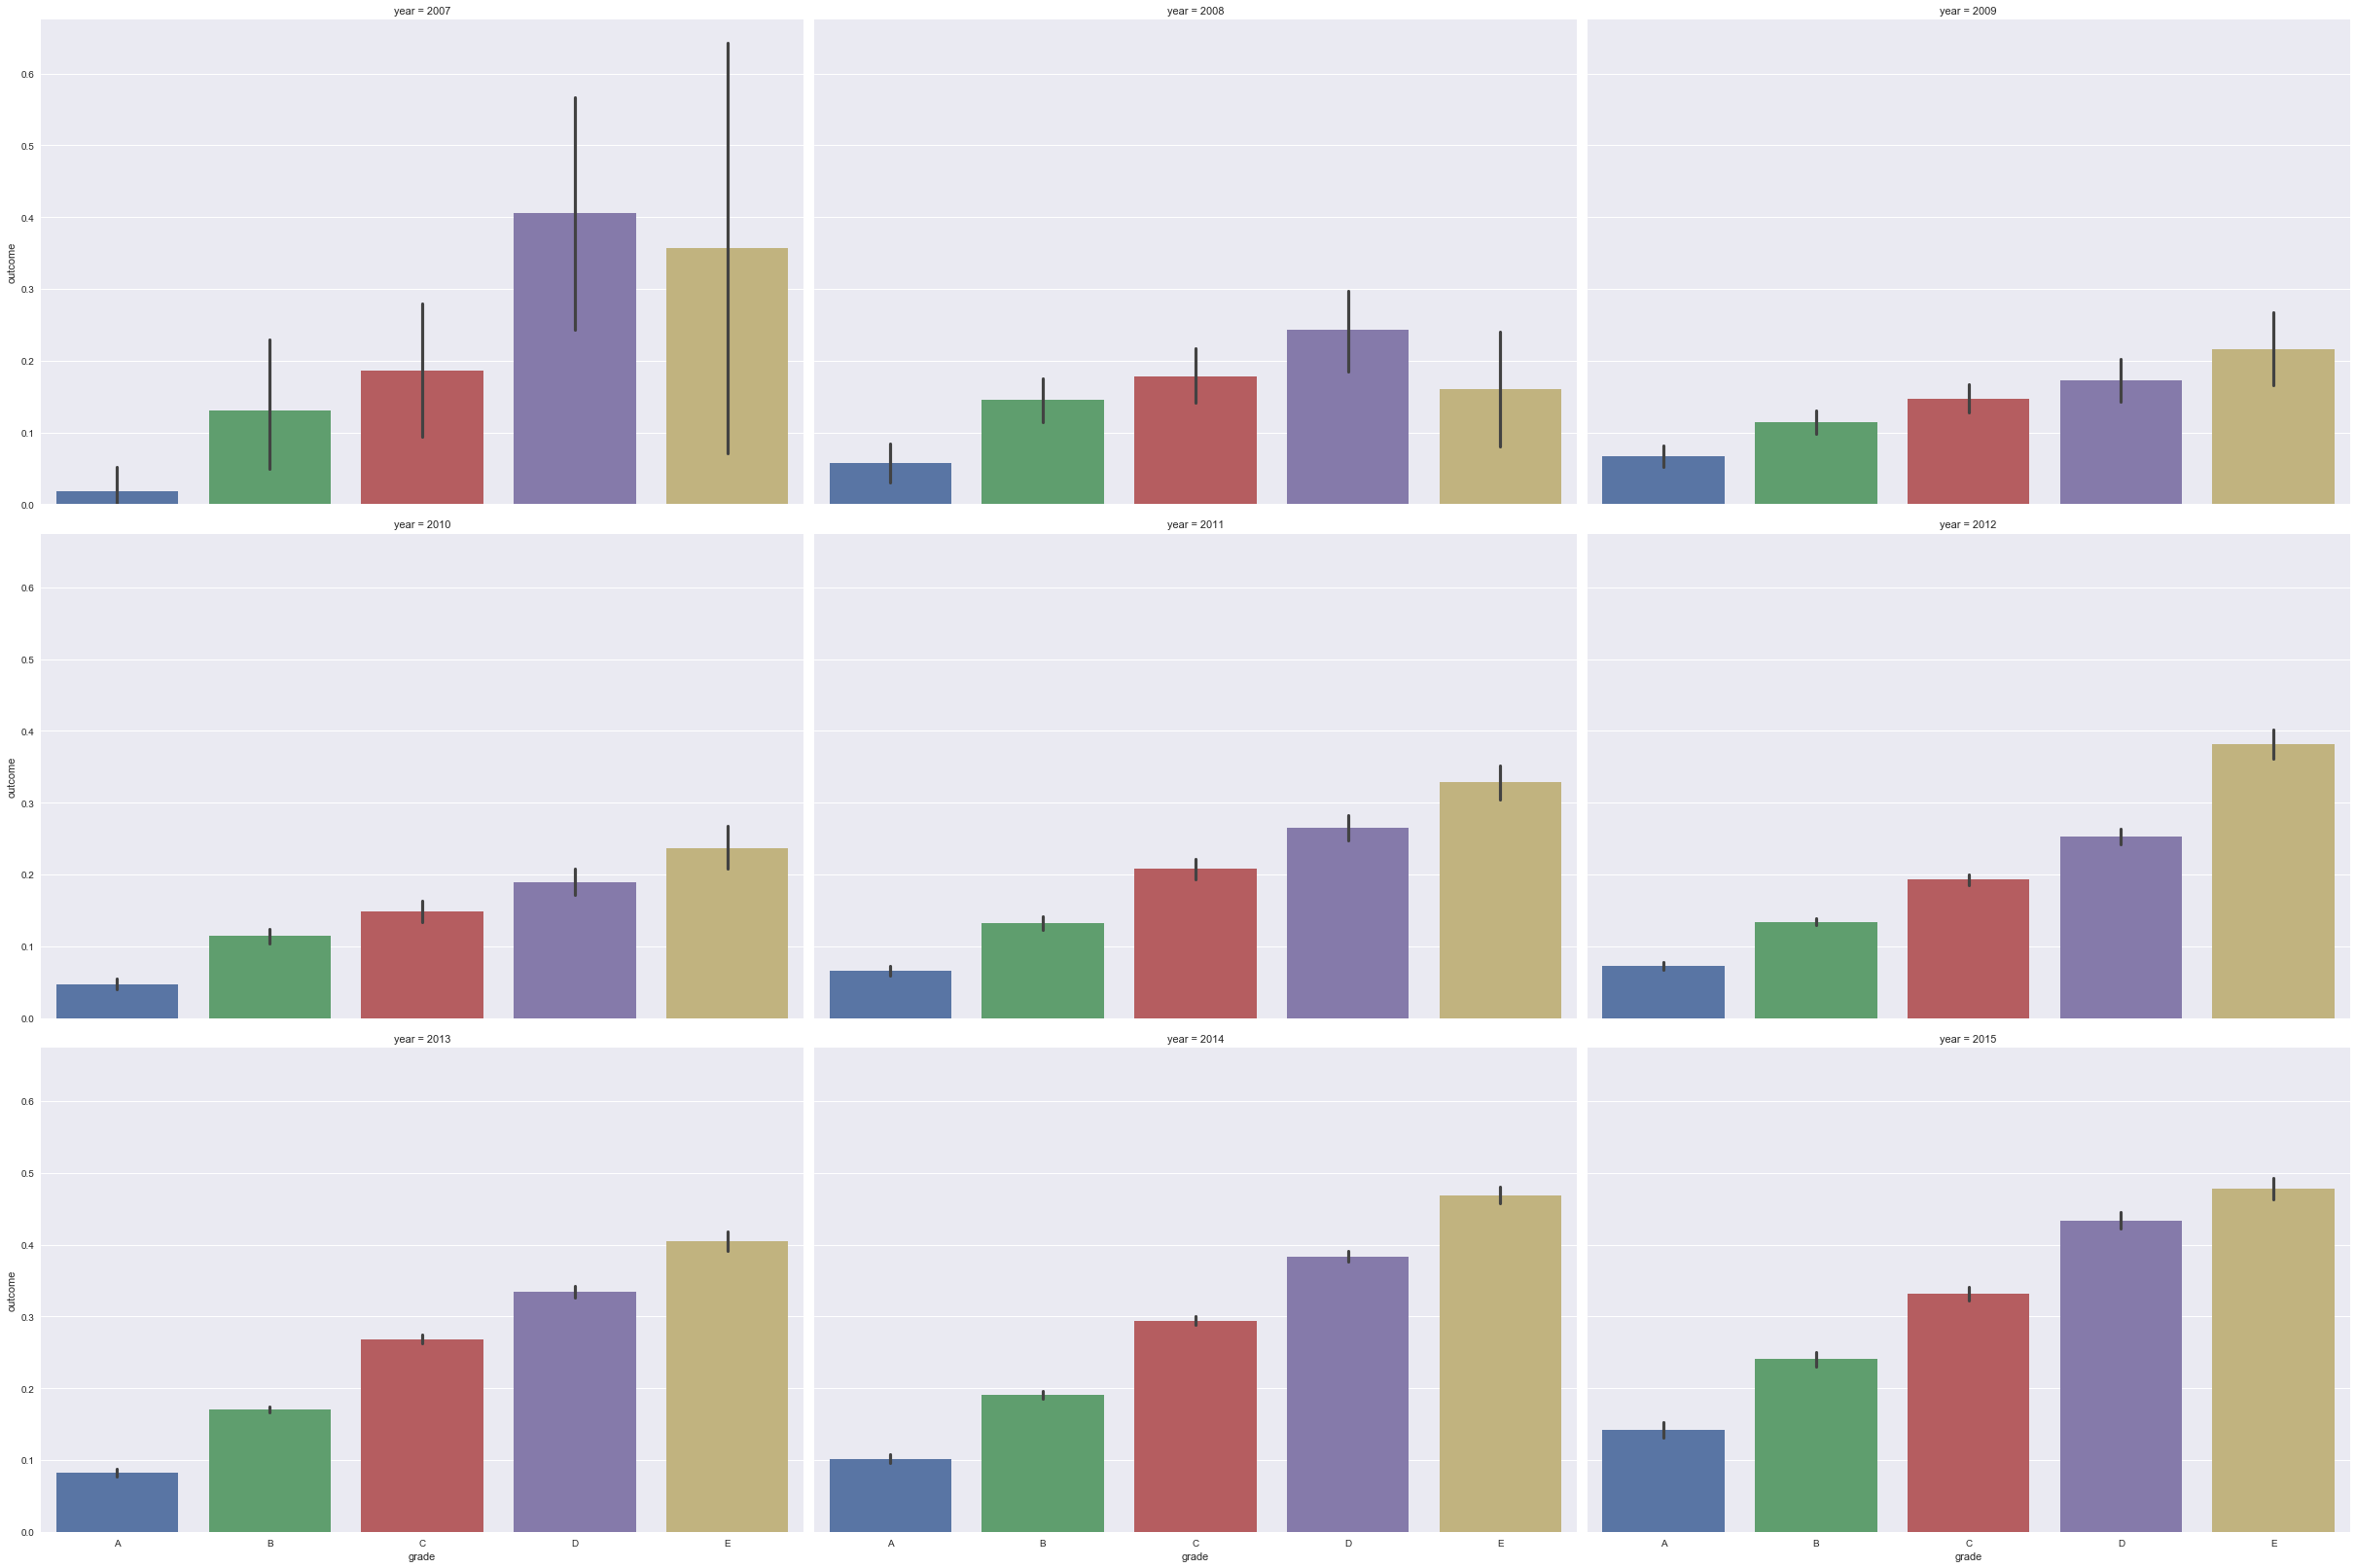

In [4]:

g = sns.factorplot(x='grade', y='outcome', col= 'year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)




Observations: 
    1. Expect default percentage to increase from grade A to E. In the years 2007 and 2008 the default percentage 
       for grade D was more than for Grade E. 2009 onwards it is as expected. This could be reflecting that LC was better
       able categorise the risk of a loan defaulting in the years 2009 and after.
    2. When Issued was included as a default : The following was observed. This has changed now.
       Overall percentage of loans defaulting markedly greater in 2015 than the preceeding 5 years.Is it possible that LC
       changed their grading system giving less weight to some factors that were important that resulted in more bad loans
       being classified as grades A ,B and C rather than D or E?
    

## Purpose


In [5]:
#percent default for each purpose within grade

purpose_grade_pcts = loans_outcome.groupby(['year', 'grade','purpose_regrp',]).agg({'outcome':[ (lambda x: (x.sum()/x.count())*100),
                                                                                         'sum', 'count']})
                                                                             


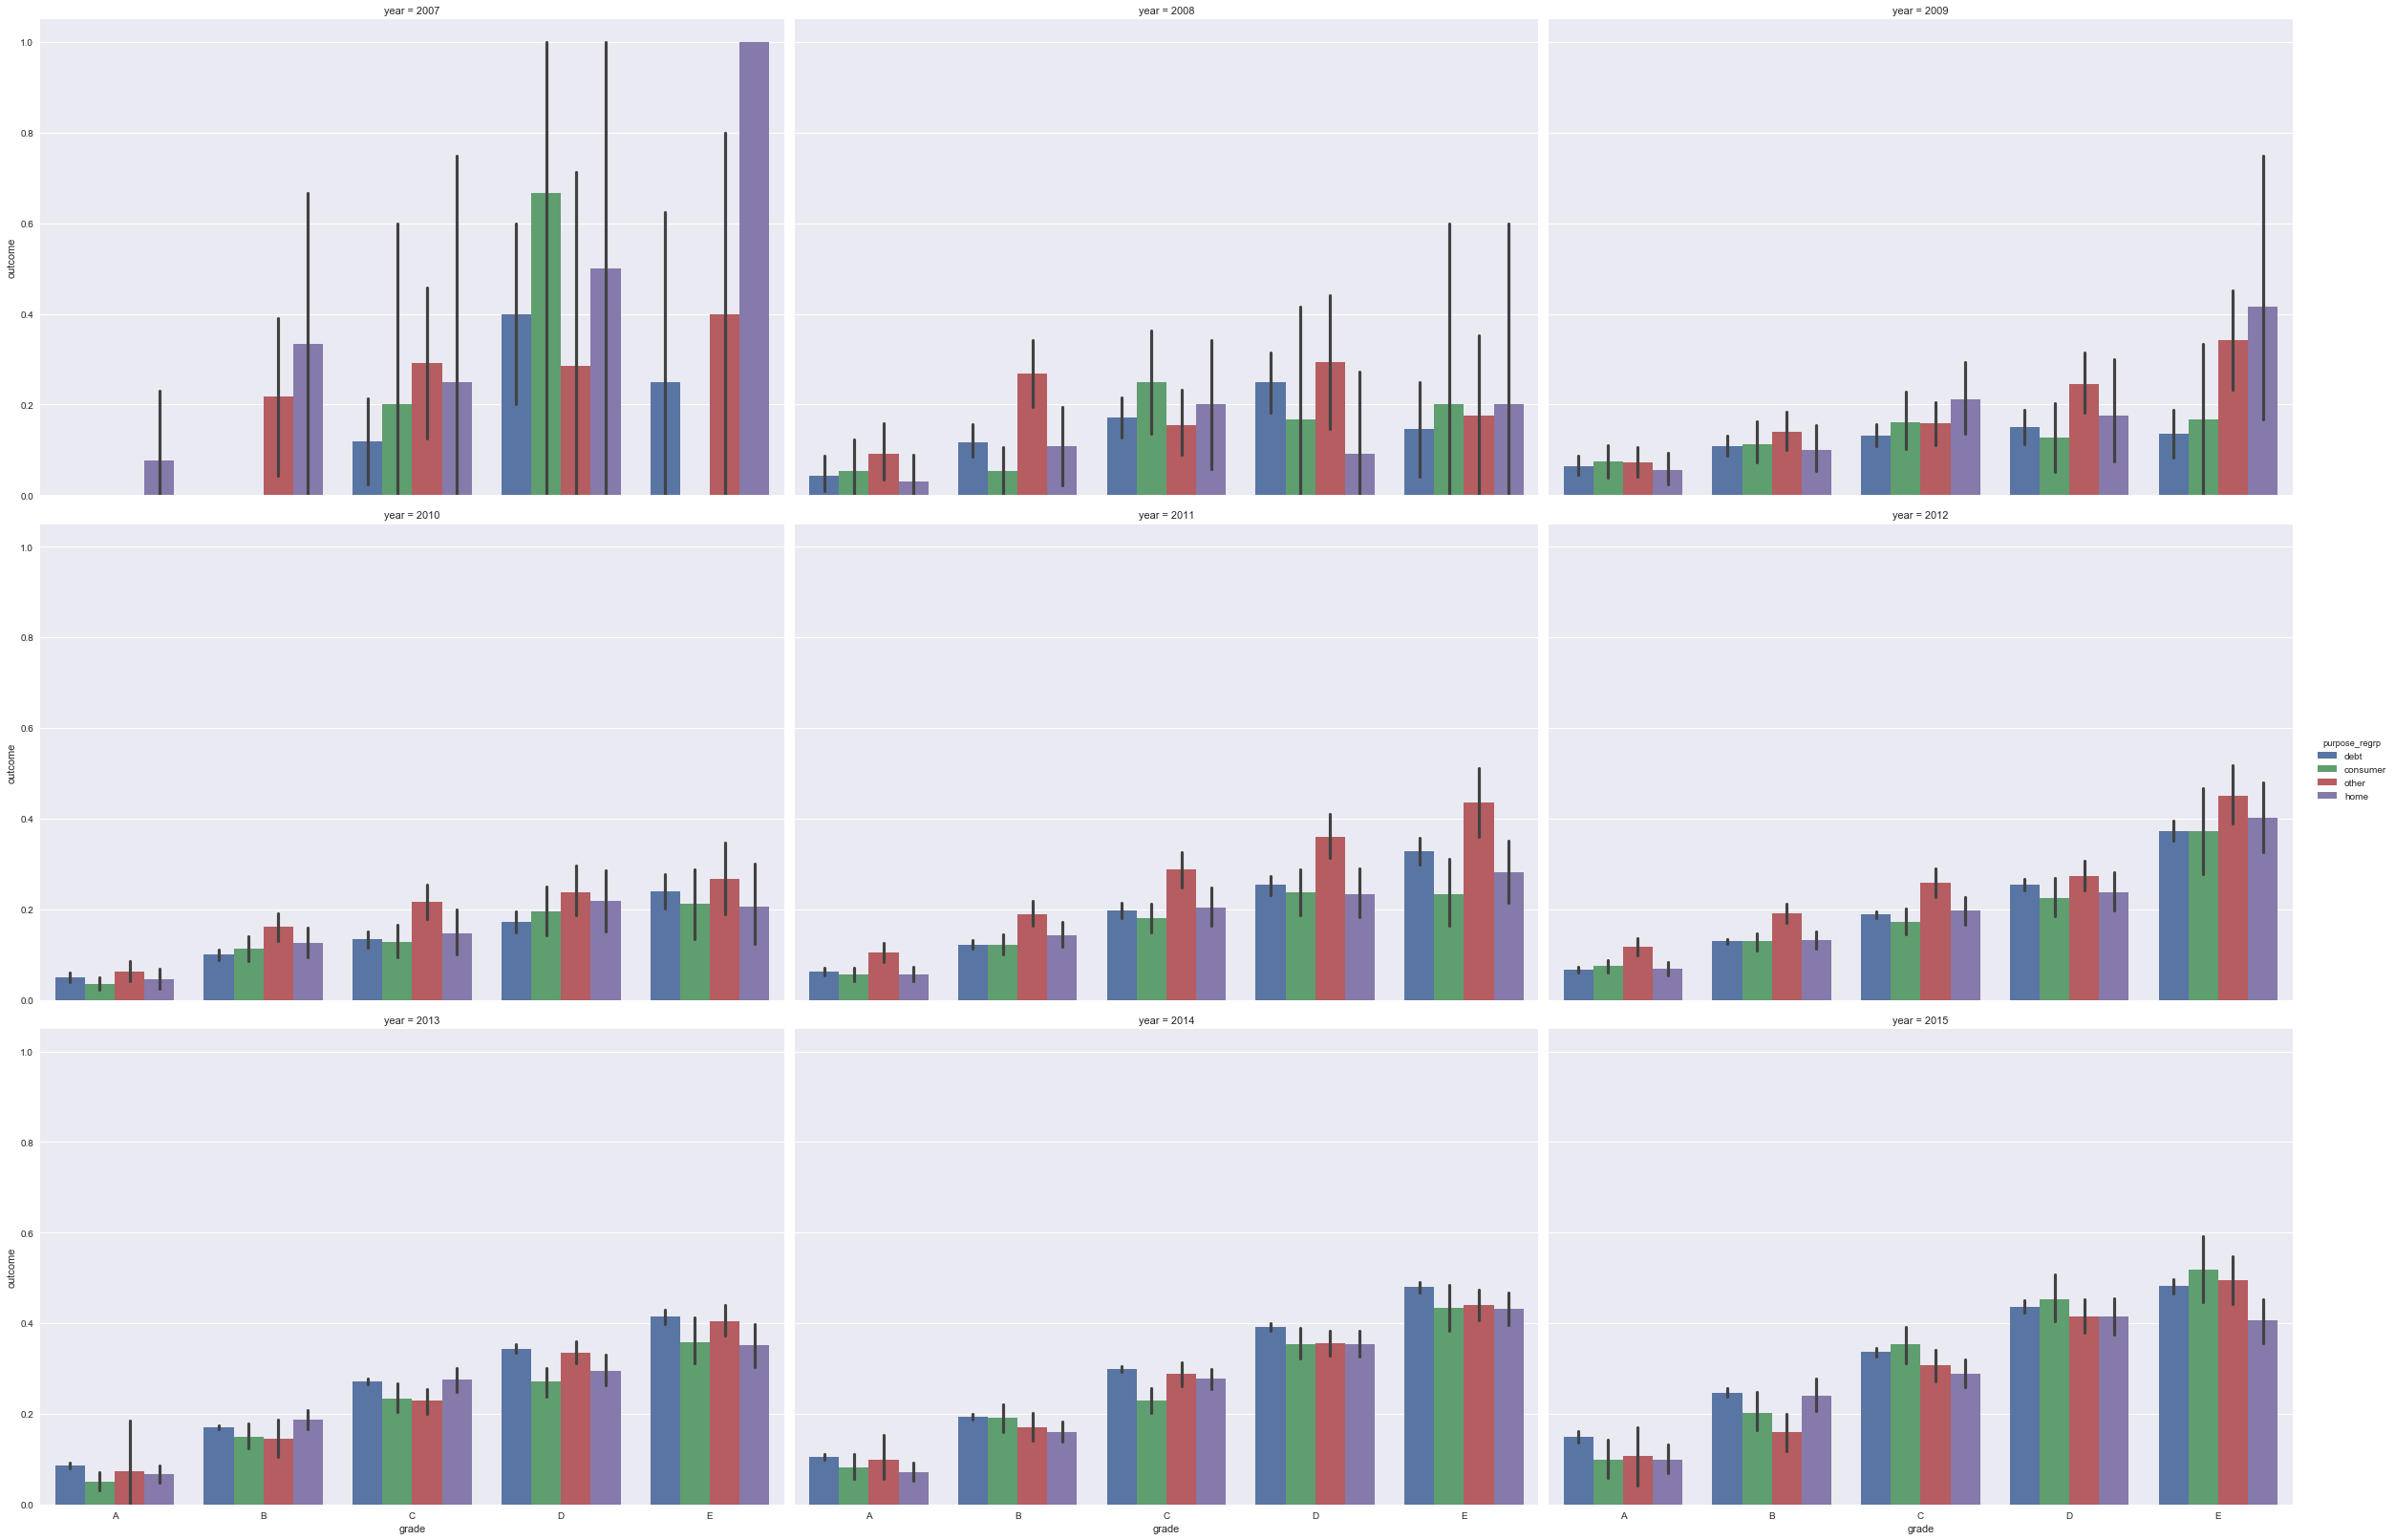

In [6]:

g = sns.factorplot(x='grade', y='outcome', hue='purpose_regrp', col= 'year', col_wrap= 3,
                   data=loans_outcome, kind='bar', 
                    order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)


## Home Ownership

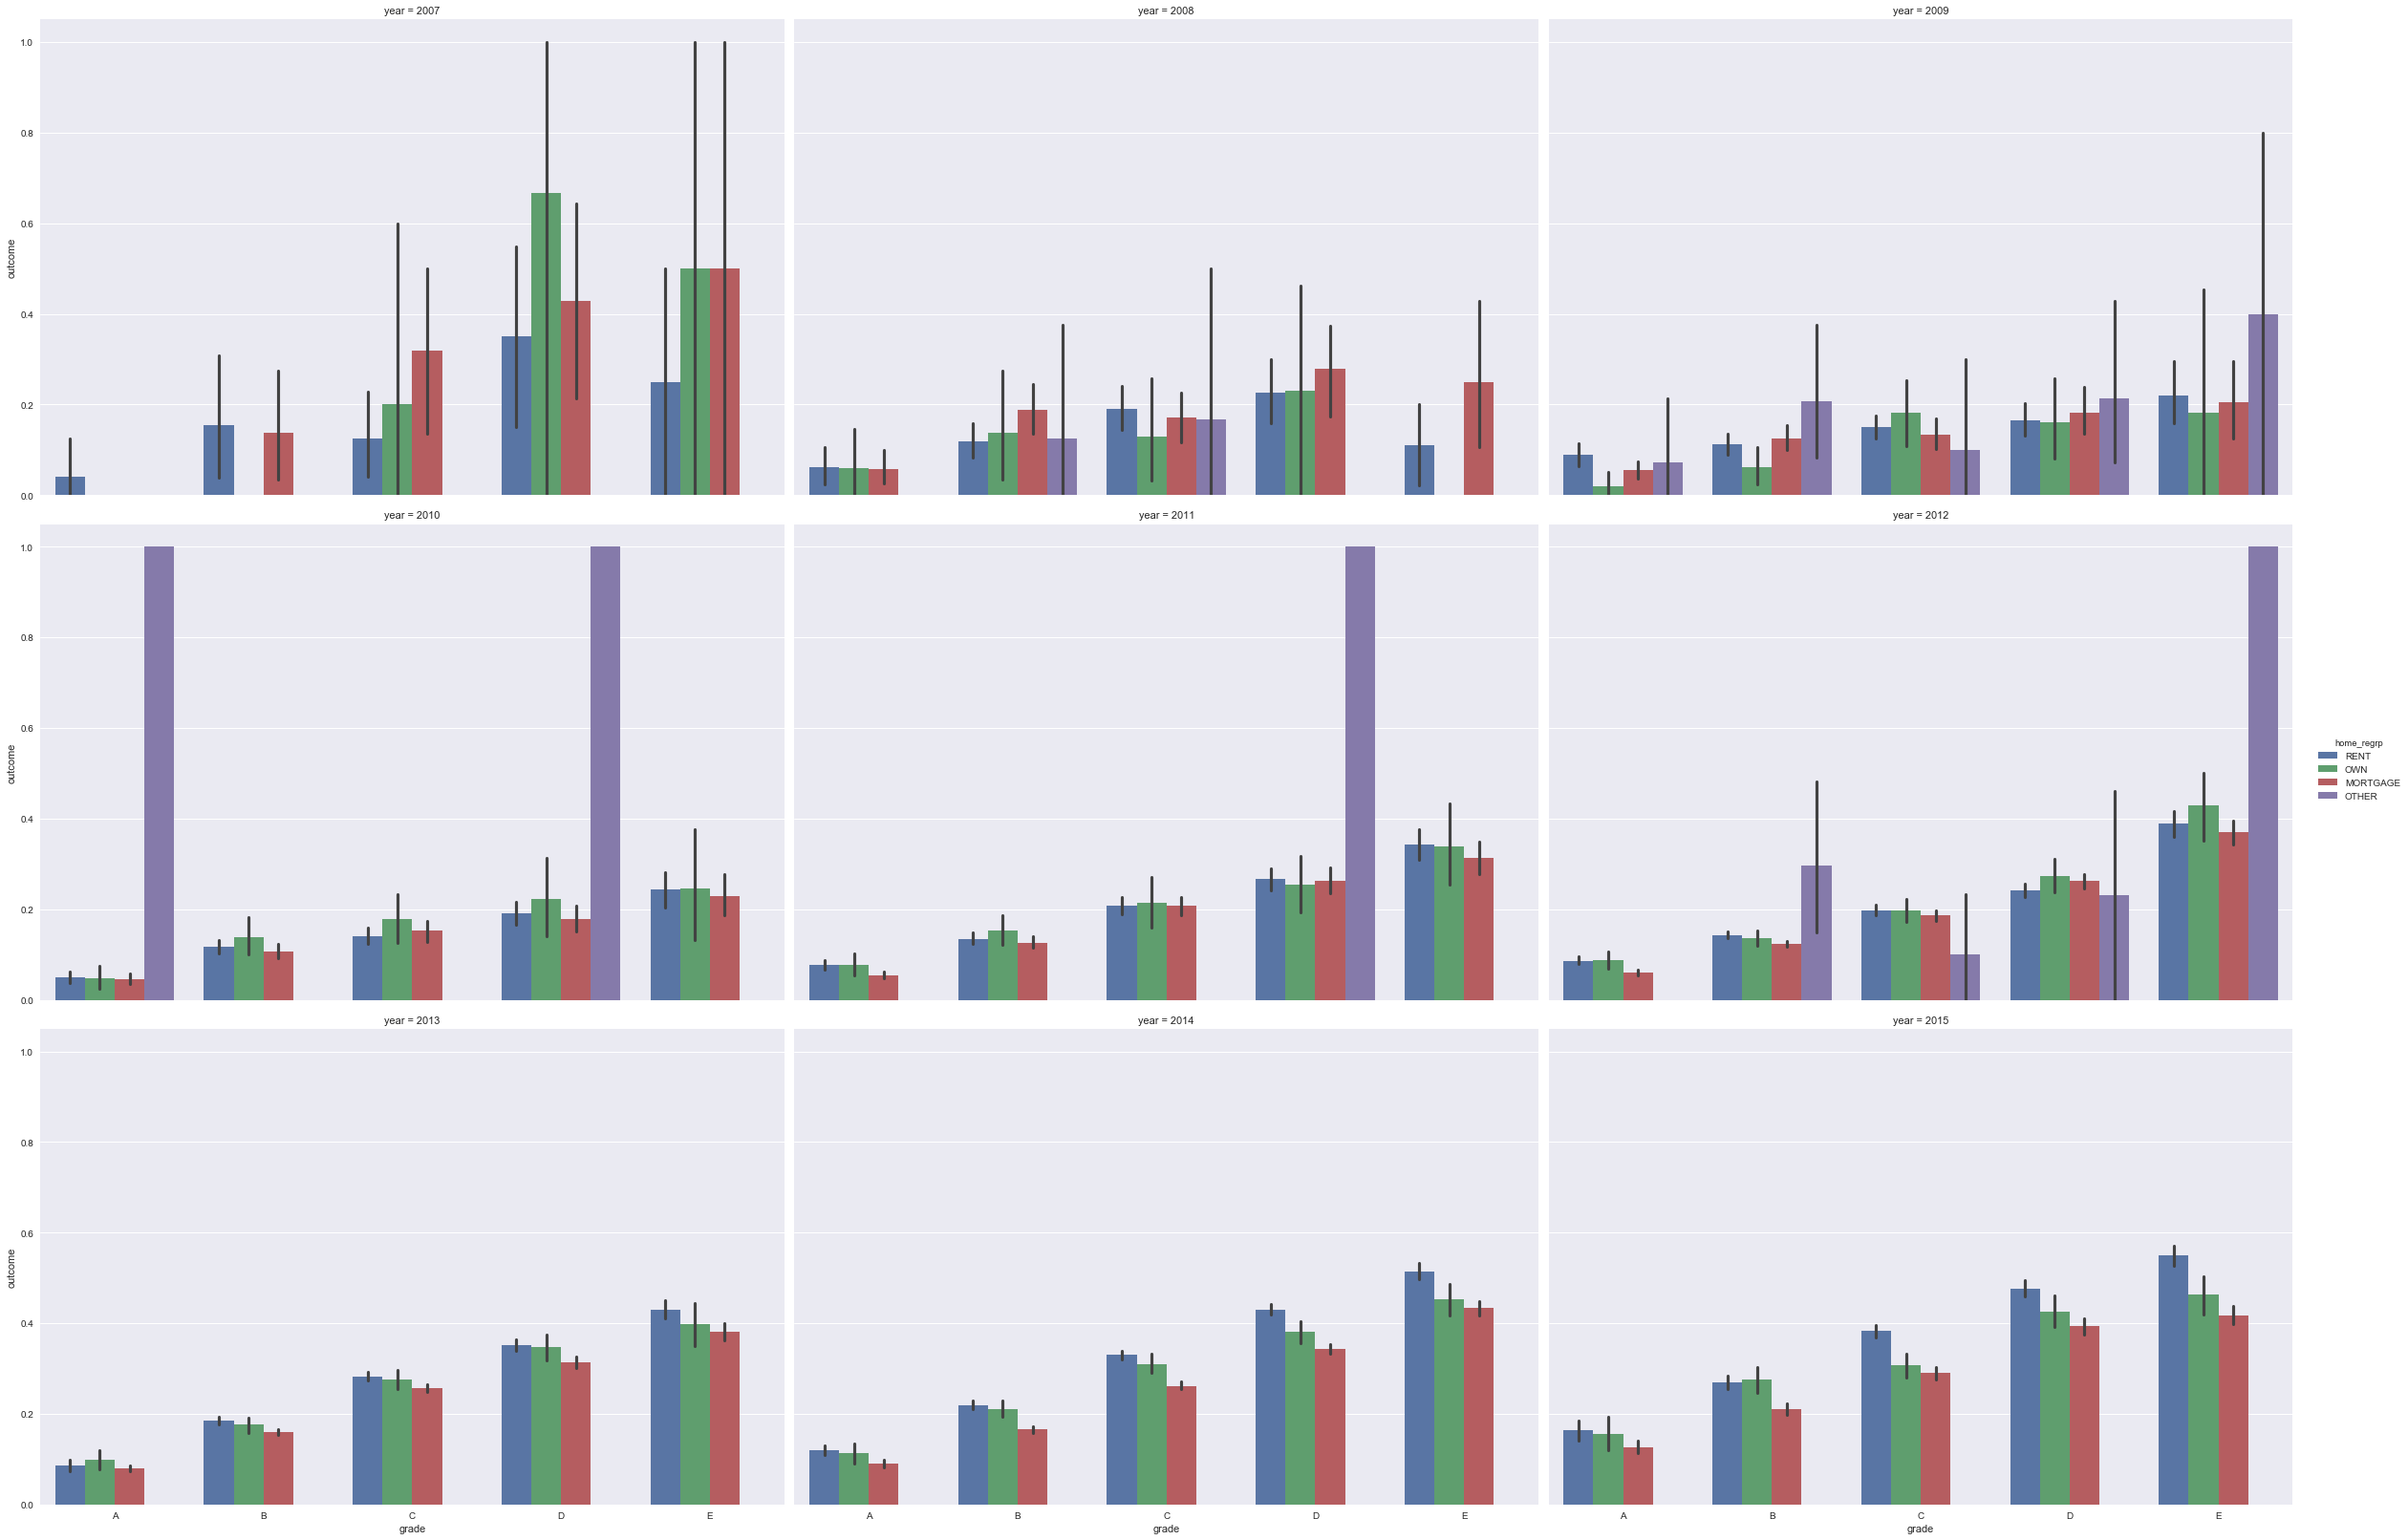

In [7]:

g = sns.factorplot(x='grade', y='outcome', hue='home_regrp', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)


Note: investigate  the "OTHER" category further. on looking further at the category 'OTHER' (notebook 0.31-LC-exploration)
      for years 2010, (Grade A, D) , 2011(Grade D) and 2012(Grade E) there was only one loan under this category and it
      defaulted giving rise to 100% default rate as seen in the default rate =1.
      
      For year 2013-2015 there seems to be a trend to default rate decreasing from rent to own to mortgage for all grades.

## Annual Income

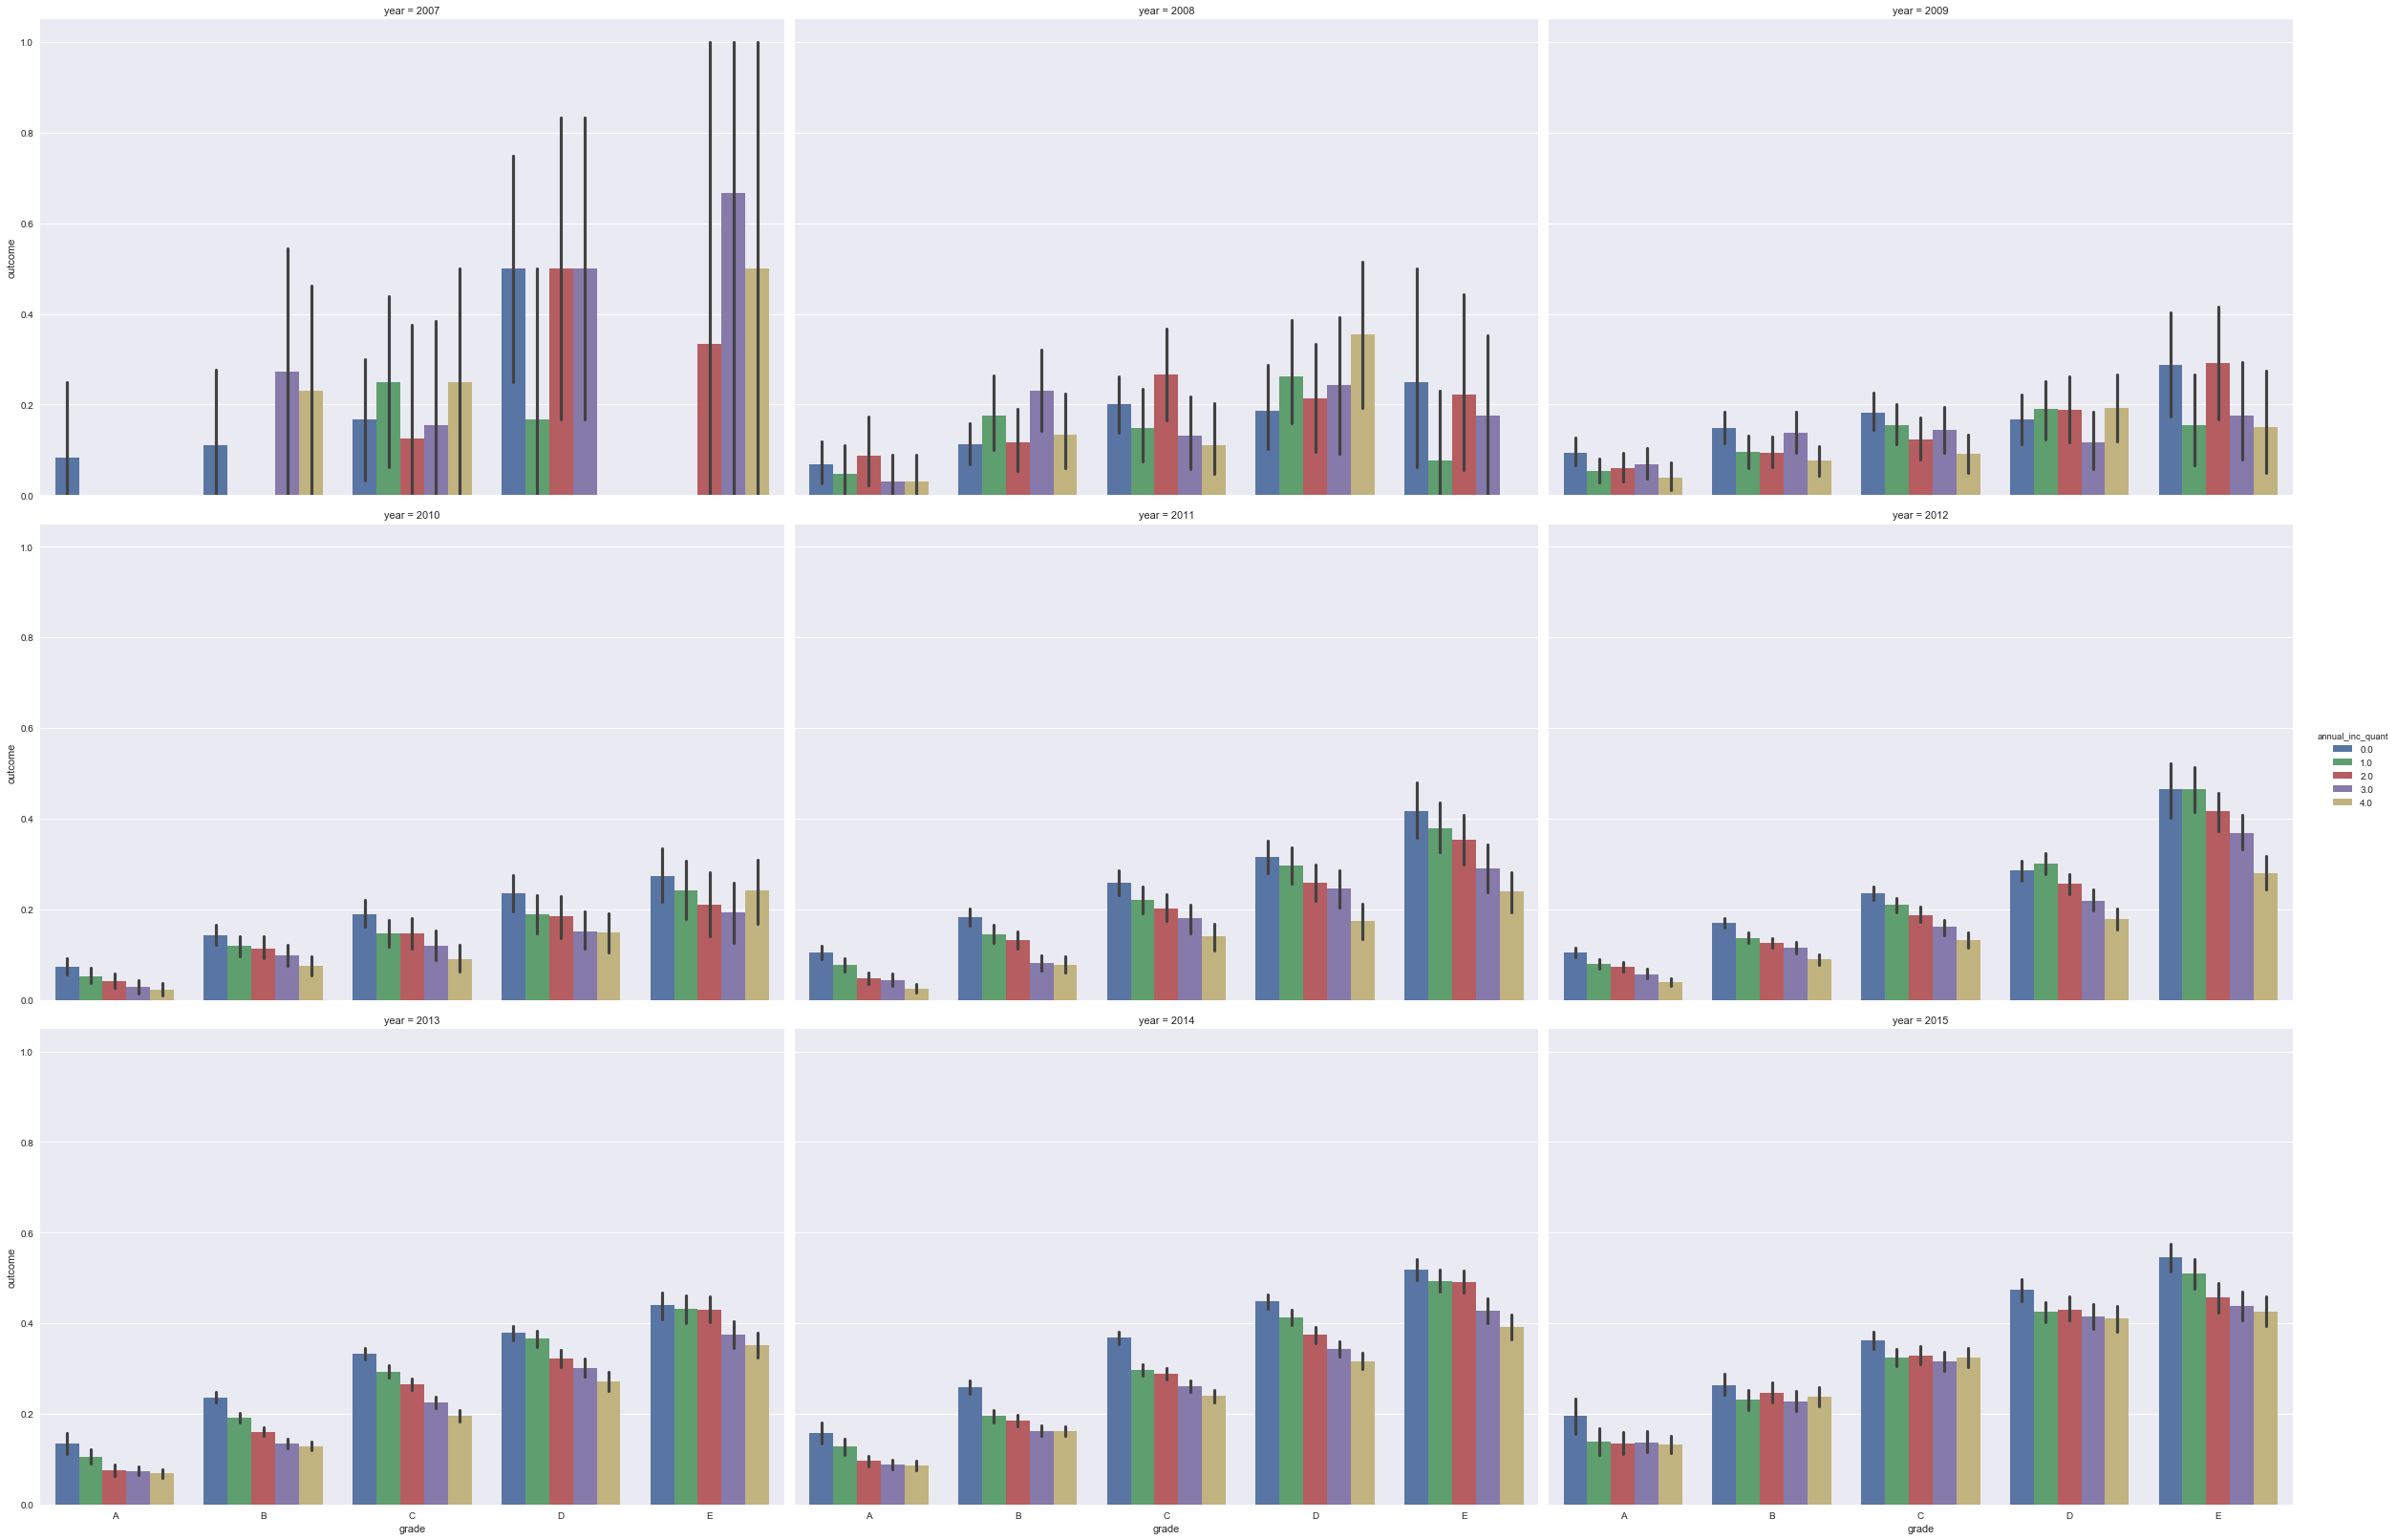

In [8]:

g = sns.factorplot(x='grade', y='outcome', hue='annual_inc_quant', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

For the years 2010-2014 a trend towards percentage deafult decreasing with increasing annual income bracket for all loan grades except for 2010 loan Grade E the highest bracket has a higher rate of default than the fourth and third income brackets. 
[ Note when "ISSUED was included in Default group. In 2015, the same decreasing trend is seen for loan grade E, but for the other grades it is not as marked. Even for this year teh highest default rate is for the lowest annual income bracket for all loan grades.] Now for the year 2015 whilst for loan grade e the trend steeper it is more a jump for the other grades from the lowest categories having more default to the other categories being comparable to each other. 



# Number of Derogatory Public Records:
   


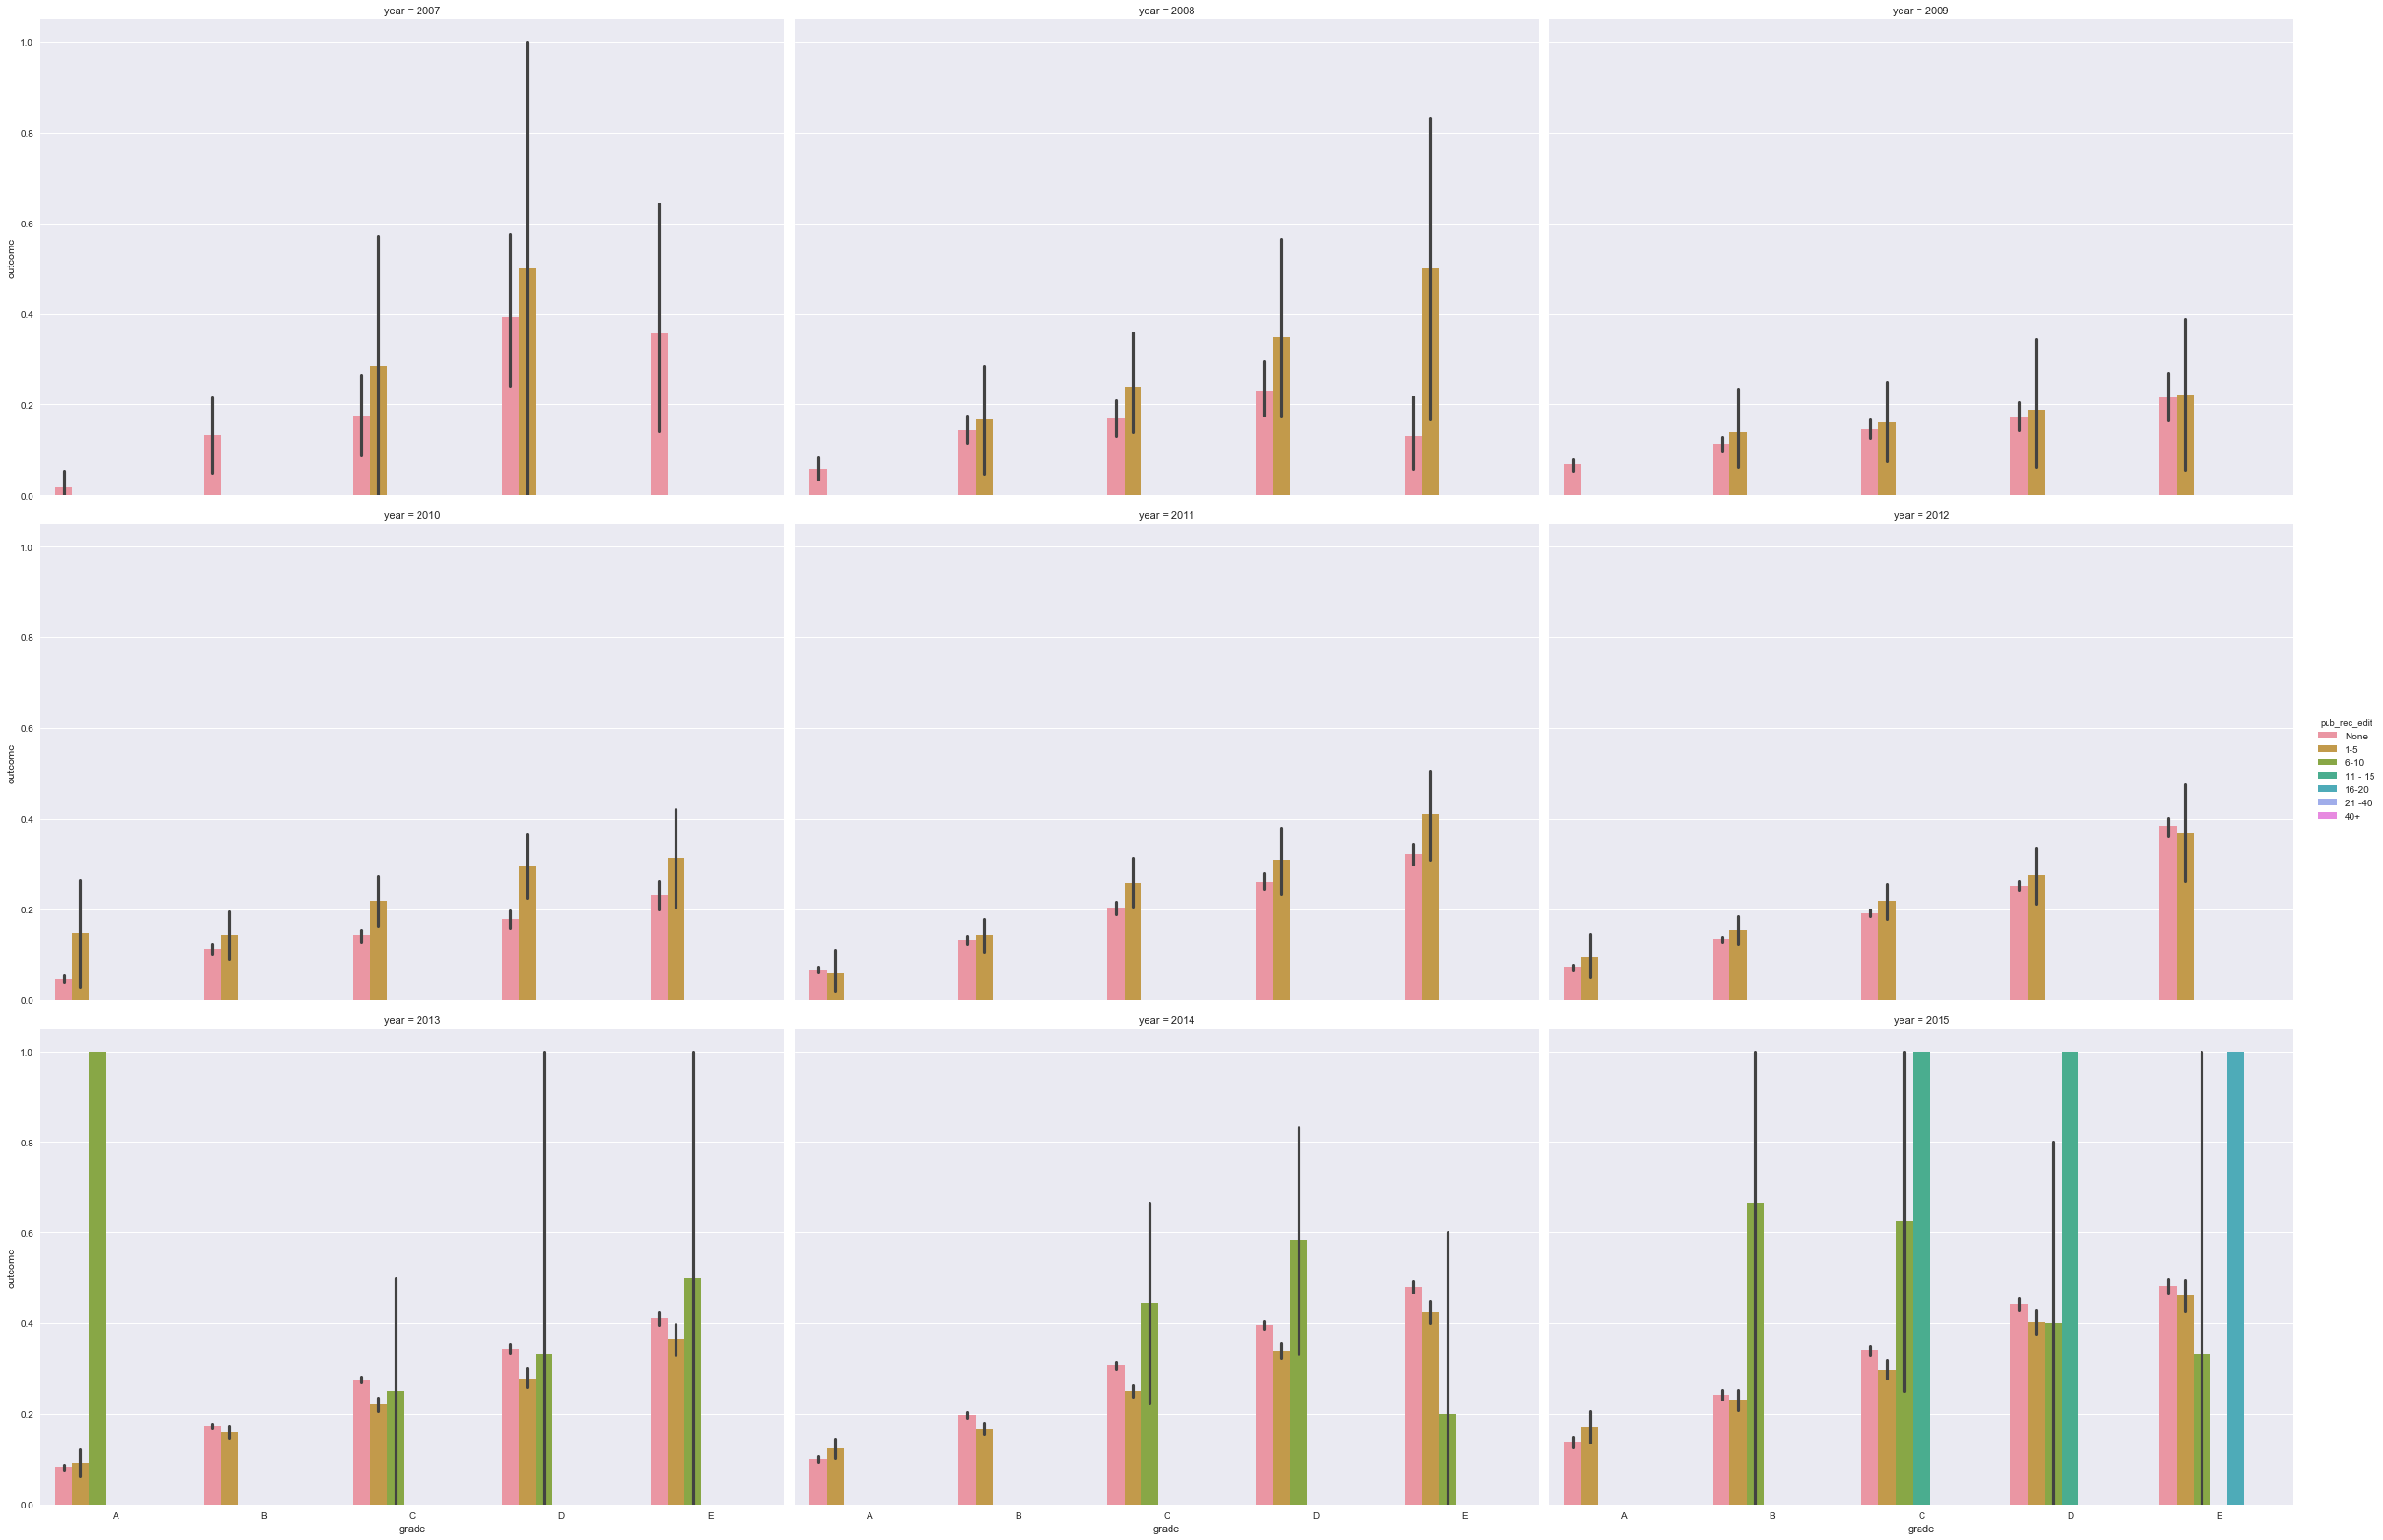

In [9]:
g = sns.factorplot(x='grade', y='outcome', hue='pub_rec_edit', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

Upto Year 2012 the maximum number of derogatory records are upto 5. ( none or upto 5). For 2013 and 2014 it goes upto 10.
For these two years excepting for loans grade A ,the other loan grades show a lower rate of default for those with a derogatory record of 1 -5 vs. those without. In 2015 it appears that there are loans issued that have derogatory records as much as 15.
Here too the same trend of those with 1-5 derogatory records have a mariginally lower percentage of default than those with no record but it is much higher for those with more than 5 derogatory records. 


# Length of Credit History

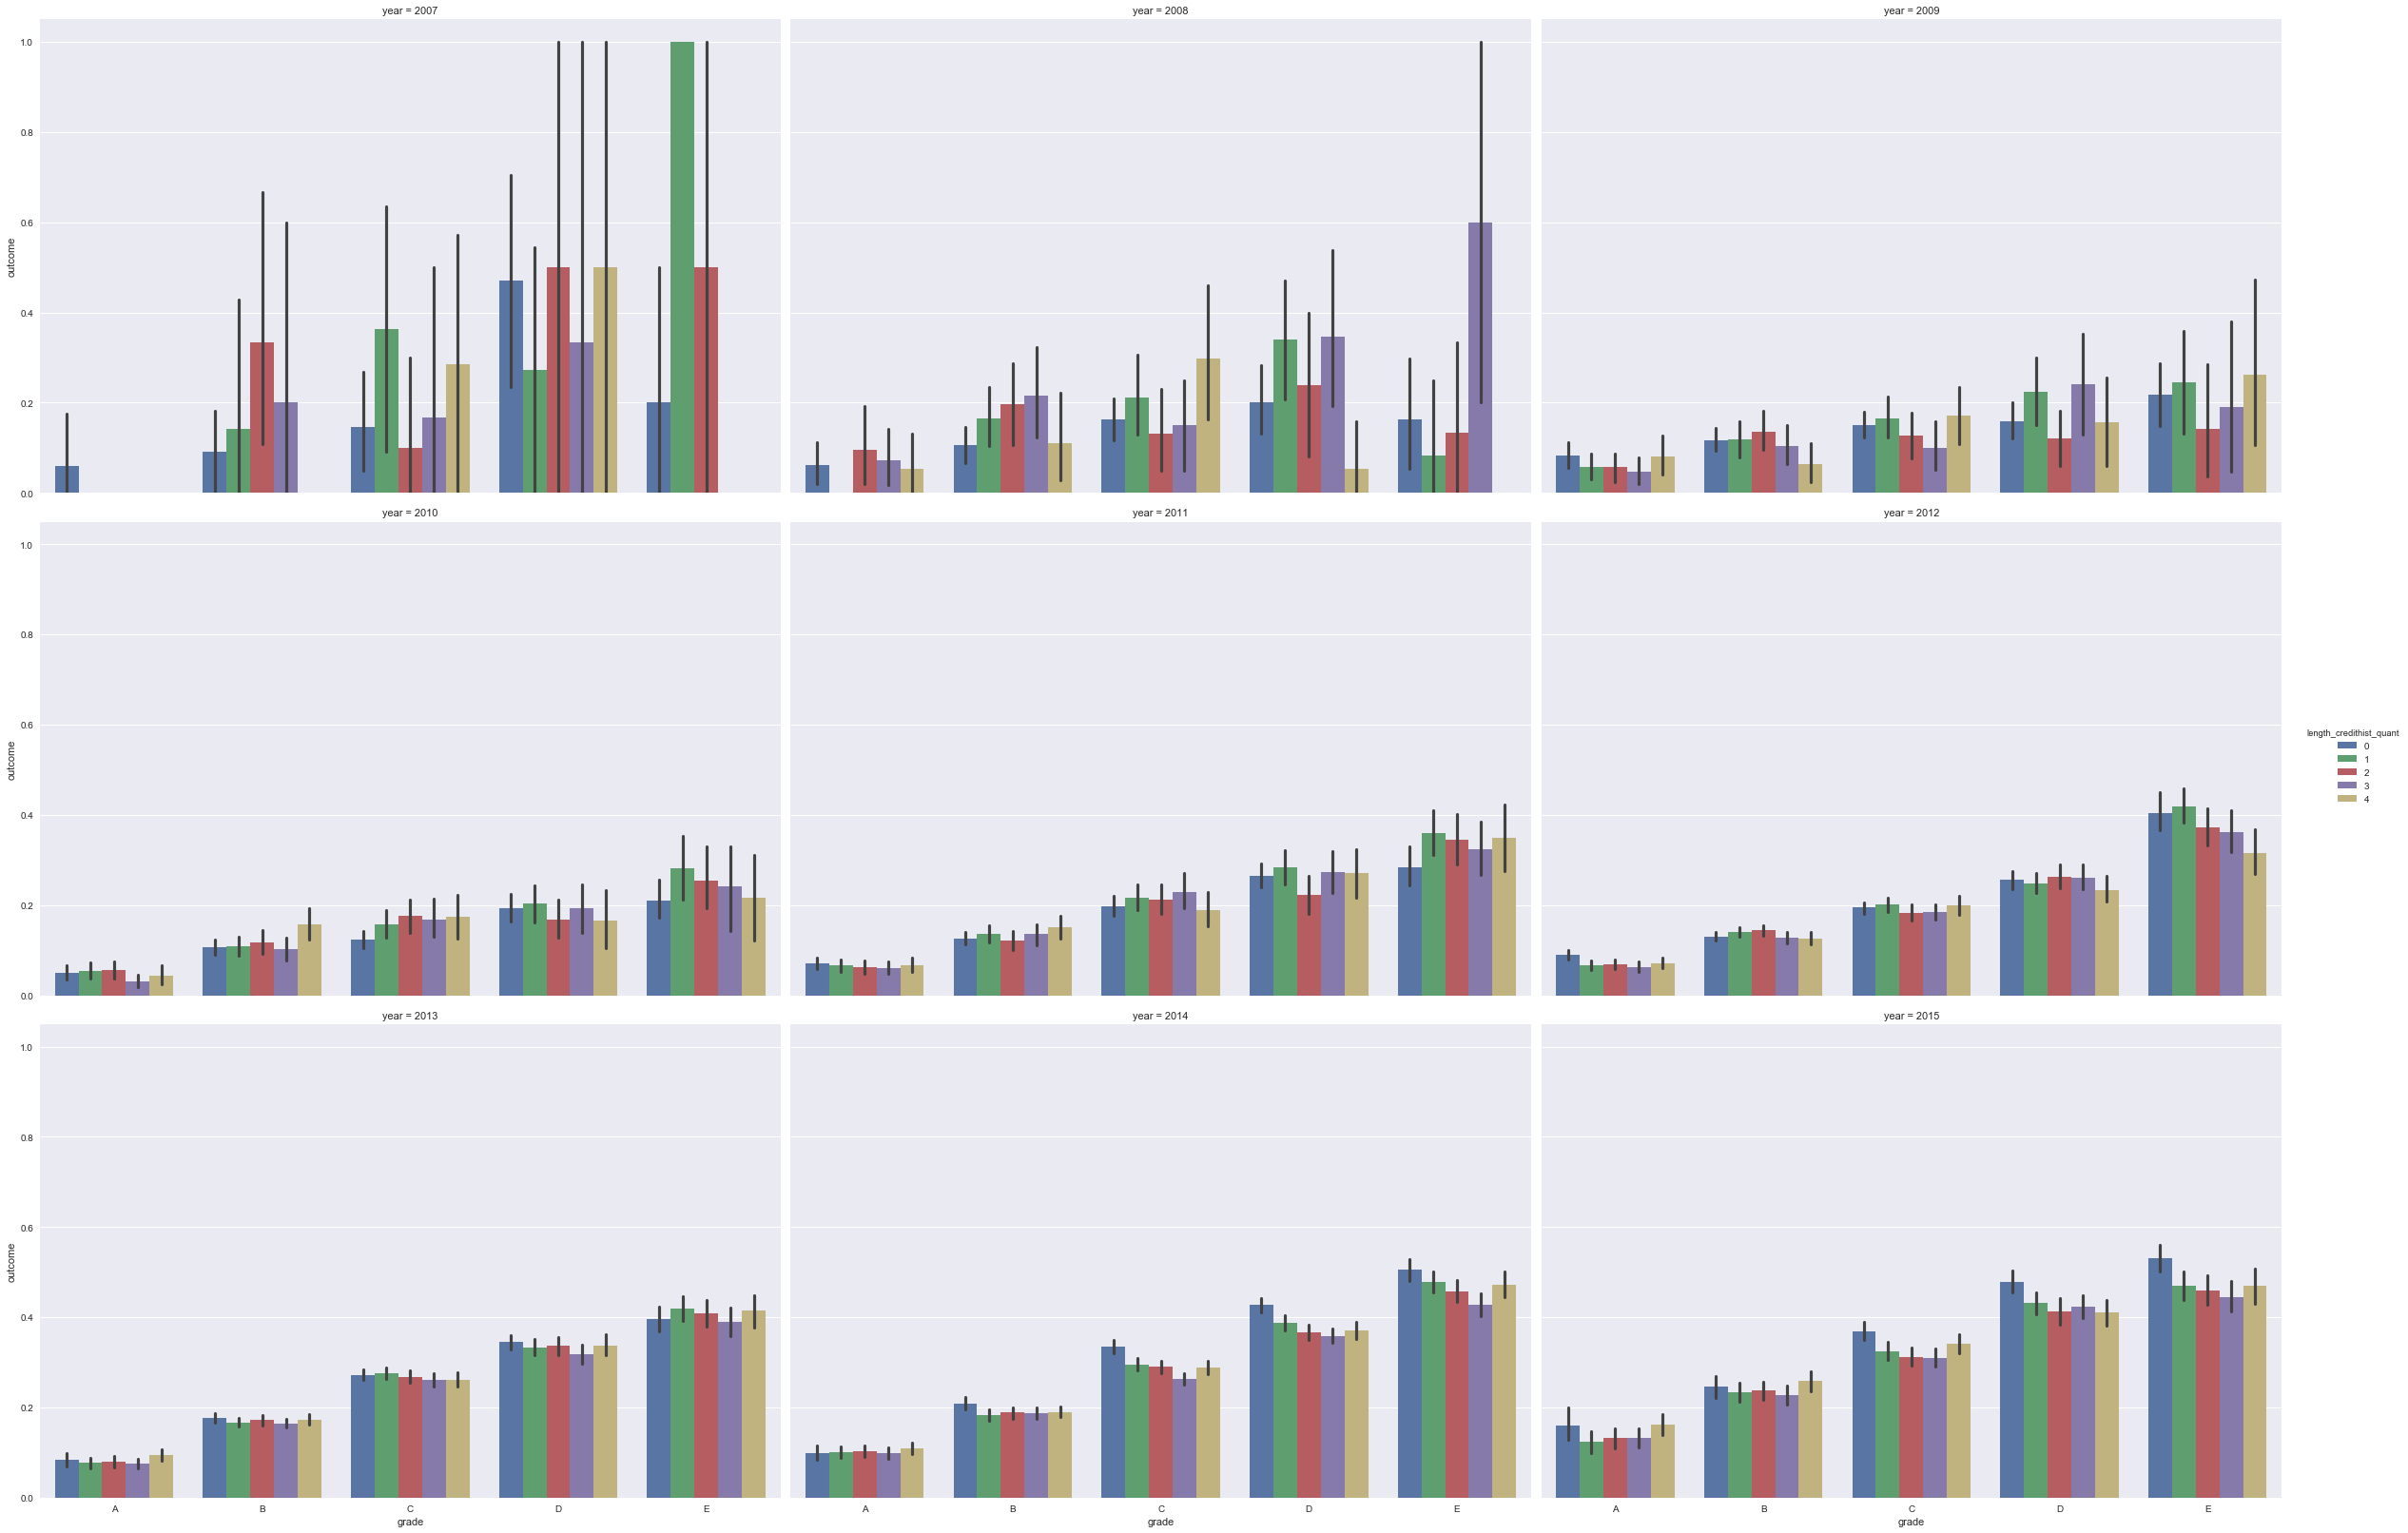

In [10]:

g = sns.factorplot(x='grade', y='outcome', hue='length_credithist_quant', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

The impact on the percent default rate by the length of credit history for the higher Loan Grades in the  years 2011- 2015
may show a  default rate decrease with increase in length. This same trend is not seen in the Loan grades A nd B for 
these same years. For the years 2013 -2015 for the grades C, D ad E the quantile with the highest length shows an increase in 
the rate of default as compares to the quantile before it. 




# The number of open credit lines in the borrowers credit file.

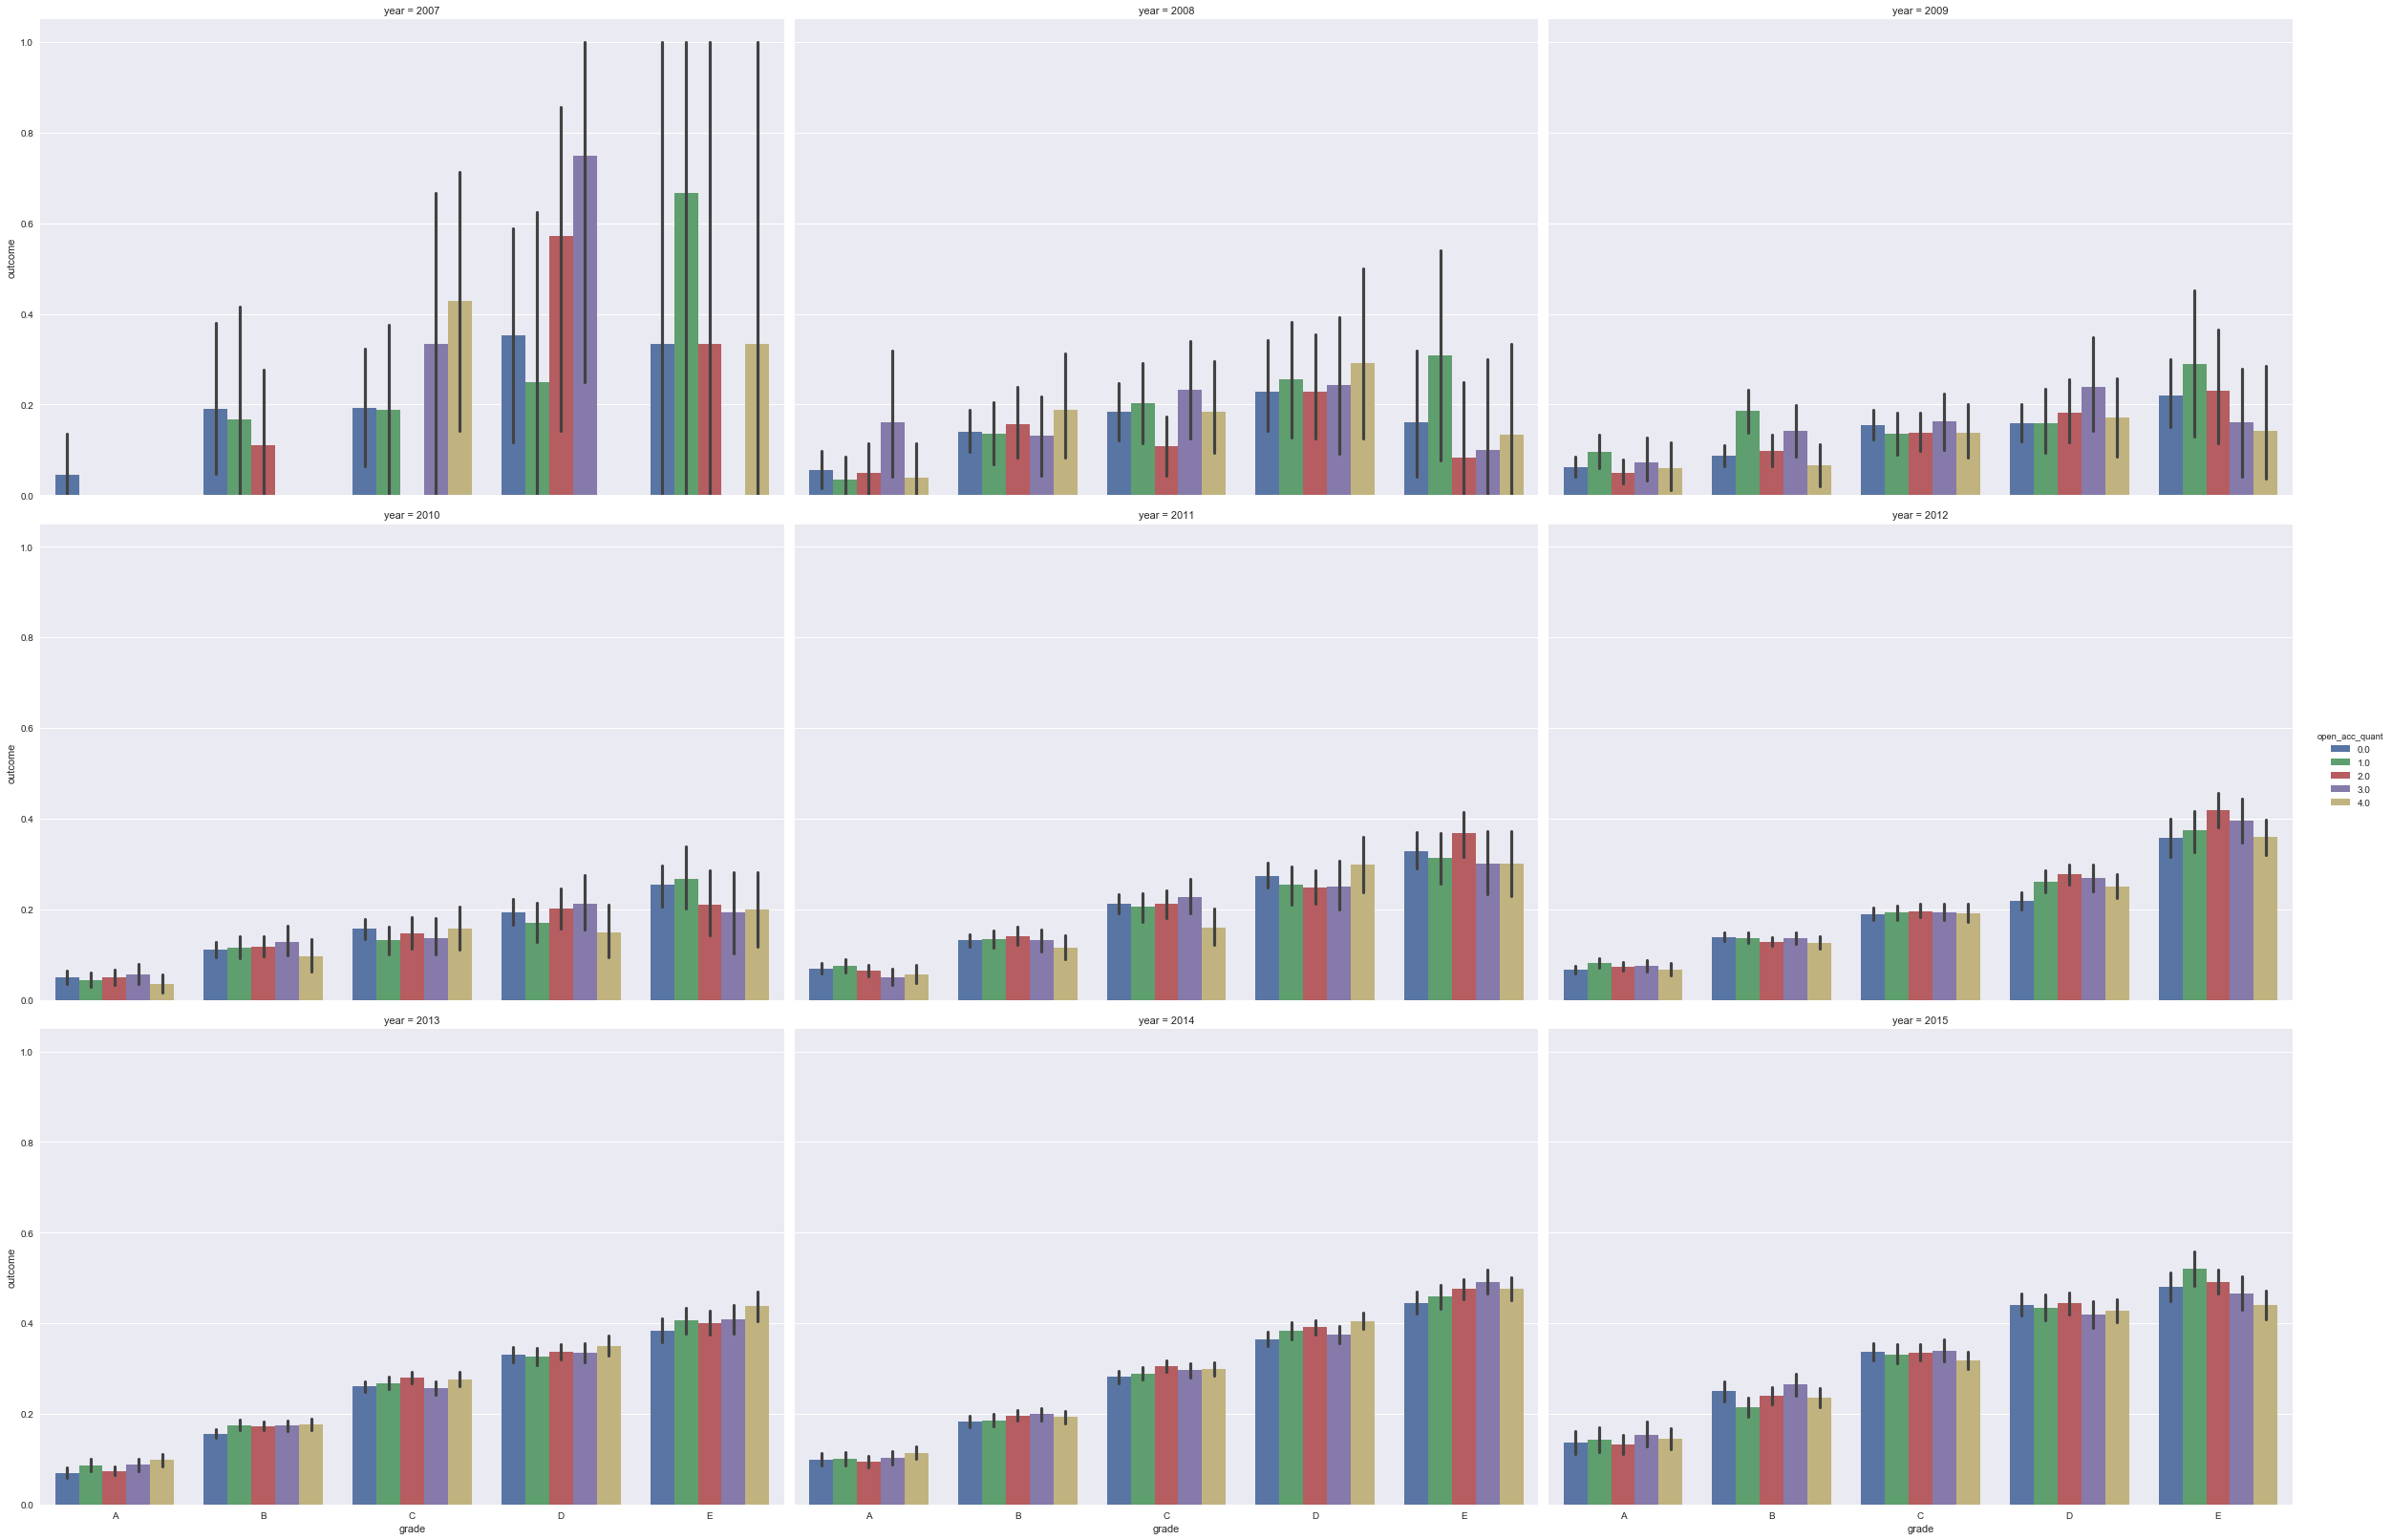

In [11]:
g = sns.factorplot(x='grade', y='outcome', hue='open_acc_quant', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

The number of open credit lines does not seem to have an impact on the grade A and B loans for the years 2010 through 2014.
 [Note when "ISSUED was included in Default group. For the year 2015 slight increasing trend is seen for quantile 1-4 and no open credit lines being more that a single open credit line.] An increasing trend is seen in  2014 Grade E loans but a decreasing trend for the same grade in 2015.

 # The total number of credit lines currently in the borrowers credit file

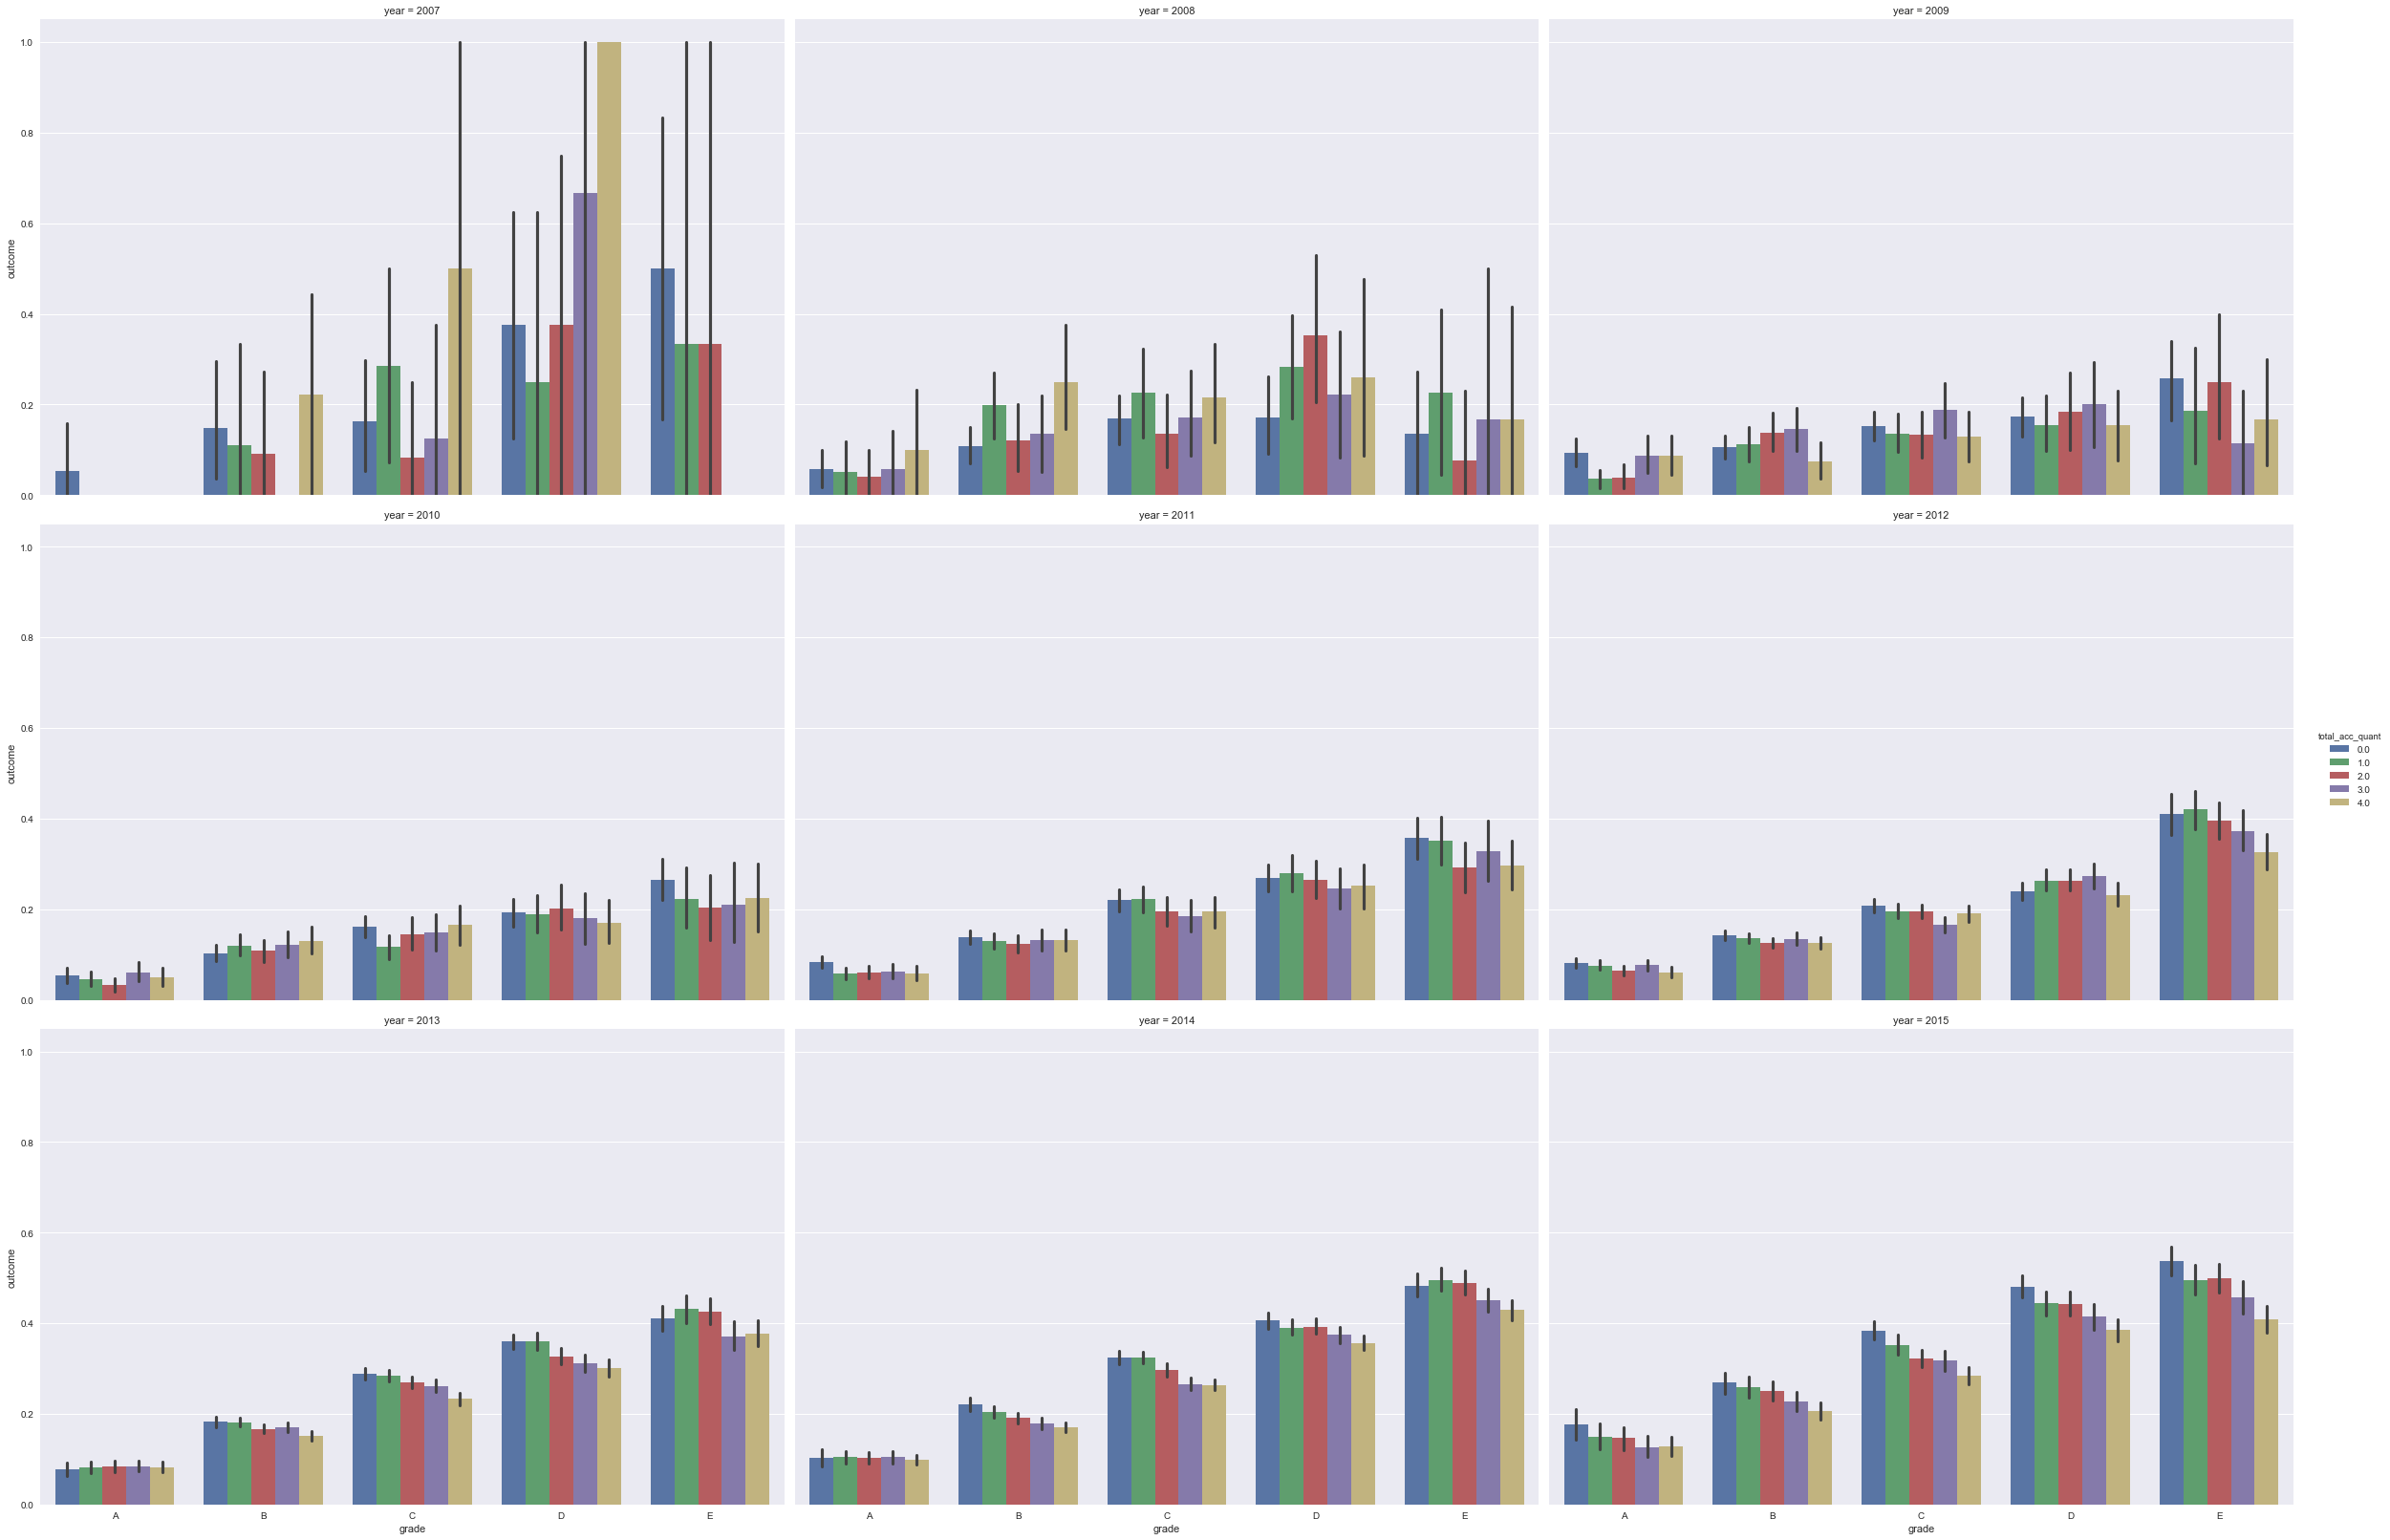

In [12]:
g = sns.factorplot(x='grade', y='outcome', hue='total_acc_quant', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

The total number of credit lines seem to not impact grade A loans for the years 2012-2014. In 2015 for all grades higher the 
total number of credit lines lower the rate of default.In 2014 thisholds for loan grades B- E and in 2013 for Grades C-E.
In 2012, it holds for grade E.

# Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

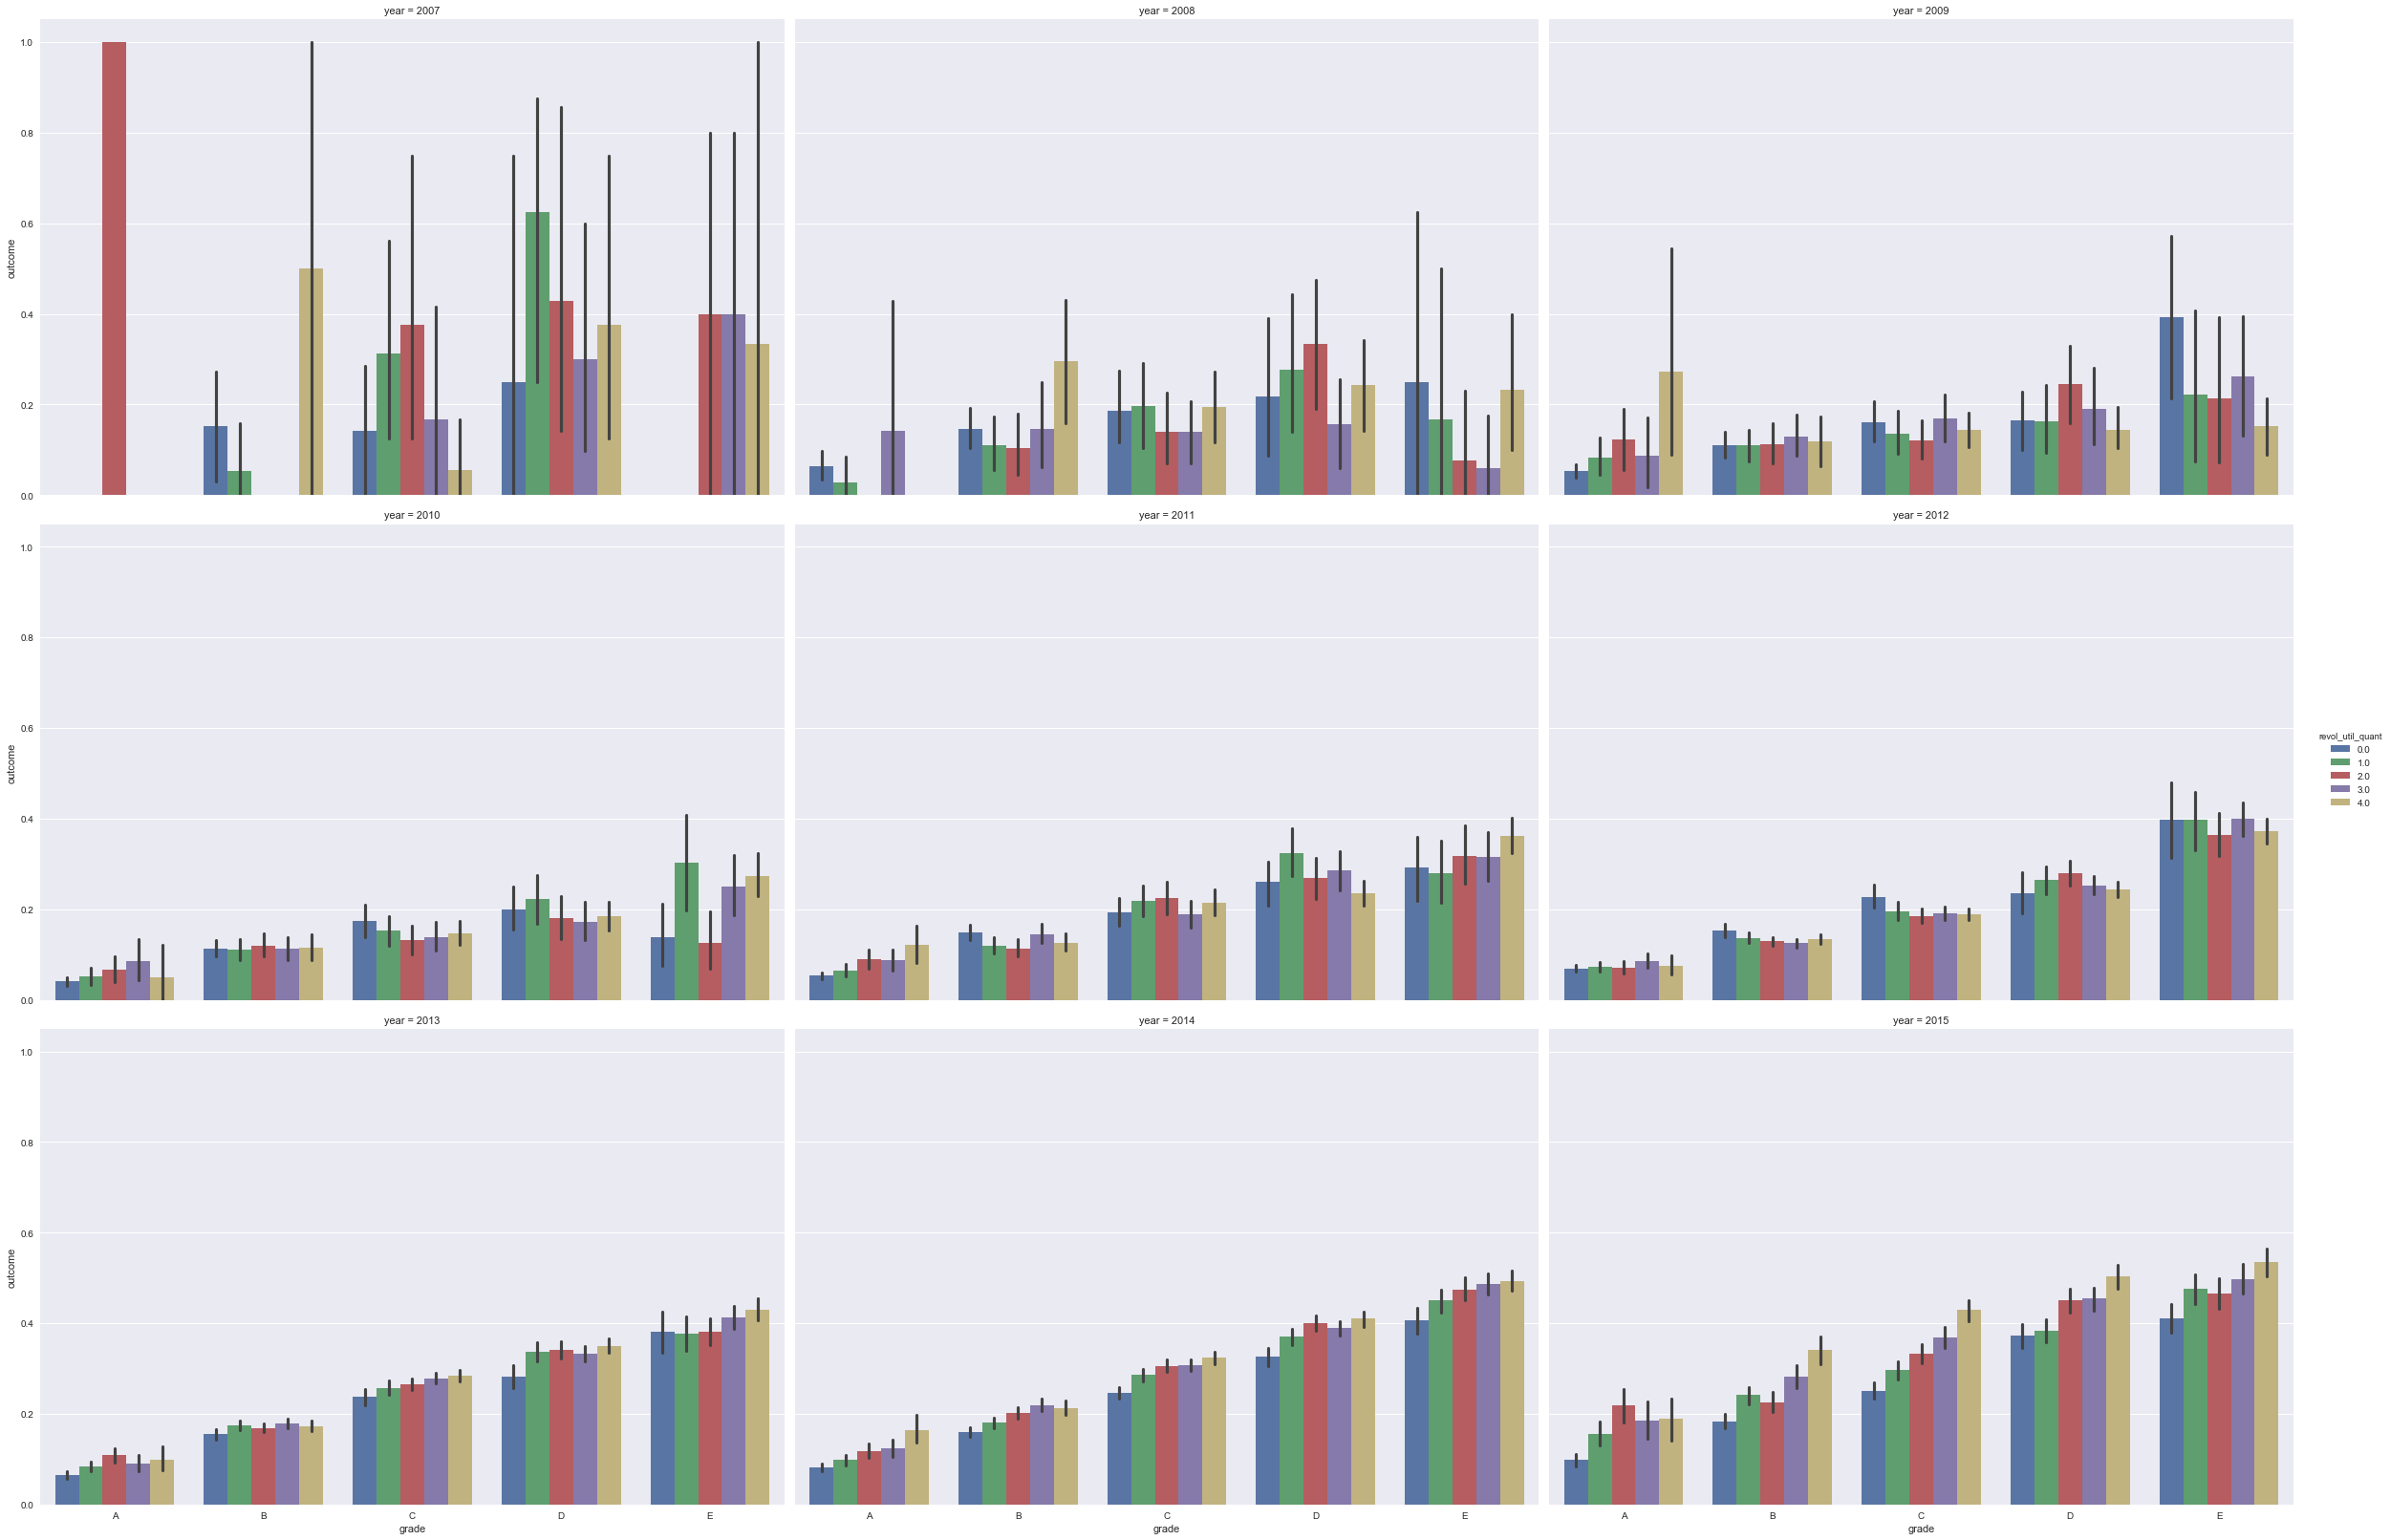

In [13]:
g = sns.factorplot(x='grade', y='outcome', hue='revol_util_quant', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

The revolving line untilization rate seems to increase with the increase in the quantile for the year 2014  for all grades.
For the year 2015 for grades B-E. For the prior years the trend is more variable.

# Total credit revolving balance

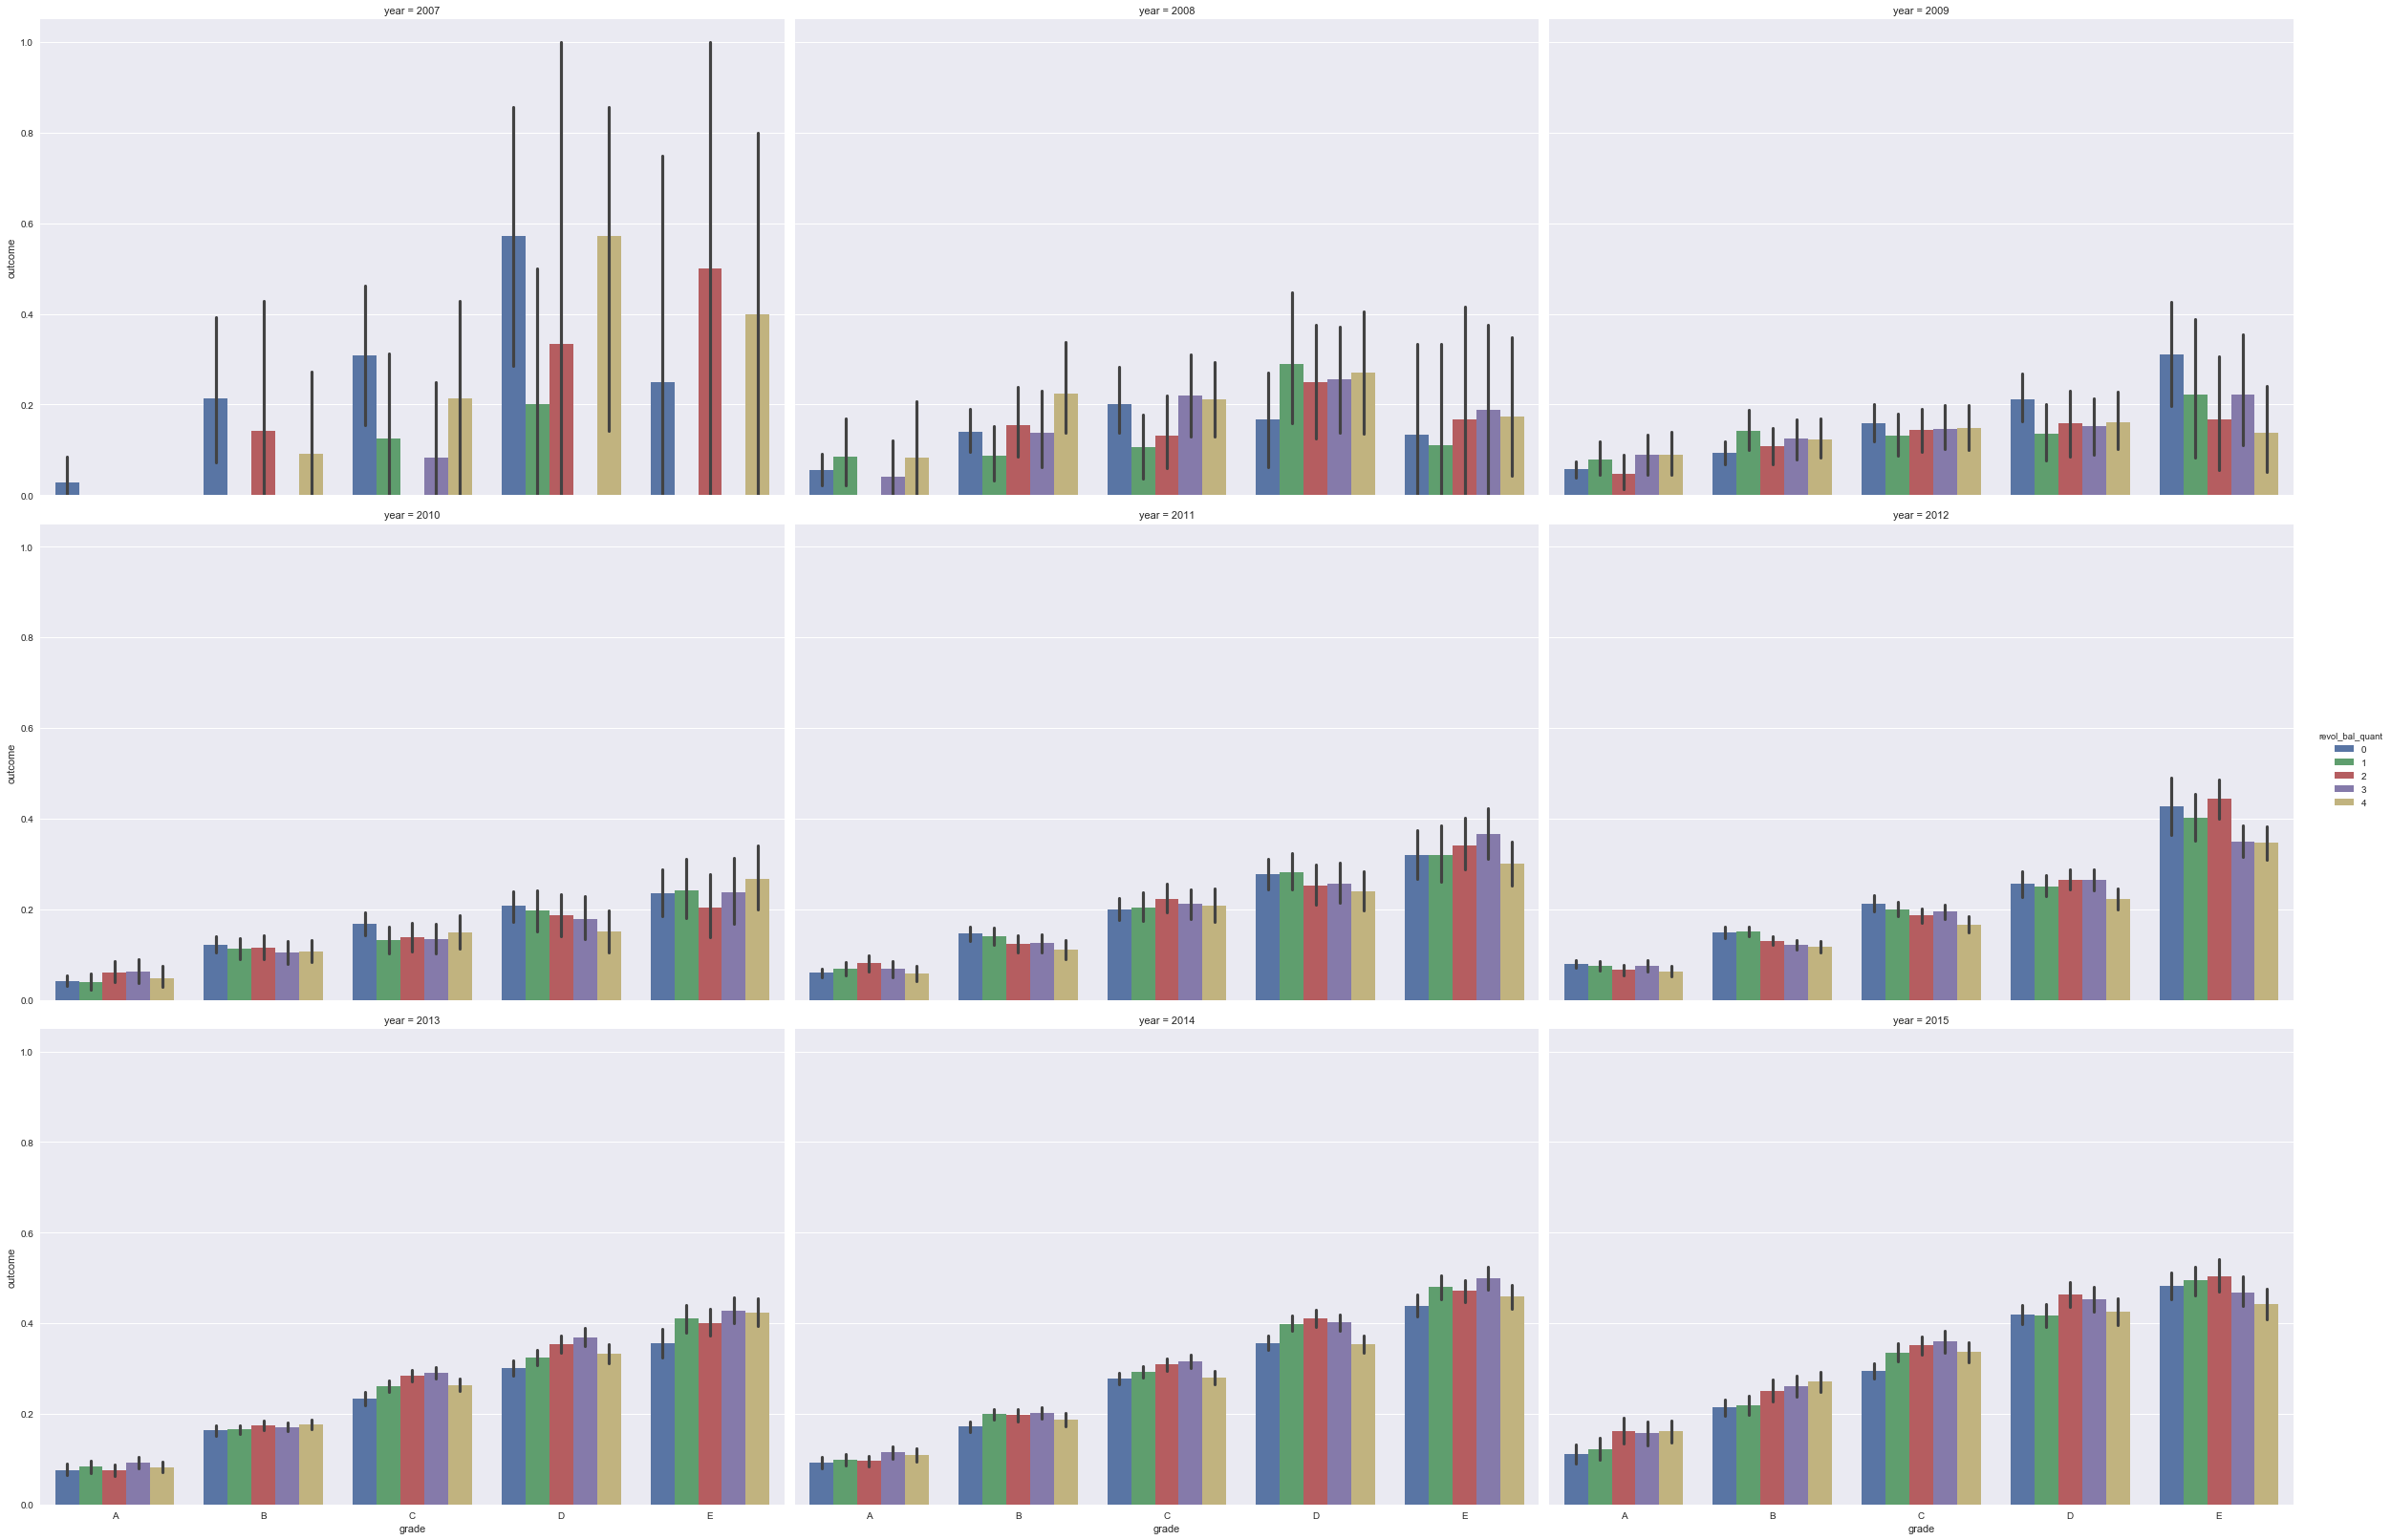

In [14]:
g = sns.factorplot(x='grade', y='outcome', hue='revol_bal_quant', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

The default rate appears to show an increasing trend with the increase in the total credit revolving balance quantile upto 3 for the year 2015 for all grades. For 2013 and 2014 for grades C-E it holds for upto 3.

# DTI: A ratio calculated using the borrowers total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrowers self-reported monthly income.

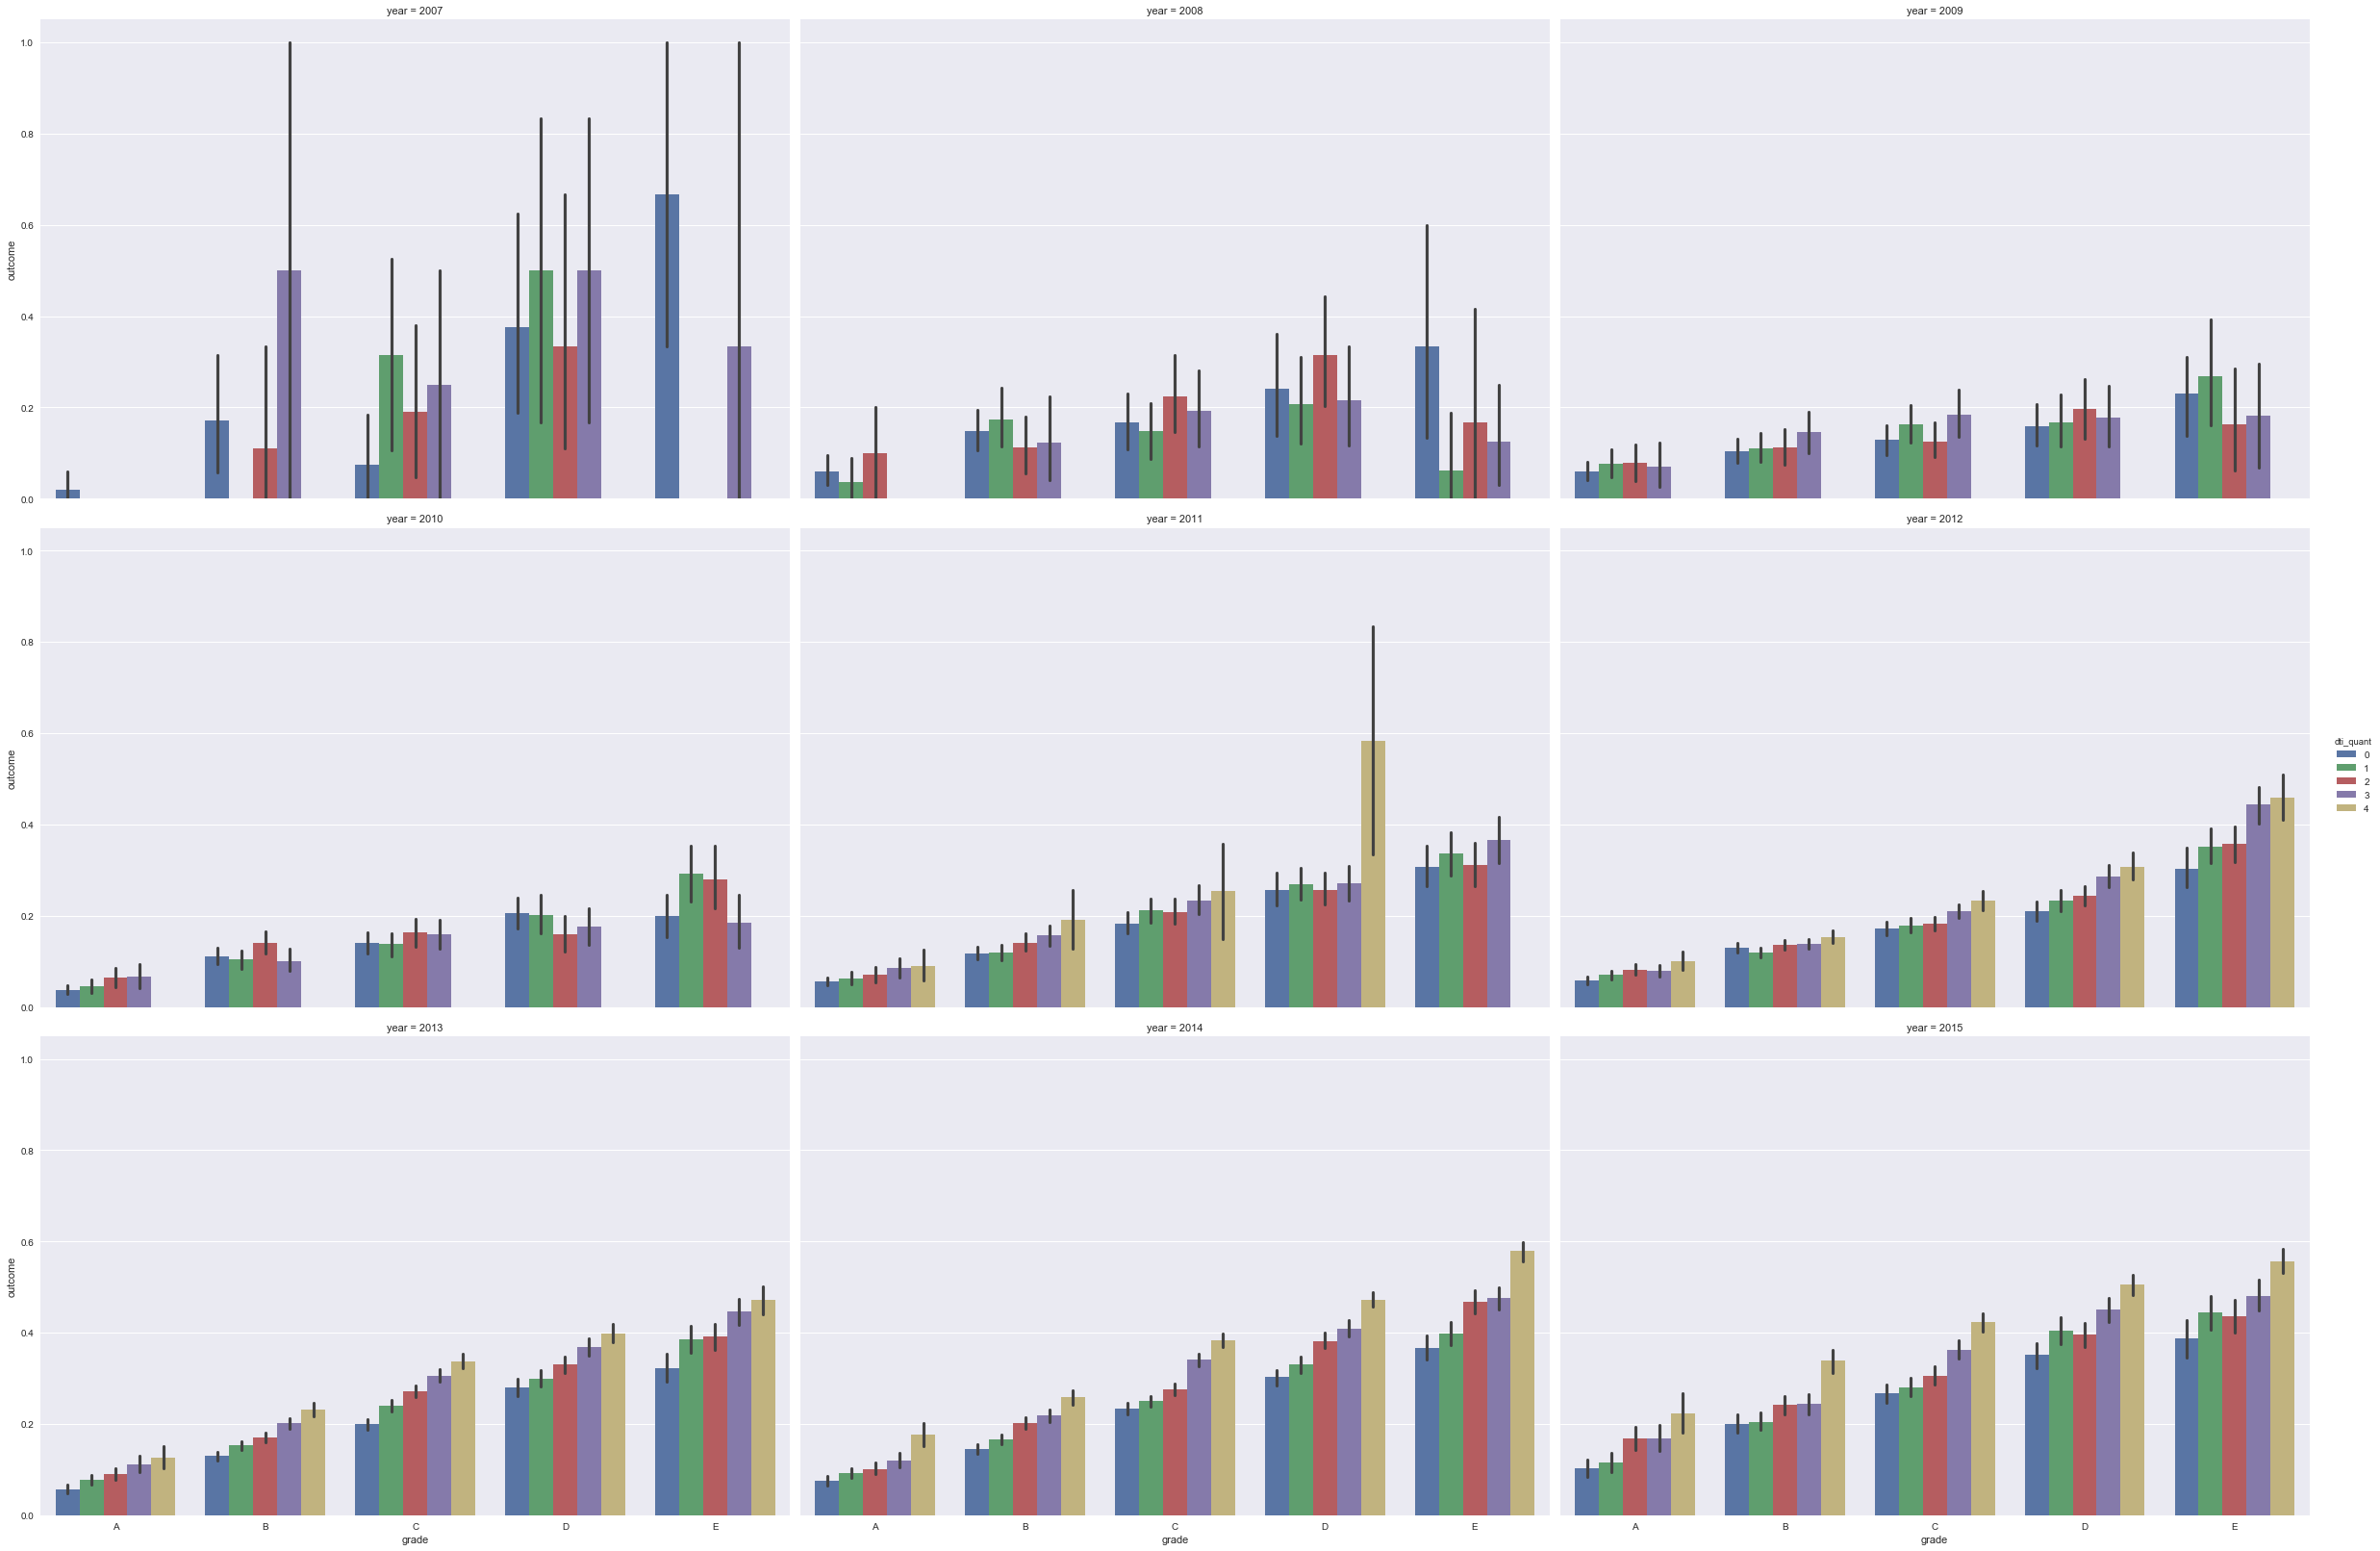

In [15]:
g = sns.factorplot(x='grade', y='outcome', hue='dti_quant', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

AN increase in default rate with increase in DTI is seen for all grades in the years 2011 through 2015.

# The number of inquiries by creditors during the past 6 months.

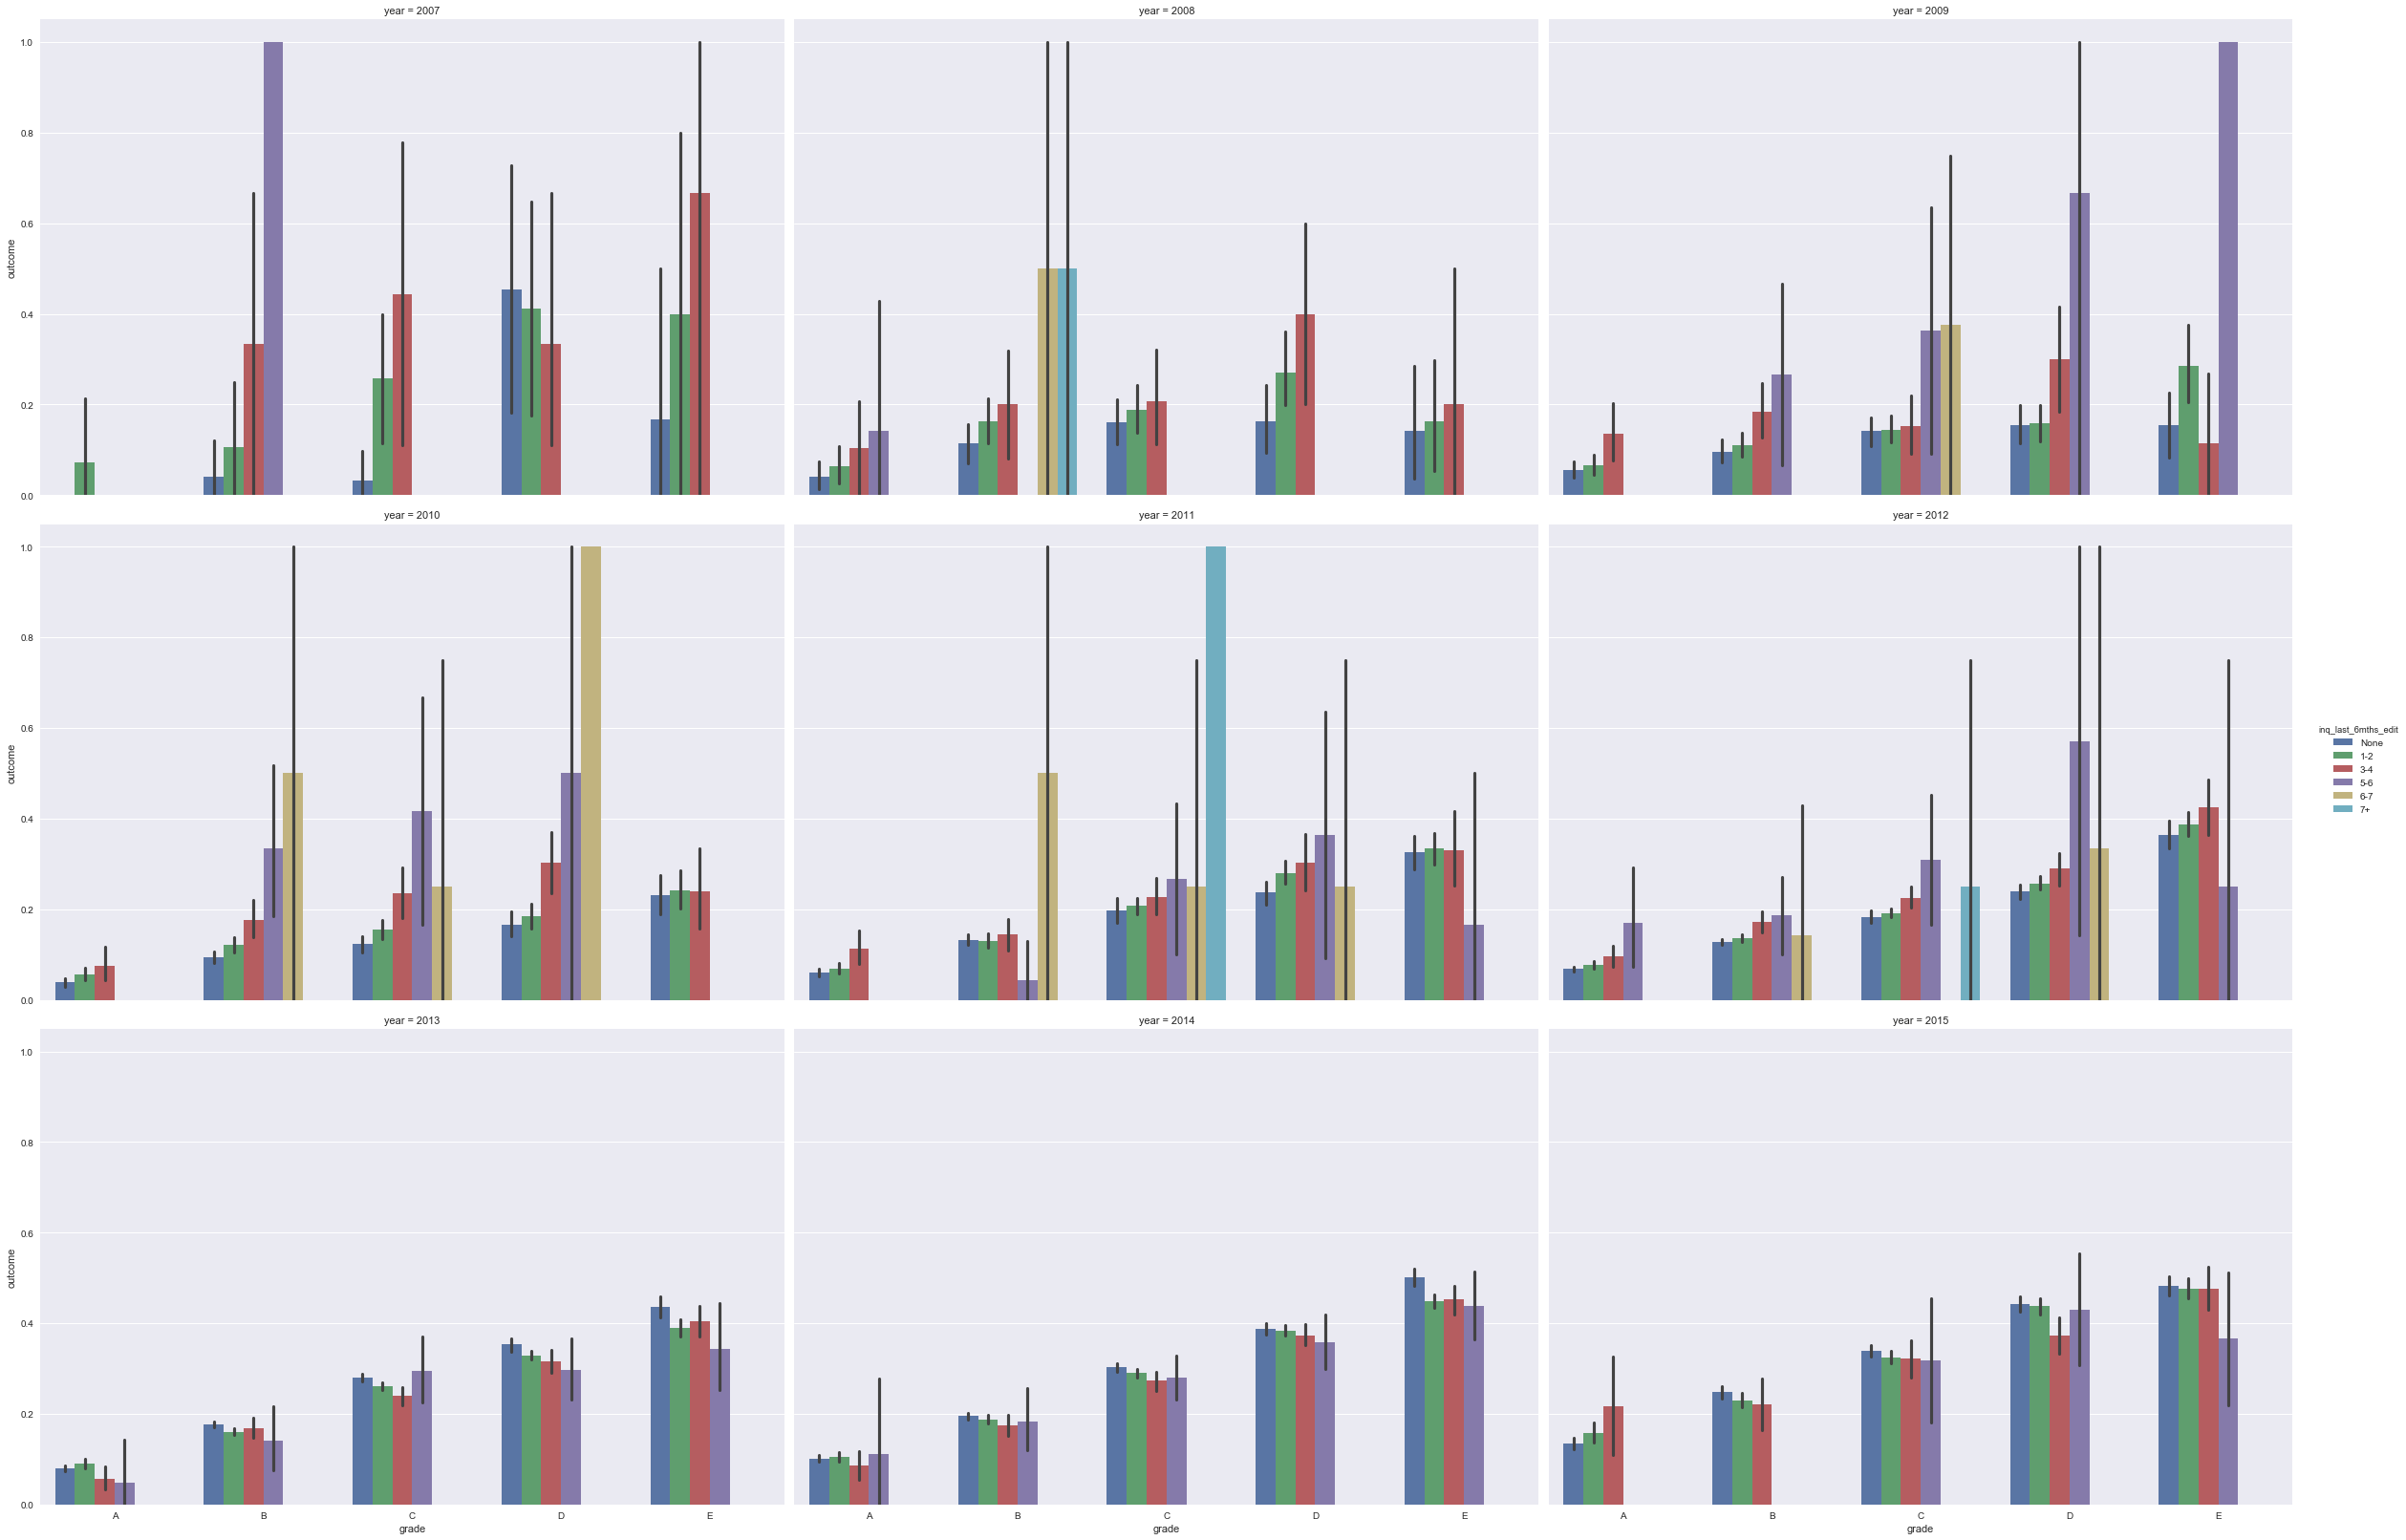

In [16]:
g = sns.factorplot(x='grade', y='outcome', hue='inq_last_6mths_edit', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar',
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

The rate of default in relation to the number of inquiries by creditors in the past six months seems to increase in the years 
2010-1012 for all grades but is not so for 2013-2015. May even be a decrease.

# The number of 30+ days past-due incidences of delinquency in the borrowers credit file for the past 2 years

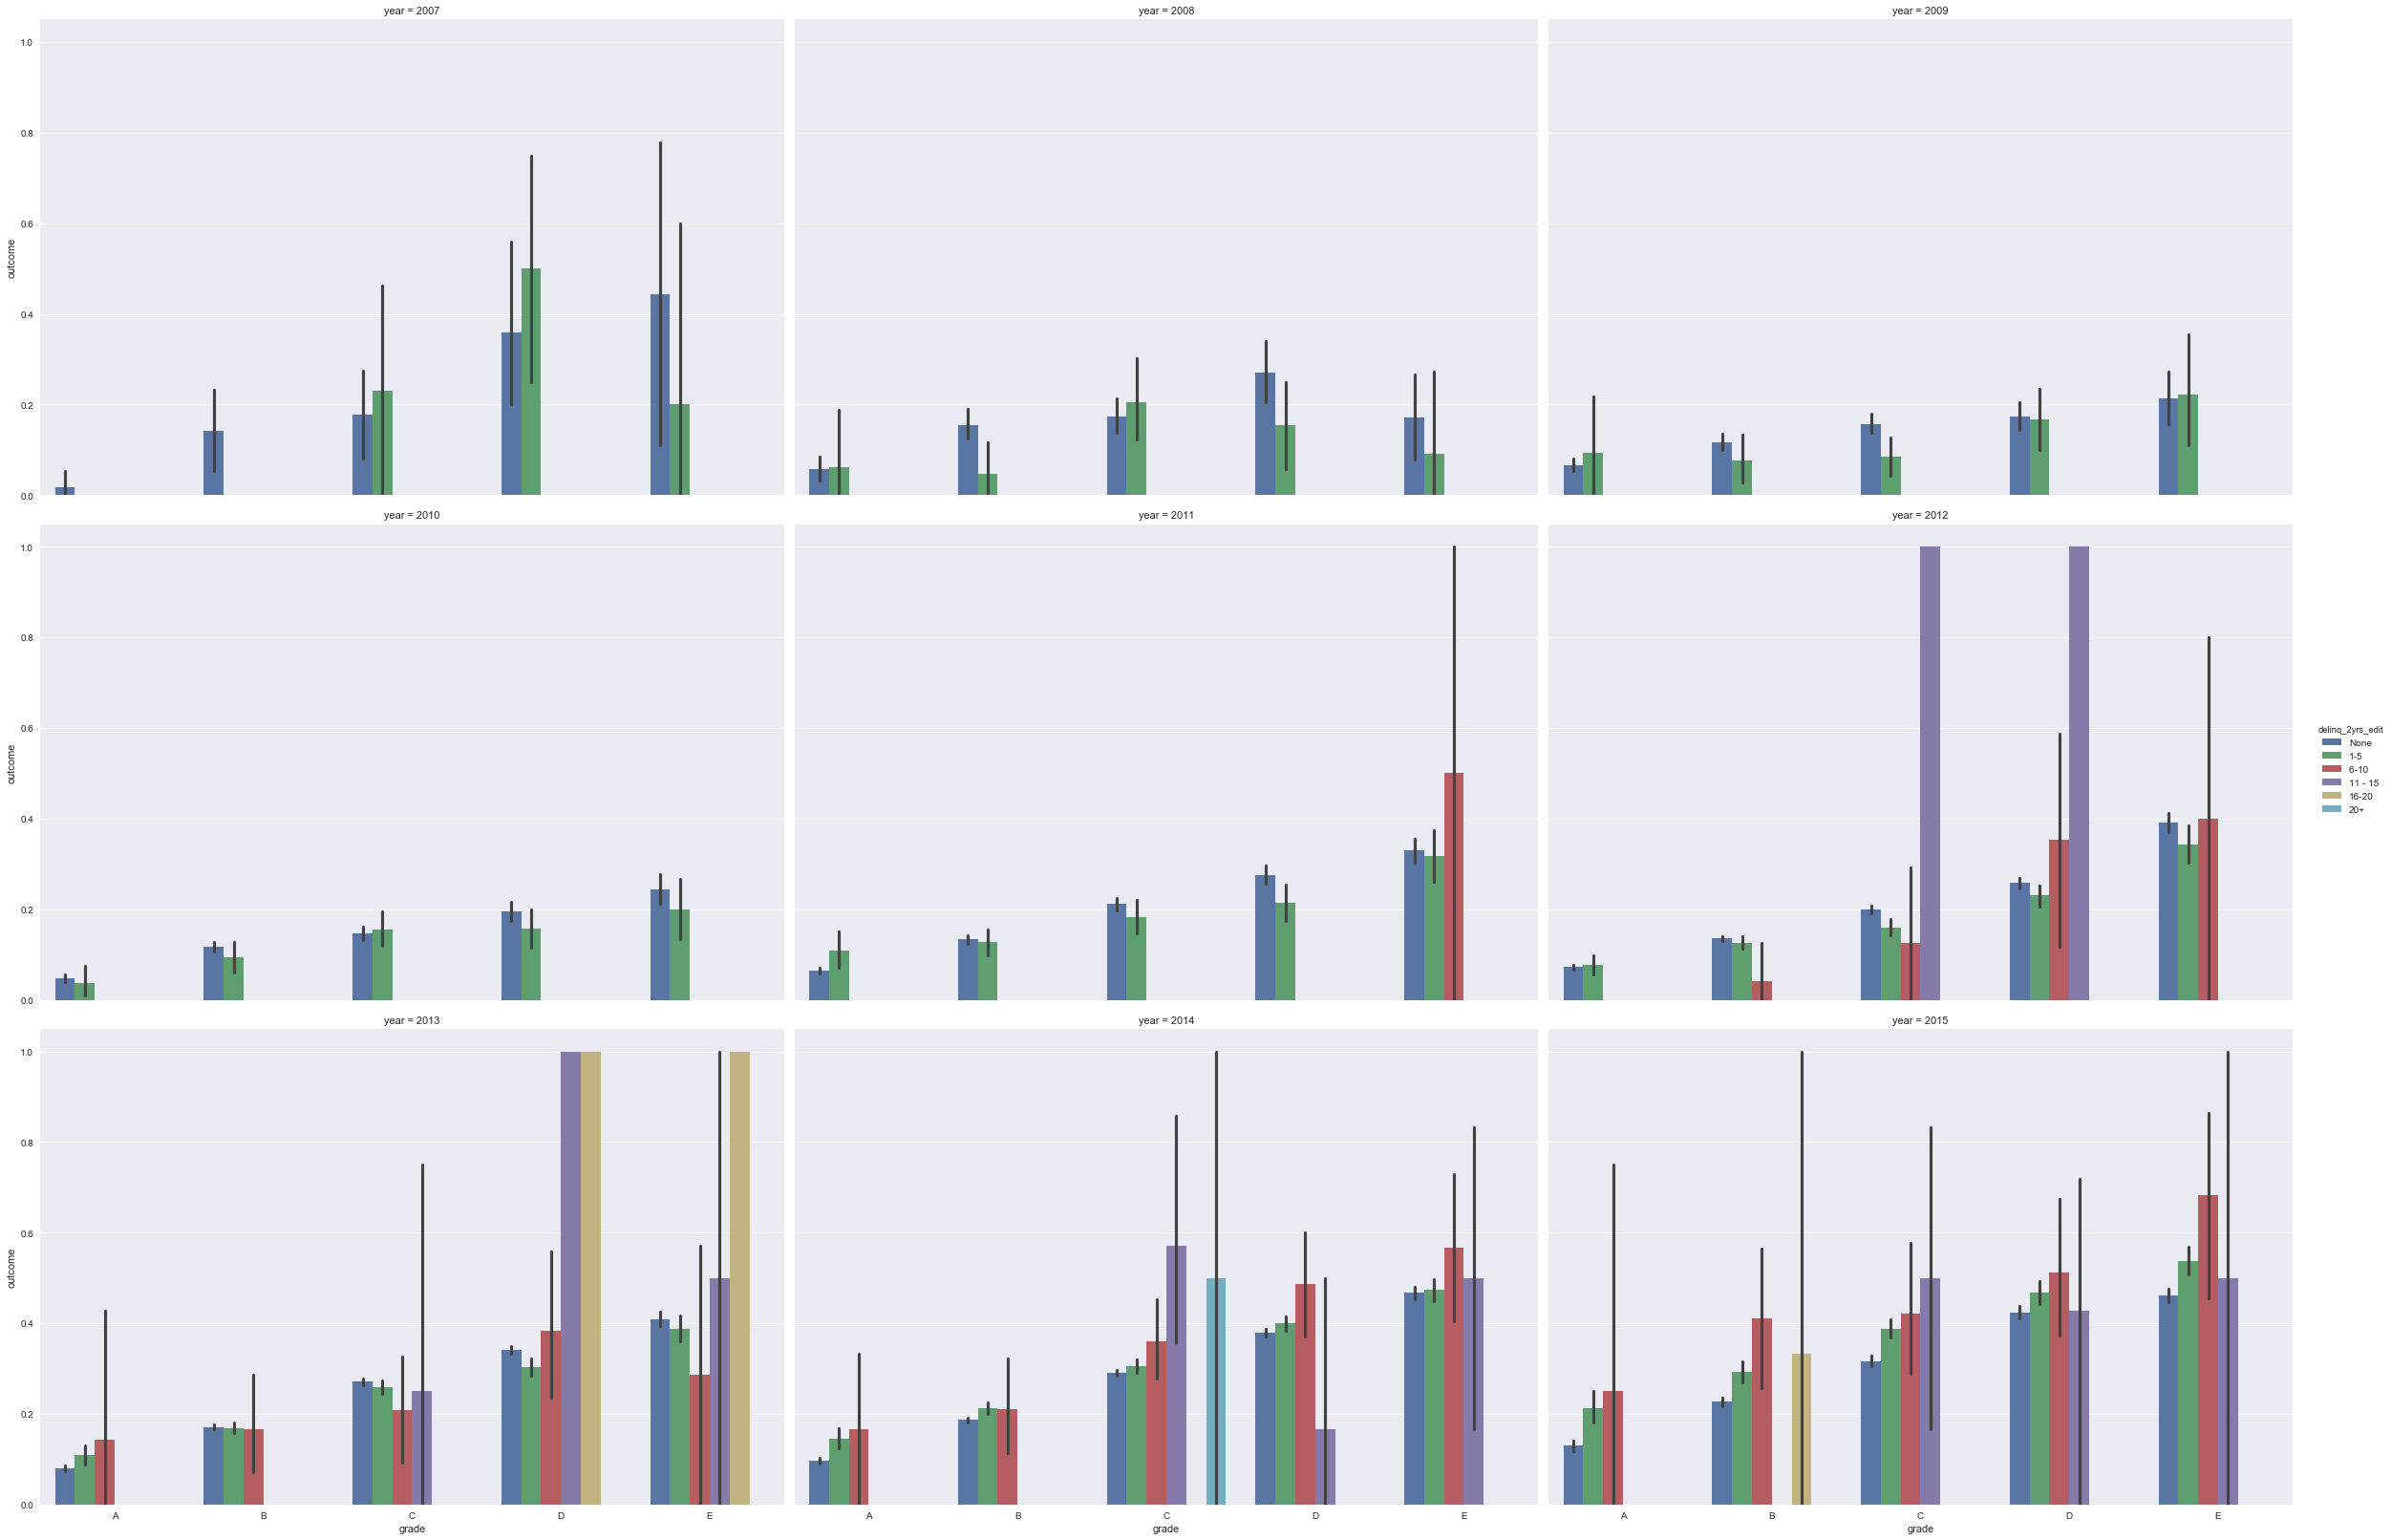

In [17]:
g = sns.factorplot(x='grade', y='outcome', hue='delinq_2yrs_edit', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

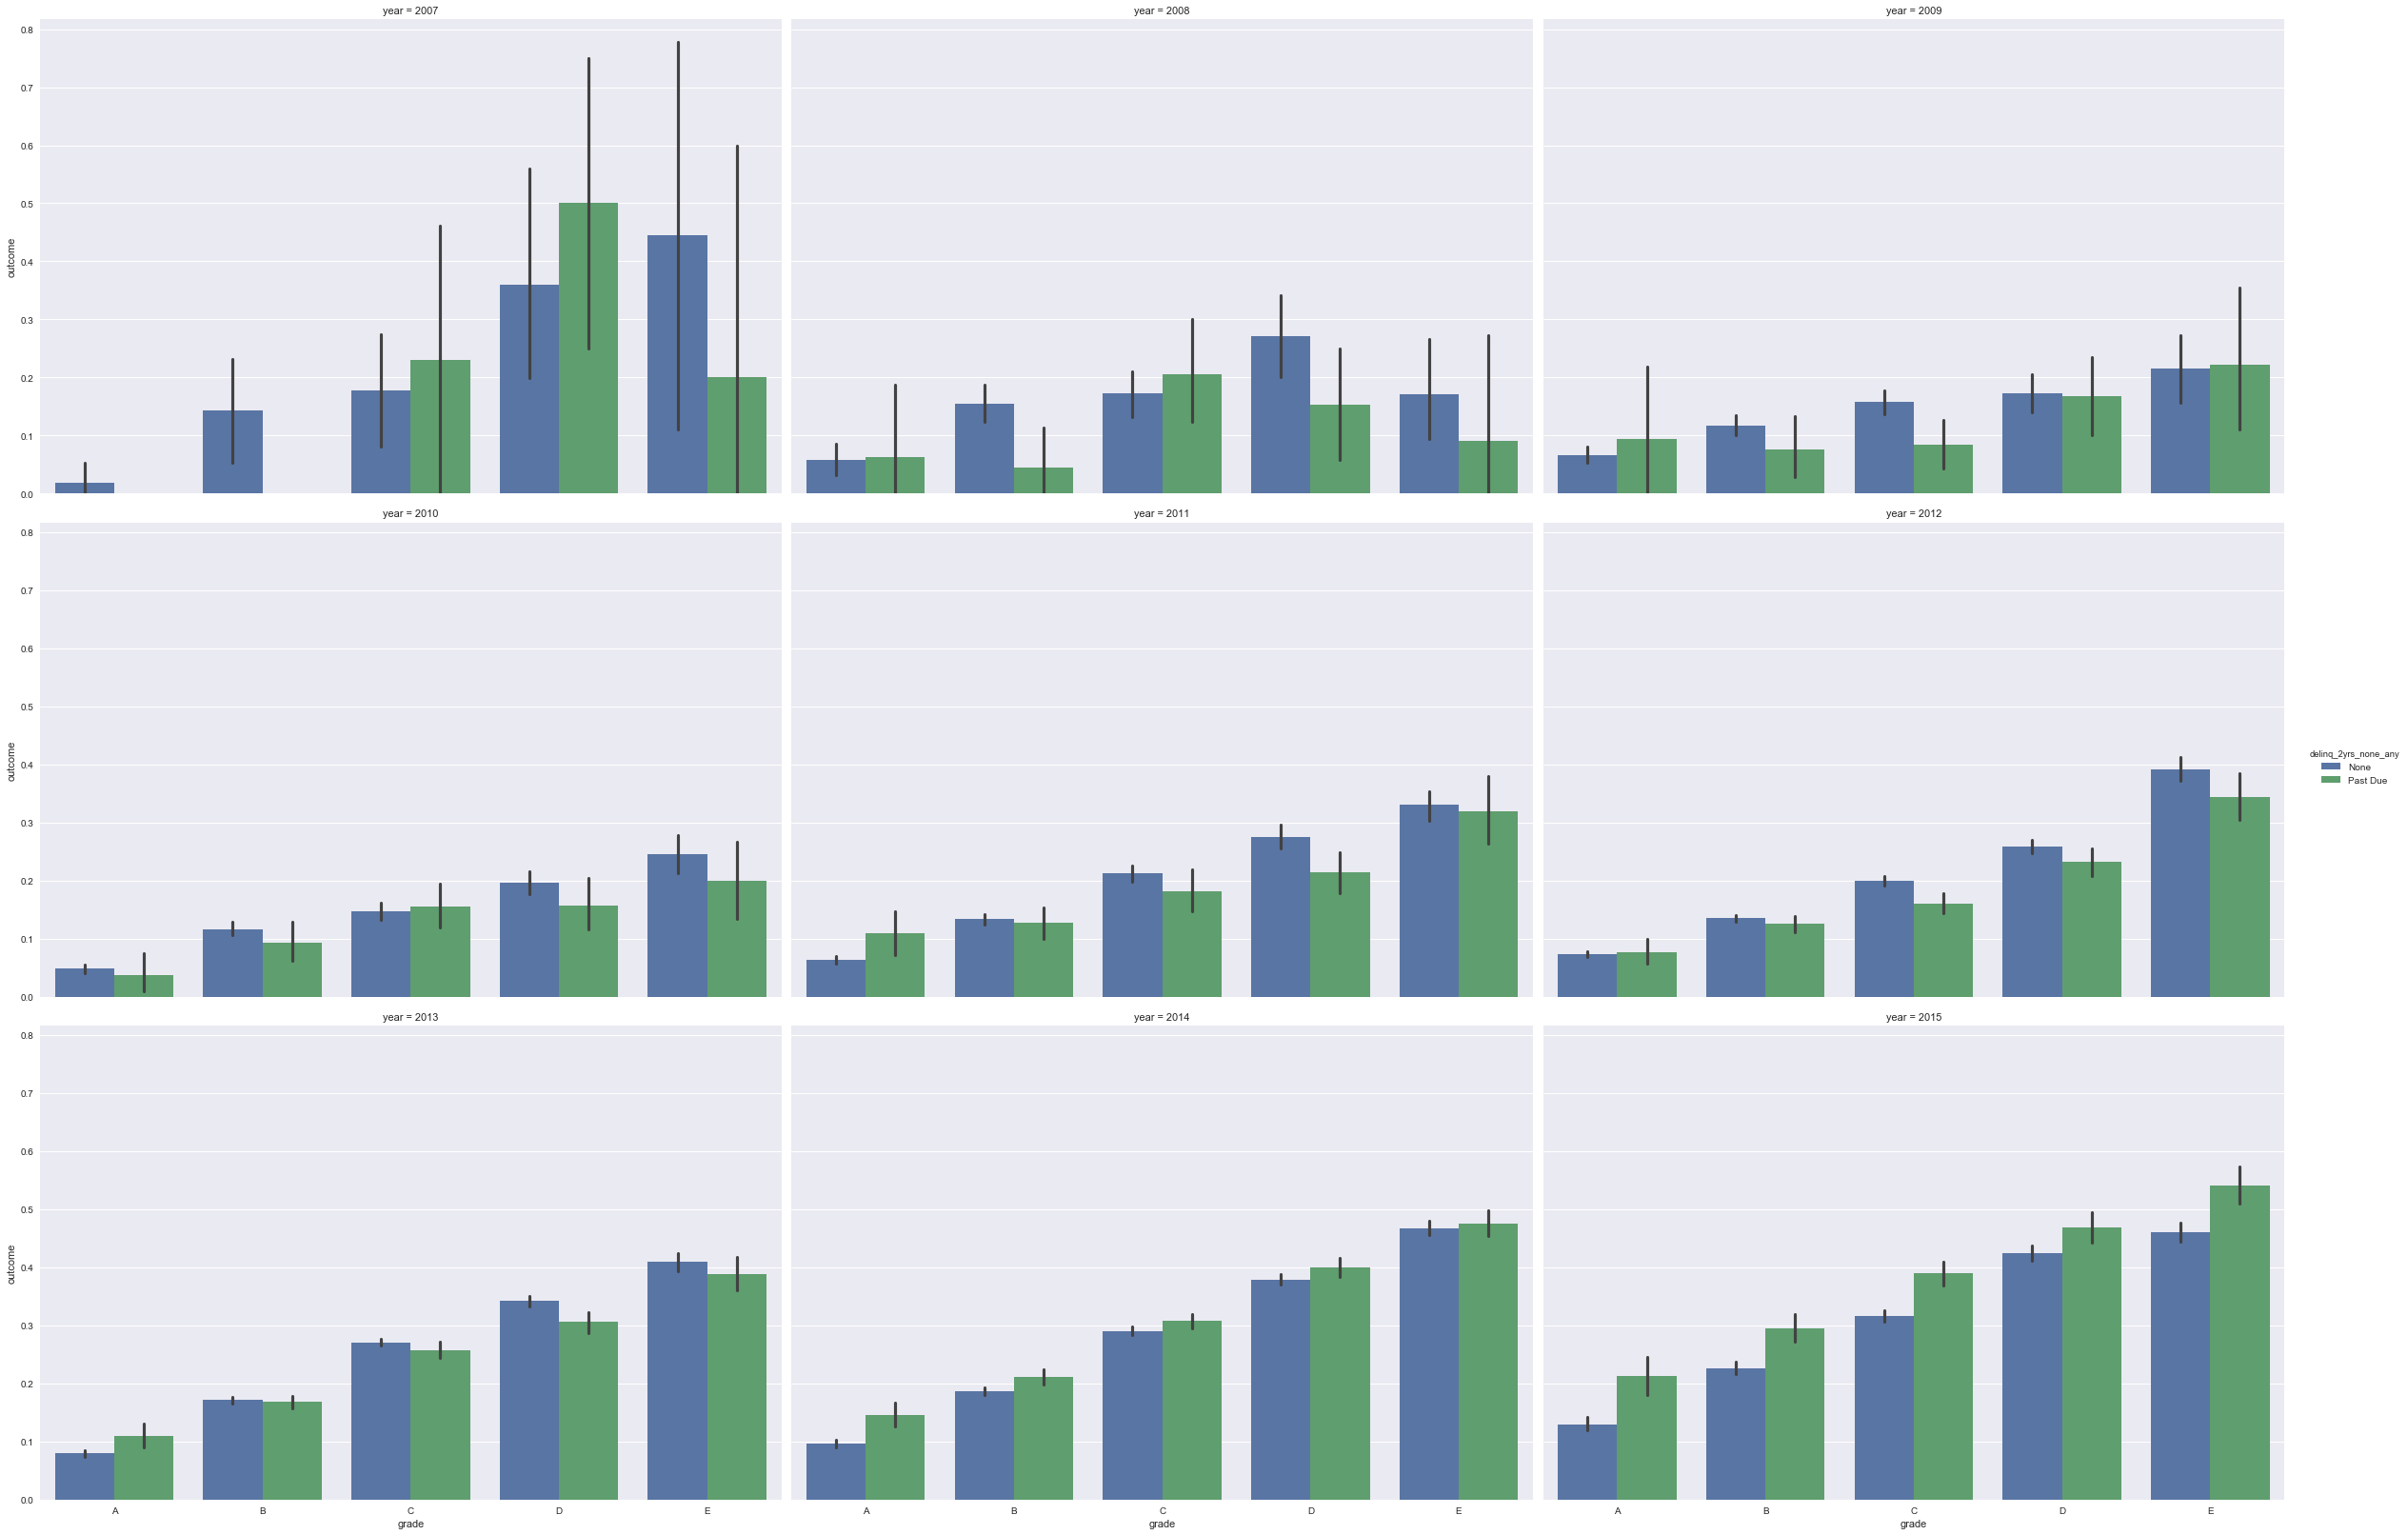

In [18]:
g = sns.factorplot(x='grade', y='outcome', hue='delinq_2yrs_none_any', col='year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

An increase in the rate of default with the presence of any past due seems to hold for the years 2014-2015.


In [1]:

import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set(color_codes=True)
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer 
from sklearn.metrics import roc_auc_score
from astropy.stats import median_absolute_deviation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [2]:
#read in pickled data frame created in  0.2-LC-data exploration current notebook
loans_outcome = pd.read_pickle('../data/loans_outcome_new.pkl')

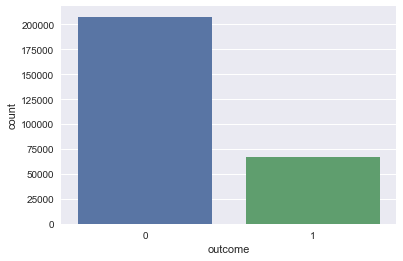

In [46]:
# Take a look at the distribution of the dependent variable outcome: 
sns.countplot(data=loans_outcome,
                  x ='outcome')
                  

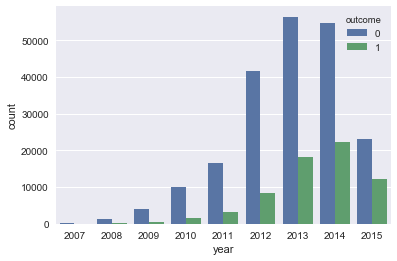

In [47]:
# Take a look at the distribution of the dependent variable outcome plotted by year: 
sns.countplot(data=loans_outcome,
                  x ='year', hue='outcome')
                  

In [48]:
#list(loans_outcome.columns.values)

In [4]:
years_to_keep =['2010', '2011', '2012', '2013', '2014', '2015']
loans_outcome=loans_outcome.loc[loans_outcome['year'].isin(years_to_keep)]
loans_outcome.year.unique()

[2011, 2010, 2013, 2012, 2014, 2015]
Categories (6, int64): [2011, 2010, 2013, 2012, 2014, 2015]

## From the bar charts looking at rate of default vs each feature by year and loan grade decided the following:
1. Use only the data from 2010-1015 as the data from 2007 -2009 seemed inconsistant.
2. Drop the attributes present only in the year 2015. 
3. Drop the attributes only available from 2012( total_rev_hi_lim, tot_cur_bal, tot_coll_amnt, mths_since_last_major_derog,   acc_now_delinq, collections_12mths_ex_med)
4. Drop apllication_type as joint accounts present only for 2015
5. Created delinq_2yrs_none_any ( two categories: no delinquencies vs atleast one) to be used instead of delinq_2yrs
6. acc_now_delinq: up until 2011 no delinquent accounts and in 2012 only one loan grade had some. So deliquent account activity present only for 2013-2015.

##  Look at correlations between columns to avoid collinearity issues.

In [6]:
#drop columns that will not be used as independent variables or those whose quantiles are being used in the heatmap.
col_to_drop_corr =['id',
  'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'mths_since_last_major_quant',                  
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'loan_amnt',
  'year', 
 'mths_since_last_delinq_quant',  
'total_bal_il_quant',          
'open_il_6m_quant',              
'max_bal_bc_quant',           
'all_util_quant',
'revol_util_quant',                
'il_util_quant',                  
'total_rev_hi_lim_quant',
'length_credithist_quant'                   
]

loans_outcome_heatmap=loans_outcome.drop(col_to_drop_corr, axis=1)

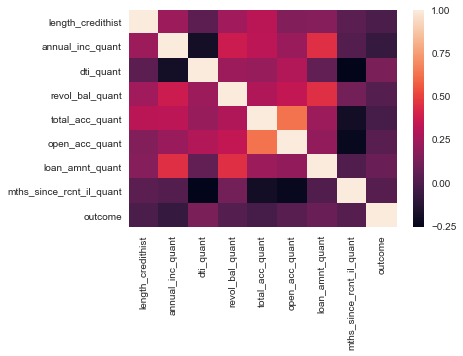

In [7]:
sns.heatmap(loans_outcome_heatmap.corr())

In [8]:
cor = loans_outcome_heatmap.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

open_acc_quant  total_acc_quant    0.626631
dtype: float64

####  total_acc and open_acc_quant have a correlation of 0.62. Keep one or both?
total_acc is the total number of credit lines currently in the borrower's credit file 
open_acc is the the number of open credit lines in the borrower's credit file.
open_acc would probably give the more accurate picture of the borrowers current situation. So drop total_acc and keep open_acc.

####  

## Drop columns  that will not be used as attributes

In [9]:

col_to_drop =['id',
  'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
  'date_issued',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',             
 'length_credithist',
 'annual_inc',
 'dti',
 'revol_bal',
 'revol_util',
 'total_acc_quant',
 'open_acc',                                  
 'loan_amnt',
 'mths_since_last_delinq_quant',
 'mths_since_last_major_quant',
 'mths_since_last_record',
 'verified_joint_edt',             
 'open_il_6m_quant',                 
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'pub_rec',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'earliest_credit_date',
 'open_acc_6m',
 'open_il_6m_quant',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il_quant',
 'total_bal_il_quant',
 'il_util_quant',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc_quant',
 'all_util_quant',
 'total_rev_hi_lim_quant',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'tot_coll_amt_quant',
'collections_12_mths_ex_med' ,
'mths_since_last_major_derog',
'application_type',
'tot_coll_amt' ,                 
'tot_cur_bal',                    
'open_il_6m' ,                 
'mths_since_rcnt_il' ,           
'total_bal_il' ,                
'il_util',                        
'max_bal_bc',                   
'all_util',
'total_rev_hi_lim',
'quarter',
'delinq_2yrs_edit' ,
'open_acc_6mths_edit' ,           
'open_il_12m_edit',               
'open_rv_12m_edit' ,             
'open_rv_24m_edit' ,           
'inq_fi_edit',                
'total_cu_tl_edit',               
'inq_last_12m_edit',
'open_il_24m_edit', 
'open_il_24m_edit' ,                
'acc_now_delinq_edit' ,              
'tot_cur_bal_quant' ,                 
'collections_12_mths_ex_med_quant' ,
 'mths_since_last_record_quant',    
'mths_since_last_delinq' ,             
 'year',
'total_acc' ]

loans_outcome_X=loans_outcome.drop(col_to_drop, axis=1)

In [10]:
loans_outcome_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267862 entries, 0 to 887371
Data columns (total 16 columns):
term                       267862 non-null object
purpose_regrp              267862 non-null object
home_regrp                 267862 non-null object
pub_rec_edit               267862 non-null category
emp_length_regrp           267862 non-null object
delinq_2yrs_none_any       267862 non-null category
inq_last_6mths_edit        267862 non-null category
length_credithist_quant    267862 non-null float64
annual_inc_quant           267862 non-null float64
dti_quant                  267862 non-null int64
revol_bal_quant            267862 non-null int64
revol_util_quant           267671 non-null float64
open_acc_quant             267862 non-null float64
verified_edt               267862 non-null object
loan_amnt_quant            267862 non-null int64
outcome                    267862 non-null int64
dtypes: category(3), float64(4), int64(4), object(5)
memory usage: 29.4+ MB


In [11]:

loans_outcome = pd.get_dummies(loans_outcome_X)
loans_outcome.info()              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267862 entries, 0 to 887371
Data columns (total 39 columns):
length_credithist_quant          267862 non-null float64
annual_inc_quant                 267862 non-null float64
dti_quant                        267862 non-null int64
revol_bal_quant                  267862 non-null int64
revol_util_quant                 267671 non-null float64
open_acc_quant                   267862 non-null float64
loan_amnt_quant                  267862 non-null int64
outcome                          267862 non-null int64
term_ 36 months                  267862 non-null uint8
term_ 60 months                  267862 non-null uint8
purpose_regrp_consumer           267862 non-null uint8
purpose_regrp_debt               267862 non-null uint8
purpose_regrp_home               267862 non-null uint8
purpose_regrp_other              267862 non-null uint8
home_regrp_MORTGAGE              267862 non-null uint8
home_regrp_OTHER                 267862 non-null uint8
h

## Prepare the data for Machine Learning algorithms

In [12]:

X = loans_outcome.drop("outcome", axis=1) # drop labels for training set
y= loans_outcome["outcome"].copy()

### Create a Test Set: use startified sampling by outcome


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.30)


# Missing Values?

# impute missing values?


In [14]:

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(X_train) 
X = imp.transform(X_train)
X_tr=pd.DataFrame(X, columns=X_train.columns)

In [ ]:
# SMOTE for unbalced data

In [15]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_tr, y_train)

C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
loans_prepared =pd.DataFrame(X_train_res, columns=X_train.columns)
loans_labels=y_train_res

### Look at numerical attribute spreads

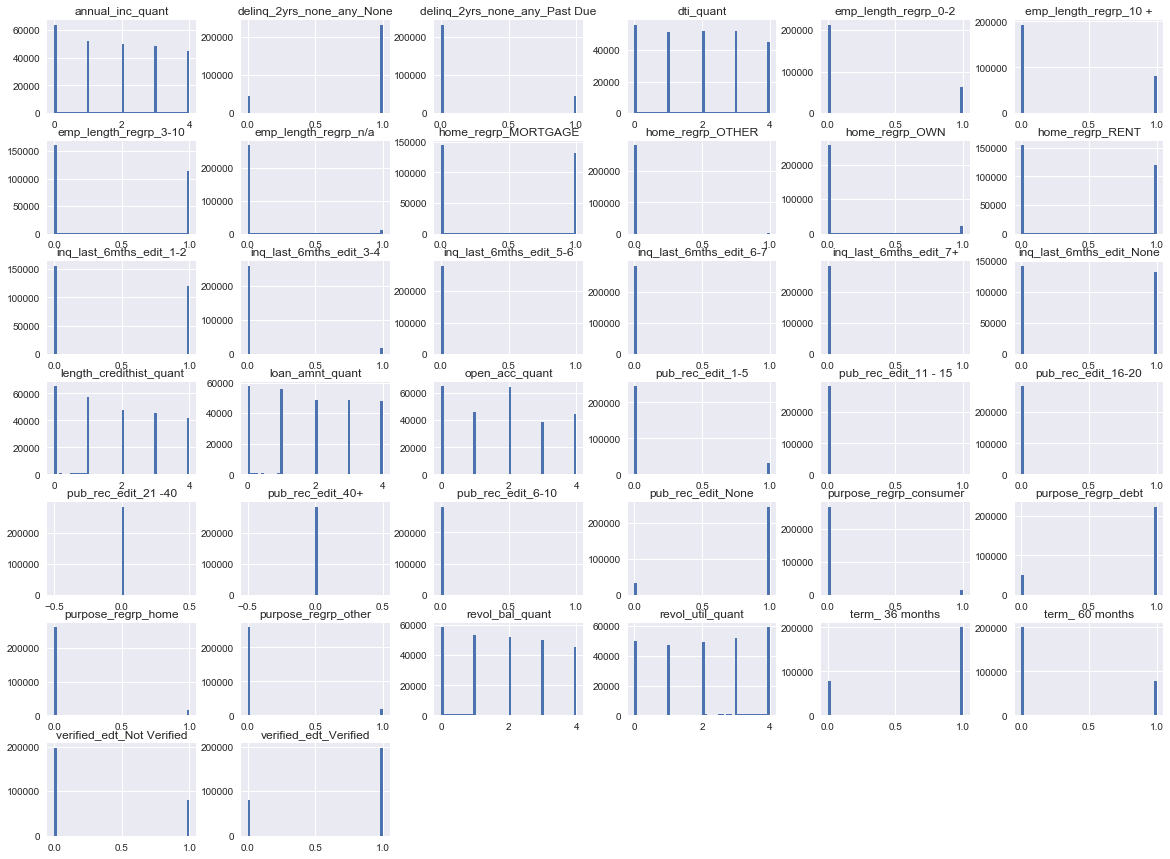

In [17]:
loans_num= loans_prepared.select_dtypes(include=[np.number])

loans_num.hist(bins=50, figsize=(20, 15))
plt.show()

## Select and train a model

### Logistic Regression 

In [18]:
# Create logistic regression object
logreg=LogisticRegression()

# Train the model using the training sets and check score

logreg.fit(loans_prepared, loans_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Evaluating the model

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(logreg, loans_prepared, loans_labels, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(loans_labels, y_train_pred)

array([[89737, 51719],
       [53448, 88008]], dtype=int64)

In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(loans_labels, y_train_pred)

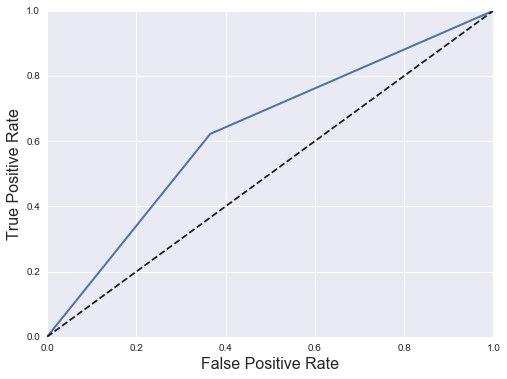

In [22]:

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

plt.show()

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(loans_labels, y_train_pred)

0.62826956792218069

### Random Forest

In [24]:

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, loans_prepared, loans_labels, cv=3,
                                    method="predict_proba")

In [25]:
# For ROC need scores not probabilities. Use positive class probabilities as the score: ref. Machine Learning.
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(loans_labels, y_scores_forest)

In [26]:
roc_auc_score(loans_labels, y_scores_forest)

0.84675246305271201

### K-nearest neighbor

In [46]:
#from sklearn import metrics
#from sklearn.neighbors import KNeighborsClassifier

#knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')

#knn_result=knn.fit(loans_prepared, loans_labels)
        
#y_train_pred = cross_val_predict(knn, loans_prepared, loans_labels, cv=3)
      
      


### Linear SVM

In [27]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(C=100, loss="hinge", random_state=42)
    
svm_clf.fit(loans_prepared, loans_labels)

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [28]:


y_train_pred_svm = cross_val_predict(svm_clf, loans_prepared, loans_labels, cv=3)


In [29]:
confusion_matrix(loans_labels, y_train_pred_svm)

array([[75985, 65471],
       [51508, 89948]], dtype=int64)

In [30]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(loans_labels, y_train_pred_svm )


### AdaBoost

In [31]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier()
ada_clf.fit(loans_prepared, loans_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [32]:
y_train_pred_ada = cross_val_predict(ada_clf, loans_prepared, loans_labels, cv=3)

In [33]:
confusion_matrix(loans_labels, y_train_pred_ada)

array([[103958,  37498],
       [ 46380,  95076]], dtype=int64)

In [34]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(loans_labels, y_train_pred_ada )

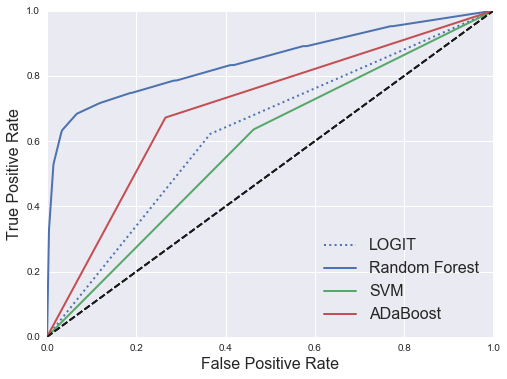

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="LOGIT")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plot_roc_curve(fpr_ada, tpr_ada, "ADaBoost")
plt.legend(loc="lower right", fontsize=16)

plt.show()

## Fine Tune Model
Grid Search
Ensemble

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, loans_prepared, loans_labels, cv=3,
                                    method="predict_proba")

In [38]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



rfc = RandomForestClassifier(n_jobs=-1, max_features= 'auto' ,n_estimators=10, oob_score = True) 

param_grid = { 
    'n_estimators': [700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [50, 100, 200, 500]
}



CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(loans_prepared, loans_labels)

print (CV_rfc.best_params_)

{'max_features': 'sqrt', 'min_samples_leaf': 50, 'n_estimators': 700}


In [39]:
rfc_tuned = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt', n_estimators=700, oob_score = True, min_samples_leaf=50) 


In [40]:
y_probas_forest = cross_val_predict(rfc_tuned, loans_prepared, loans_labels, cv=3,
                                    method="predict_proba")


In [41]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(loans_labels, y_scores_forest)

In [42]:
roc_auc_score(loans_labels, y_scores_forest)

0.81480025545718682

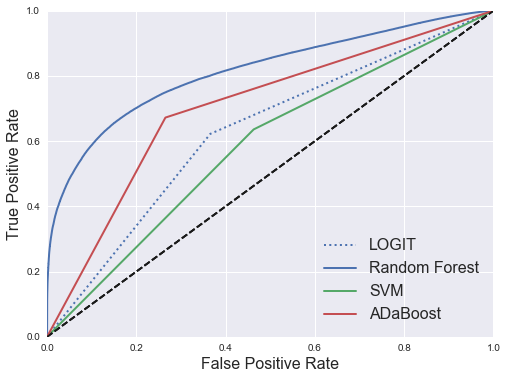

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="LOGIT")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plot_roc_curve(fpr_ada, tpr_ada, "ADaBoost")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [44]:
rfc_tuned.fit(loans_prepared, loans_labels)
feature_importances = rfc_tuned.feature_importances_
feature_importances

array([ 0.04042562,  0.11225389,  0.12217158,  0.03427624,  0.09148044,
        0.02859128,  0.06132106,  0.07717707,  0.07966201,  0.00975375,
        0.02450297,  0.010386  ,  0.0095297 ,  0.04168224,  0.        ,
        0.01118164,  0.04237602,  0.00397293,  0.00377099,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.01040264,
        0.0138791 ,  0.01208878,  0.00724648,  0.01378843,  0.01362079,
        0.02932685,  0.02130727,  0.00744937,  0.00027525,  0.        ,
        0.        ,  0.03182519,  0.03427438])

In [46]:
sorted(zip(feature_importances, loans_prepared.columns), reverse=True)
 

[(0.12217158426414275, 'dti_quant'),
 (0.11225388731762043, 'annual_inc_quant'),
 (0.091480437474951784, 'revol_util_quant'),
 (0.079662010246358467, 'term_ 60 months'),
 (0.077177073694215573, 'term_ 36 months'),
 (0.06132106131704209, 'loan_amnt_quant'),
 (0.042376020274107758, 'home_regrp_RENT'),
 (0.041682238009133017, 'home_regrp_MORTGAGE'),
 (0.040425617754225658, 'length_credithist_quant'),
 (0.034276240247707347, 'revol_bal_quant'),
 (0.03427437720424379, 'verified_edt_Verified'),
 (0.0318251943553935, 'verified_edt_Not Verified'),
 (0.029326853949893063, 'inq_last_6mths_edit_None'),
 (0.02859127842114239, 'open_acc_quant'),
 (0.024502969960715524, 'purpose_regrp_debt'),
 (0.02130727435349937, 'inq_last_6mths_edit_1-2'),
 (0.013879103805509635, 'emp_length_regrp_10 +'),
 (0.013788433436512574, 'delinq_2yrs_none_any_None'),
 (0.013620792630017224, 'delinq_2yrs_none_any_Past Due'),
 (0.012088784927471397, 'emp_length_regrp_3-10'),
 (0.011181644122211853, 'home_regrp_OWN'),
 (0.01

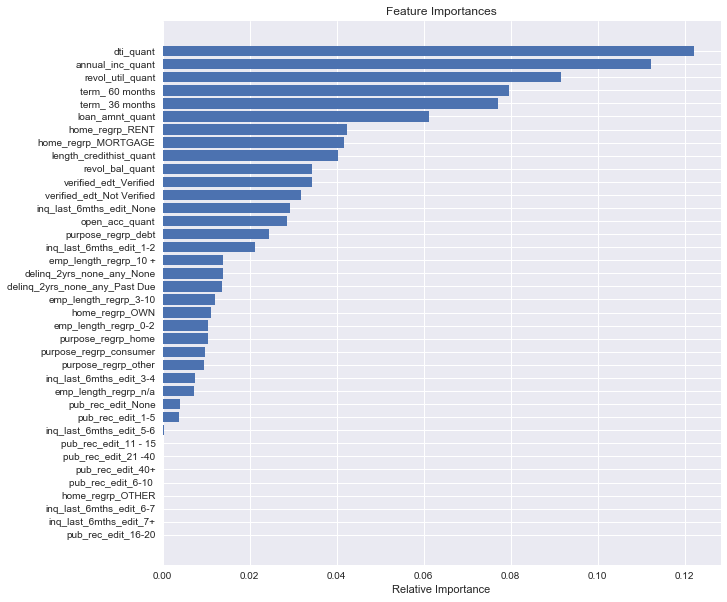

In [53]:
features = loans_prepared.columns
importances = rfc_tuned.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

# Evaluate using Test Set.

In [47]:

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(X_test) 
X = imp.transform(X_test)
X_tst=pd.DataFrame(X, columns=X_test.columns)

In [48]:




final_predictions = rfc_tuned.predict(X_tst)


In [49]:

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, final_predictions)

In [50]:
roc_auc_score(y_test, final_predictions)

0.6001399819881843

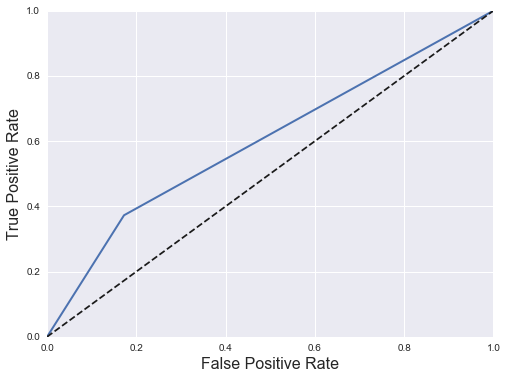

In [51]:
plt.figure(figsize=(8, 6))

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")


plt.show()

In [69]:

import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set(color_codes=True)
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer 
from sklearn.metrics import roc_auc_score
from astropy.stats import median_absolute_deviation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [70]:
#read in pickled data frame created in  0.2-LC-data exploration current notebook
loans_outcome = pd.read_pickle('../data/loans_outcome_new.pkl')

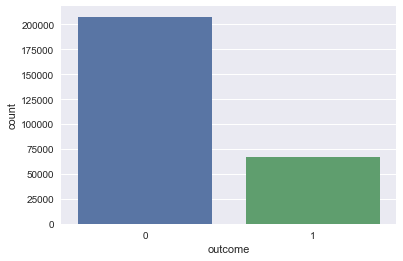

In [71]:
# Take a look at the distribution of the dependent variable outcome: 
sns.countplot(data=loans_outcome,
                  x ='outcome')
                  

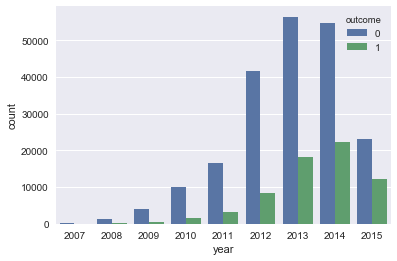

In [72]:
# Take a look at the distribution of the dependent variable outcome plotted by year: 
sns.countplot(data=loans_outcome,
                  x ='year', hue='outcome')
                  

In [73]:
#list(loans_outcome.columns.values)

In [74]:
years_to_keep =['2010', '2011', '2012', '2013', '2014', '2015']
loans_outcome=loans_outcome.loc[loans_outcome['year'].isin(years_to_keep)]
loans_outcome.year.unique()

[2011, 2010, 2013, 2012, 2014, 2015]
Categories (6, int64): [2011, 2010, 2013, 2012, 2014, 2015]

## From the bar charts looking at rate of default vs each feature by year and loan grade decided the following:
1. Use only the data from 2010-1015 as the data from 2007 -2009 seemed inconsistant.
2. Drop the attributes present only in the year 2015. 
3. Drop the attributes only available from 2012( total_rev_hi_lim, tot_cur_bal, tot_coll_amnt, mths_since_last_major_derog,   acc_now_delinq, collections_12mths_ex_med)
4. Drop apllication_type as joint accounts present only for 2015
5. Created delinq_2yrs_none_any ( two categories: no delinquencies vs atleast one) to be used instead of delinq_2yrs
6. acc_now_delinq: up until 2011 no delinquent accounts and in 2012 only one loan grade had some. So deliquent account activity present only for 2013-2015.

## Drop columns  that will not be used as attributes

In [75]:

col_to_drop =['id',
  'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
  'date_issued',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',             
 'length_credithist',
 'annual_inc',
 'dti',
 'revol_bal',
 'revol_util',
 'total_acc_quant',
 'open_acc',                                  
 'loan_amnt',
 'mths_since_last_delinq_quant',
 'mths_since_last_major_quant',
 'mths_since_last_record',
 'verified_joint_edt',             
 'open_il_6m_quant',                 
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'pub_rec',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'earliest_credit_date',
 'open_acc_6m',
 'open_il_6m_quant',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il_quant',
 'total_bal_il_quant',
 'il_util_quant',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc_quant',
 'all_util_quant',
 'total_rev_hi_lim_quant',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'tot_coll_amt_quant',
'collections_12_mths_ex_med' ,
'mths_since_last_major_derog',
'application_type',
'tot_coll_amt' ,                 
'tot_cur_bal',                    
'open_il_6m' ,                 
'mths_since_rcnt_il' ,           
'total_bal_il' ,                
'il_util',                        
'max_bal_bc',                   
'all_util',
'total_rev_hi_lim',
'quarter',
'delinq_2yrs_edit' ,
'open_acc_6mths_edit' ,           
'open_il_12m_edit',               
'open_rv_12m_edit' ,             
'open_rv_24m_edit' ,           
'inq_fi_edit',                
'total_cu_tl_edit',               
'inq_last_12m_edit',
'open_il_24m_edit', 
'open_il_24m_edit' ,                
'acc_now_delinq_edit' ,              
'tot_cur_bal_quant' ,                 
'collections_12_mths_ex_med_quant' ,
 'mths_since_last_record_quant',    
'mths_since_last_delinq' ,             
 'year',
'total_acc', 'pub_rec_edit', 'seven_state', 'delinq_2yrs_none_any', 'purpose_regrp', 'emp_length_regrp', 'inq_last_6mths_edit',
  'verified_edt'        ]

loans_outcome_X=loans_outcome.drop(col_to_drop, axis=1)

In [76]:
loans_outcome_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267862 entries, 0 to 887371
Data columns (total 10 columns):
term                       267862 non-null object
home_regrp                 267862 non-null object
length_credithist_quant    267862 non-null float64
annual_inc_quant           267862 non-null float64
dti_quant                  267862 non-null int64
revol_bal_quant            267862 non-null int64
revol_util_quant           267671 non-null float64
open_acc_quant             267862 non-null float64
loan_amnt_quant            267862 non-null int64
outcome                    267862 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 22.5+ MB


In [77]:

loans_outcome = pd.get_dummies(loans_outcome_X)
loans_outcome.info()              

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267862 entries, 0 to 887371
Data columns (total 13 columns):
length_credithist_quant    267862 non-null float64
annual_inc_quant           267862 non-null float64
dti_quant                  267862 non-null int64
revol_bal_quant            267862 non-null int64
revol_util_quant           267671 non-null float64
open_acc_quant             267862 non-null float64
loan_amnt_quant            267862 non-null int64
outcome                    267862 non-null int64
term_ 36 months            267862 non-null uint8
term_ 60 months            267862 non-null uint8
home_regrp_MORTGAGE        267862 non-null uint8
home_regrp_OTHER           267862 non-null uint8
home_regrp_RENT            267862 non-null uint8
dtypes: float64(4), int64(4), uint8(5)
memory usage: 19.7 MB


## Prepare the data for Machine Learning algorithms

In [78]:

X = loans_outcome.drop("outcome", axis=1) # drop labels for training set
y= loans_outcome["outcome"].copy()

### Create a Test Set: use startified sampling by outcome


In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.30)


In [80]:
print("Train :", X_train.shape)
print ("Test:", X_test.shape)

Train : (187503, 12)
Test: (80359, 12)


# Missing Values?

# impute missing values?


In [81]:

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(X_train) 
X = imp.transform(X_train)
X_tr=pd.DataFrame(X, columns=X_train.columns)

In [82]:
# SMOTE for unbalced data

In [83]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_tr, y_train)

C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [84]:
loans_prepared =pd.DataFrame(X_train_res, columns=X_train.columns)
loans_labels=y_train_res

### Look at numerical attribute spreads

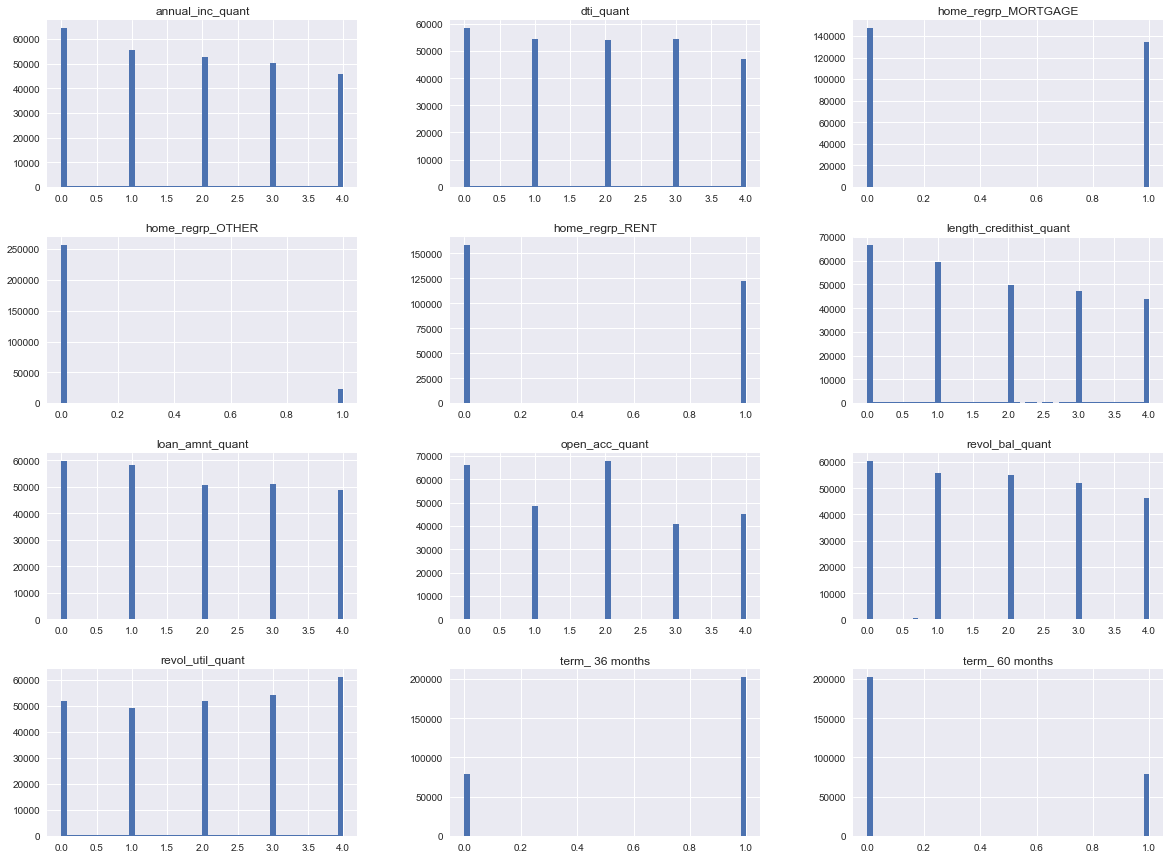

In [85]:
loans_num= loans_prepared.select_dtypes(include=[np.number])

loans_num.hist(bins=50, figsize=(20, 15))
plt.show()

## Select and train a model

### Random Forest

In [86]:
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(loans_prepared, loans_labels)
y_probas_forest = cross_val_predict(forest_clf, loans_prepared, loans_labels, cv=3,
                                    method="predict_proba")

In [87]:
from sklearn.metrics import roc_curve

# For ROC need scores not probabilities. Use positive class probabilities as the score: ref. Machine Learning.
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(loans_labels, y_scores_forest)

In [88]:
roc_auc_score(loans_labels, y_scores_forest)

0.8285774738642544

## Fine Tune Model
Grid Search
Ensemble

In [83]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, loans_prepared, loans_labels, cv=3,
                                    method="predict_proba")

In [123]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



rfc = RandomForestClassifier(n_jobs=-1, max_features= 'auto' ,n_estimators=10, oob_score = True) 

param_grid = { 
    'n_estimators': [700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [50, 100, 200, 500]
}



CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(loans_prepared, loans_labels)

print (CV_rfc.best_params_)

{'max_features': 'sqrt', 'min_samples_leaf': 50, 'n_estimators': 700}


In [90]:
rfc_tuned = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt', n_estimators=700, oob_score = True, min_samples_leaf=50) 


In [91]:
y_probas_forest = cross_val_predict(rfc_tuned, loans_prepared, loans_labels, cv=3,
                                    method="predict_proba")


In [92]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(loans_labels, y_scores_forest)

In [93]:
roc_auc_score(loans_labels, y_scores_forest)

0.77362748513289281

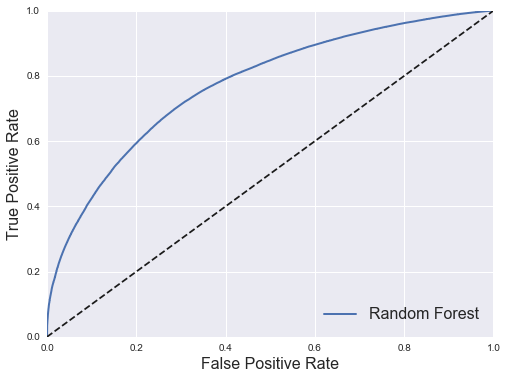

In [94]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)



plt.figure(figsize=(8, 6))

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.legend(loc="lower right", fontsize=16)

plt.show()

In [95]:
rfc_tuned.fit(loans_prepared, loans_labels)
feature_importances = rfc_tuned.feature_importances_
feature_importances

array([ 0.070195  ,  0.15662878,  0.18058753,  0.06873854,  0.13701669,
        0.05755668,  0.0974452 ,  0.08805555,  0.0916216 ,  0.02302976,
        0.0067513 ,  0.02237337])

In [96]:
sorted(zip(feature_importances, loans_prepared.columns), reverse=True)
 

[(0.18058753212723308, 'dti_quant'),
 (0.15662877872212555, 'annual_inc_quant'),
 (0.13701669118198706, 'revol_util_quant'),
 (0.097445195555085184, 'loan_amnt_quant'),
 (0.091621603891510667, 'term_ 60 months'),
 (0.088055550791004911, 'term_ 36 months'),
 (0.070195000875661107, 'length_credithist_quant'),
 (0.068738540054084654, 'revol_bal_quant'),
 (0.057556679074606064, 'open_acc_quant'),
 (0.023029756464670426, 'home_regrp_MORTGAGE'),
 (0.022373371152561272, 'home_regrp_RENT'),
 (0.0067513001094698794, 'home_regrp_OTHER')]

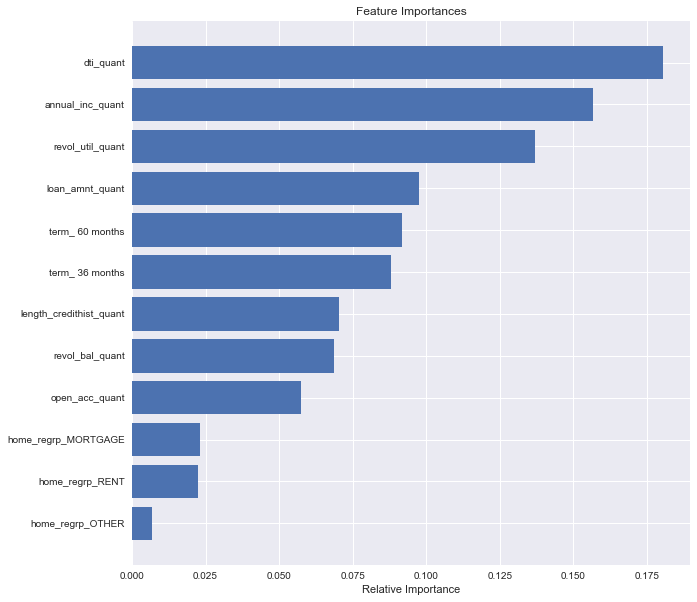

In [97]:
plt.figure(figsize=(10, 10))

features = loans_prepared.columns
importances = rfc_tuned.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

# Evaluate using Test Set.

In [98]:

imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(X_test) 
X = imp.transform(X_test)
X_tst=pd.DataFrame(X, columns=X_test.columns)

In [99]:




final_predictions = rfc_tuned.predict(X_tst)


In [100]:

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, final_predictions)

In [101]:
roc_auc_score(y_test, final_predictions)

0.61434591021052698

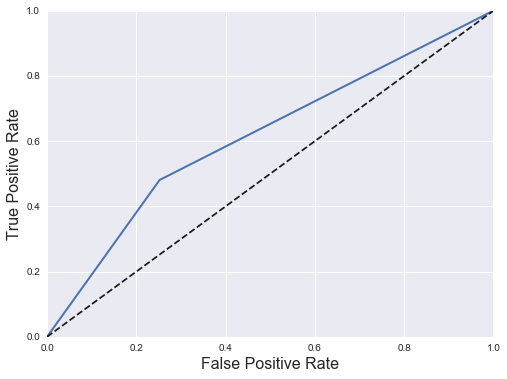

In [102]:
plt.figure(figsize=(8, 6))

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")


plt.show()